In [19]:
import msgpack
import open3d as o3d
# import trimesh
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import time
import threading


import ipywidgets.widgets as widgets
import ipywidgets
from IPython.display import display

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

# %autoawait off

import socket
# import asyncio
# # # !pip install nest-asyncio
# import nest_asyncio
# # nest_asyncio.apply() 

In [20]:
PI = np.pi
TWO_PI = 2*np.pi

# UDP header constant
UDP_RESET=15
UDP_ROBOT_STATE_REPORT=14
UDP_MOTOR_SPEED_COMMEND=13
UDP_MOTOR_POS_COMMEND=12


ip_local = "127.0.0.1"
port_local = 32000

ip_remote = "127.0.0.1"
port_remote = 32001

BUFFER_LEN = 512 #in bytes

local_address = (ip_local,port_local)
remote_address = (ip_remote,port_remote)

packer = msgpack.Packer(use_single_float=True,use_bin_type =True)

### Create a UDP socket

In [21]:
# https://adaickalavan.github.io/programming/udp-socket-programming-in-cpp-and-python/
# Python UDP Receiver
#Create a datagram socket
sock = socket.socket(socket.AF_INET, # Internet
                     socket.SOCK_DGRAM) # UDP
#Enable/disable immediate reuse of IP address
sock.setsockopt(socket.SOL_SOCKET,socket.SO_REUSEADDR,0)
#Set a timeout so the socket does not block indefinitely when trying to receive data
sock.settimeout(1)
#Bind the socket to the port
sock.bind(local_address)
# sock.connect(remote_address)

# for closing connection:
# sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
# sock.close()# close the connection

### test receiving udp packet

In [23]:
s = time.perf_counter()
try:
    data = sock.recv(BUFFER_LEN)
    data_unpacked = msgpack.unpackb(data)
    print(data_unpacked)
except Exception as e:
    print(e)
    pass
# sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
# sock.close()# close the connection

elapsed = time.perf_counter() - s

print(f"#--- executed in {elapsed*1000:0.2f} ms ---#")


[14, 0.0025, [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [1.7462301614046547e-14, 1.0, 3.686287386450773e-15, 9.246955240427076e-15, -3.686287386450934e-15, 1.0], [-1.577436955112623e-07, -4.59336190380038e-08, -9.799999827649735], [-3.9398203111421897e-16, -1.1492364424885326e-16, 0.029598356415068635]]
#--- executed in 0.50 ms ---#


### test sending udp packet

In [4]:
# sen_sock = initUDP(ip_remote, port_local) # socket that send udp packet

# data_send = [UDP_RESET,time.time(),[0,0,0,0]]
data_send = [UDP_MOTOR_SPEED_COMMEND,time.time(),[2,2,-2,-2]]

# data_send = [0.5,0.0,1.0,2.0]
# data_send = [1,2,3,4]

# data_send = 20

data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
# data_send_packed = msgpack.packb(data_send)

num_bytes_send = sock.sendto(data_send_packed,remote_address)

print(data_send)
print(data_send_packed)

[13, 1597820029.4605107, [2, 2, -2, -2]]
b'\x93\r\xcaN\xbey\x99\x94\x02\x02\xfe\xfe'


In [24]:
w_max = round(200.0/60.0*np.pi*2)

pos_max = np.pi

flag_start = True
flag_should_send = False

# stop button
button_stop = widgets.Button(
    description='stop',
    icon='stop',
    button_style='warning')

def OnClickButtonStop(b):
    global flag_start
    flag_start=False
button_stop.on_click(OnClickButtonStop)  

# reset button
button_reset = widgets.Button(
    description='reset',
    icon='refresh',
    button_style='info')
def OnClickButtonReset(b):
    global joint_vel_widgets
    for w in joint_vel_widgets:
        w.value=0
button_reset.on_click(OnClickButtonReset) 


# restart button
button_restart = widgets.Button(
    description='restart',
    icon='refresh',
    button_style='warning')

def OnClickButtonRestart(b):
    OnClickButtonReset(b)
    flag_start=True
    data_send = (UDP_RESET,time.time(),(0, 0, 0, 0))
    data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
    sock.sendto(data_send_packed,remote_address)
#     print("restarted")
button_restart.on_click(OnClickButtonRestart) 




joint_vel_widgets = [
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description=""),#front left 
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description=""),#back left  
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description=""),#front right
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="")#back right 
]

joint_pos_widgets = [
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description=""),#front left 
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description=""),#back left  
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description=""),#front right
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="")#back right 
]

joint_labels = [
    widgets.Label(value='front left'),
    widgets.Label(value='back left'),
    widgets.Label(value='front right'),
    widgets.Label(value='back right'),
]


caption_list = [
    widgets.Label(value='[Joint Angle]'),
    widgets.Label(value='[Joint speed]'),
    widgets.Label(value='[Orientation]'),
    widgets.Label(value='[Accelerration]'),
    widgets.Label(value='[Position]'),
]

    
ui_vel_pos_widget = widgets.HBox([
    widgets.VBox([widgets.Label("")]+joint_labels),
    widgets.VBox([widgets.Label(" joint vel [rad/s]")]+joint_vel_widgets),
    widgets.VBox([widgets.Label("joint pos [rad]")]+joint_pos_widgets)])

ui = widgets.VBox([ui_vel_pos_widget]+caption_list)

# def f(w0, w1, w2, w3):
#     global flag_should_send
#     flag_should_send = True
# #     time_now = time.time()
# #     data_send = (UDP_MOTOR_SPEED_COMMEND,time_now,(w0, w1, w2, w3))
# # #     display(data_send)
# # #     data_send_packed = msgpack.packb(data_send)
# #     data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
# # #     display(data_send_packed)
# #     sock.sendto(data_send_packed,remote_address)
# # #     display((f"{time.time():3.3f}", (w0, w1, w2, w3)))
    
# out = widgets.interactive_output(f, {
#     'w0': joint_vel_widgets[0],
#     'w1': joint_vel_widgets[1],
#     'w2': joint_vel_widgets[2],
#     'w3': joint_vel_widgets[3]
# })
# out.layout.height = '350px'
# out.layout.width = '350px'


buttons_ui = widgets.HBox((button_stop,button_reset,button_restart))

# app = widgets.VBox(
#     children = (ui, out,buttons_ui))
app = widgets.VBox(
    children = (ui,buttons_ui))

# display(app)

In [18]:
np.zeros(4,dtype=np.float64).tolist()

[0.0, 0.0, 0.0, 0.0]

In [56]:
update_interval = 1/200 - 1e-5

display_update_interval = 1/20


def AppControl():
    time_previous = 0
    display_timer = 0
    
    global flag_start
    global joint_vel_widgets
    flag_start=True
    new_receive = False
    
    pos_cmd  = np.zeros(4,dtype=np.float64) # joint positions command 
    vel_cmd  = np.zeros(4,dtype=np.float64) # joint velocities command

    # previously commanded joint velocity
    joint_vel_prev = np.asarray((w.value for w in joint_vel_widgets))
    
    while flag_start:
        
        try:
            data_receive= sock.recv(BUFFER_LEN)
            data_receive_unpacked = msgpack.unpackb(data_receive)
            new_receive = True
            time_now = data_receive_unpacked[1]
        except socket.timeout:
#             print("rec_socket timed out!\r",end='')
            pass
        
        time_now = time.time()
#         display(time_now)

#         if time_now-time_previous>update_interval:
#             k = int(np.fmod(time_now,0.1)*100)
#             for k in range(4):
#                 joint_vel_widgets[k].value = np.fmod(time.time(),2)
        
        if time_now-time_previous>update_interval:
            time_previous = time_now
            
            
            motor_pos_meas = np.asarray(data_receive_unpacked[2])
            # assumming motor_pos_meas is in [-pi,pi]

#             motor_pos_meas[motor_pos_meas<0]+= 2*np.pi
            
#             motor_vel_cmd = 0.8*np.pi - motor_pos_meas
            
            for k in range(4):
#                 joint_vel_widgets[k].value = 10.0*motor_vel_cmd[k]
                pos = gaits[k].GetPos(time_now)
                if k>=2:
                    pos = TWO_PI- pos 
                if pos>PI:
                    pos=pos-TWO_PI      
                pos_cmd[k] = pos
                
                pos_error = pos - motor_pos_meas[k]
                
                if pos_error>PI:
                    pos_error =-TWO_PI+pos_error
                elif pos_error<-PI:
                    pos_error = TWO_PI+pos_error
                    
                vel_cmd[k] = 8*pos_error
                
            if time_now - display_timer>display_update_interval:
                display_timer = time_now
                for k in range(4):
                    joint_pos_widgets[k].value = pos_cmd[k]
                    joint_vel_widgets[k].value = vel_cmd[k]
                
                
            # send data
            data_send = (UDP_MOTOR_SPEED_COMMEND,time_now,vel_cmd.tolist())
#             display(data_send)
            data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
            sock.sendto(data_send_packed,remote_address)
            
#             print(f"{np.fmod(time_now,1.0)*100}\r",end='')
            
            # data checking the header should be a certain number(TODO)
            if new_receive:
#                 and data_receive_unpacked[0]:
                new_receive = False
                #caption_list.value=f"{data_receive_unpacked}"
#                 for k,caption in enumerate(caption_list):
#                     caption.value = " ".join(f"{x:<+10.3f}" for x in data_receive_unpacked[2+k])
                    
#                 caption_list[-1].value = f"{np.fmod(time_now,1.0)*100}"
            
    print("exit")
    
control_thread = threading.Thread(target=AppControl)
display(app)
control_thread.start()

60.00000000000001 90.0 119.99999999999999
60.00000000000001 90.0 119.99999999999999
60.00000000000001 90.0 119.99999999999999
60.00000000000001 90.0 119.99999999999999


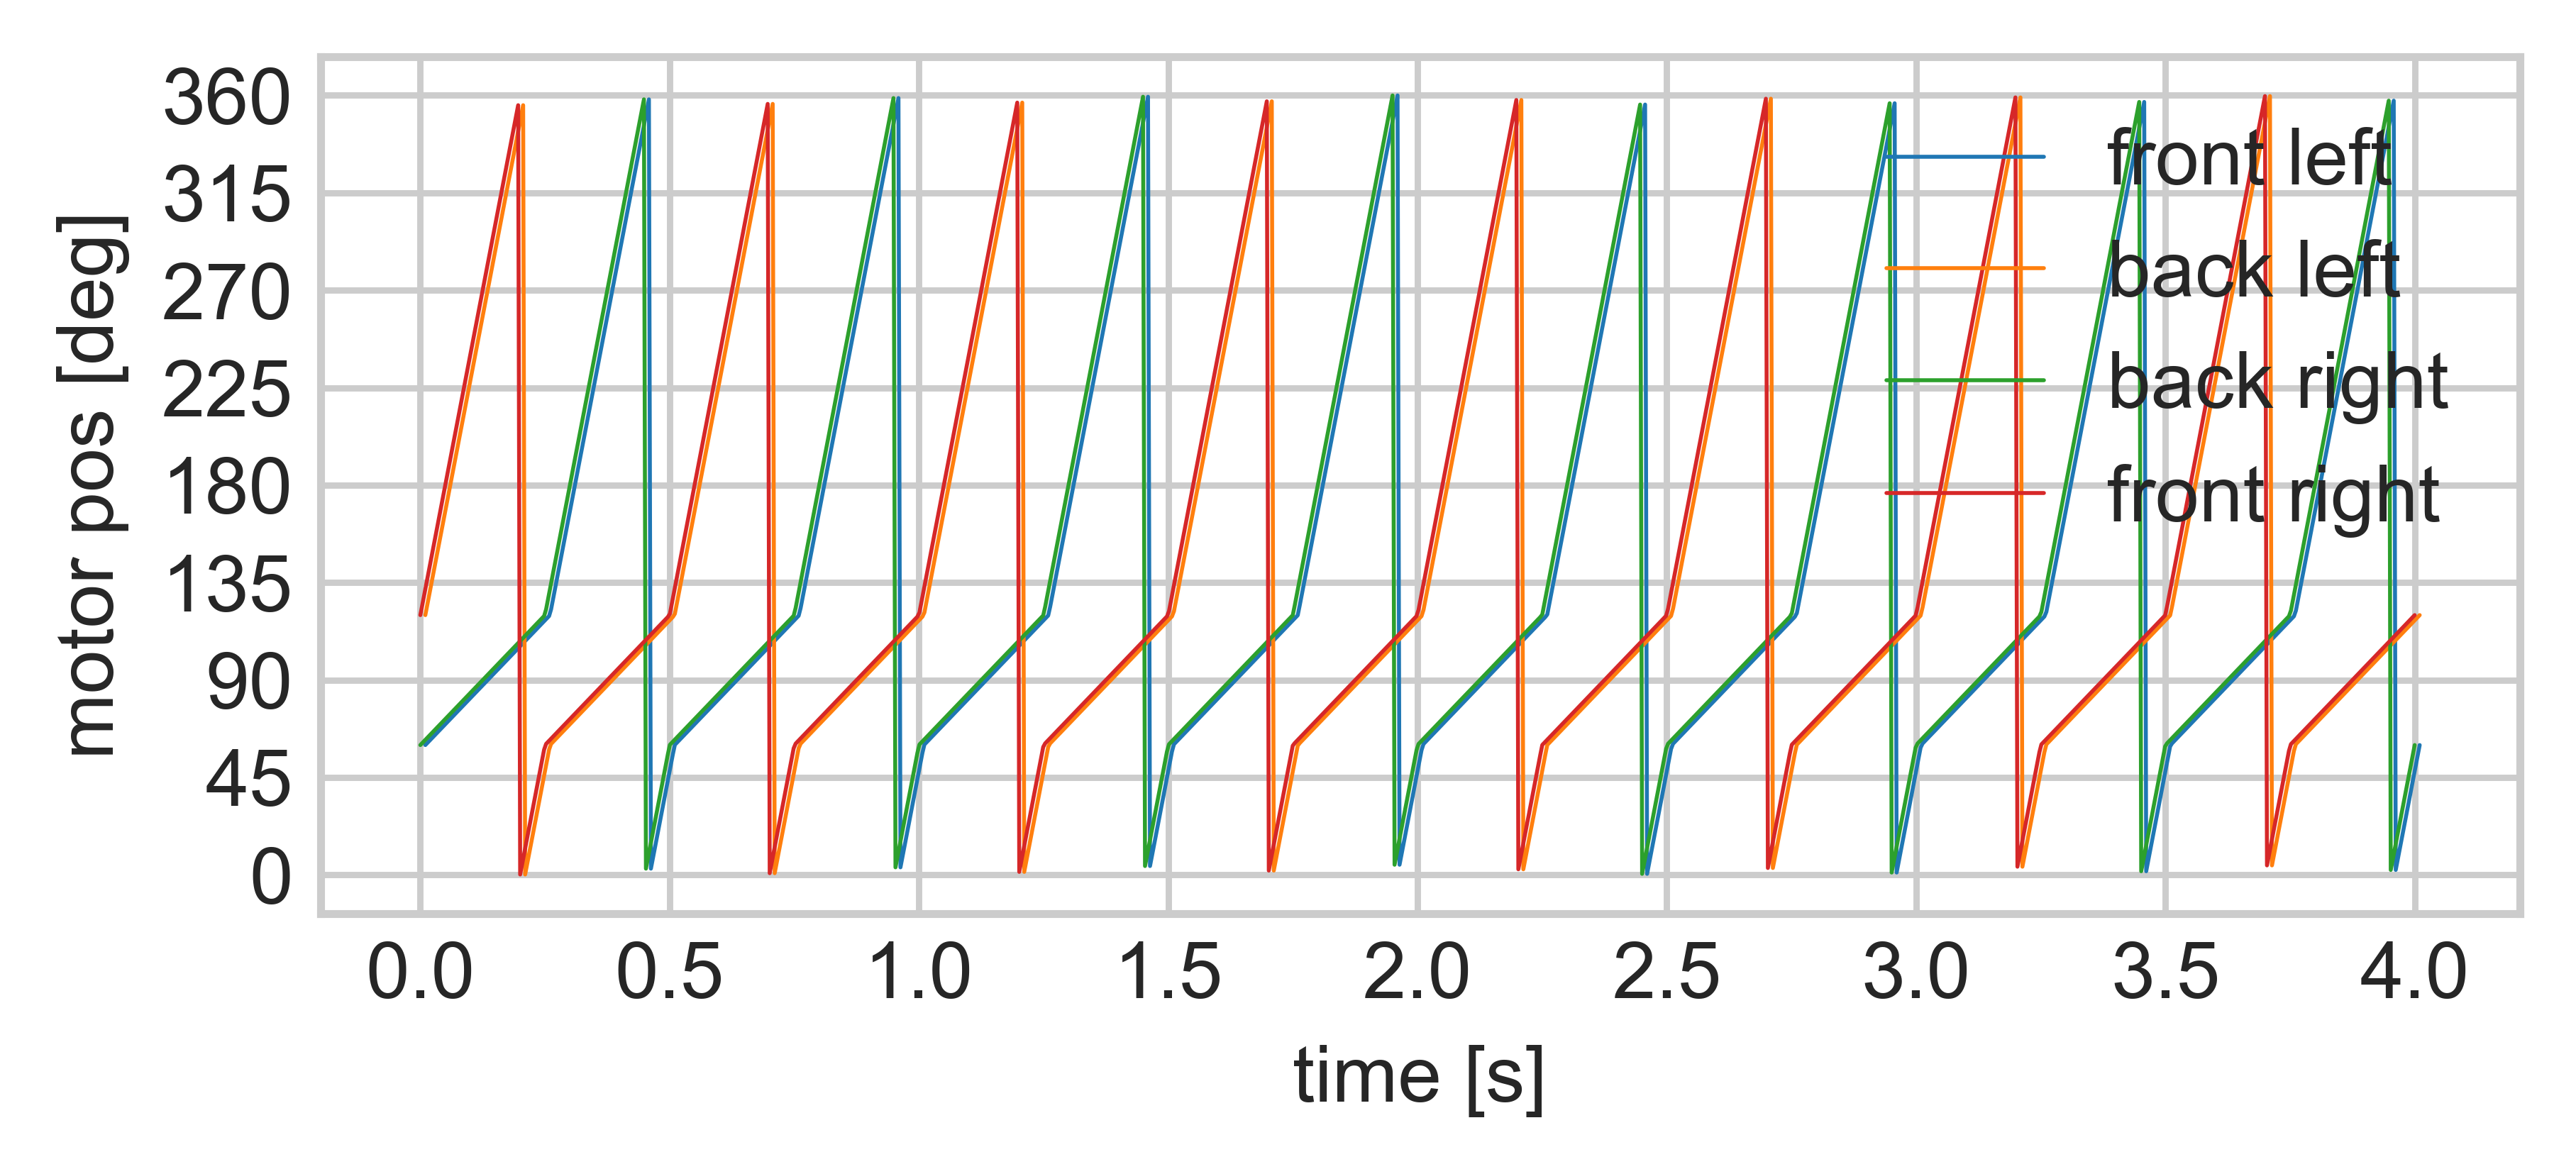

In [55]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'


PI = np.pi
TWO_PI = 2*np.pi

class WalkingTrot():
    """
  trotting gait
  @author: HonboZhu, BoxiXia
  """
    def __init__(this,
                 ot = 0, # normalized time offset [0-1], [unitless]
                 w = 0.1*np.pi, # average angular velocity [rad/s]
                 s = 0.5, # stance ratio = stance_time/cycle_time [unitless]
                 contact_angle = 1.0/3.0*PI, # contact_angle [rad]
                 p_stance_mid = 1.*np.pi,# angle at the middle of the stance phase [rad]
                ):
        this.ot = ot # normalized time offset [0-1], [unitless]
        assert(0<=this.ot<=1)
        this.w = abs(w) # average angular velocity [rad/s]
        this.dir = np.sign(w) # direction of the angular velocity
        this.T = 2*np.pi/this.w # cycle time
        this.c = contact_angle # contact_angle [rad]
#         this.contact_angle
        this.p_stance_mid = p_stance_mid       
        this.p_stance_low = p_stance_mid - this.c/2.0
        
        this.UpdateStanceRatio(s)
#         this.p_stance_low =0
        
        this.p_stance_high = p_stance_mid + this.c/2.0
        print(np.rad2deg(this.p_stance_low),np.rad2deg(p_stance_mid),np.rad2deg(this.p_stance_high))
        
        # get the initial position
        if this.ot<this.s: # if normalized time offset < stance ratio
            this.pos = this.p_stance_low + this.c/this.s*this.ot
        else:
            this.pos = this.p_stance_low + this.c + (TWO_PI-this.c)/(1-this.s)*(this.ot-this.s)
        
#     @njit
    def UpdateStanceRatio(this,s):
        """
        update the stance ratio s (=: stance_time/cycle_time [unitless])
        """
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ts = this.s * this.T # stance_time
        this.ws = this.c/(this.ts) # w_stance, average angular velocity of stance phase [rad/s]
        this.wa = (TWO_PI-this.c)/((1-this.s)*this.T) # w_air, average angular velocity of air phase [rad/s]
    

    def GetPos(this, t,w=None):
        """
        return the position [0,2pi] [rad] given the current time [s]
        """
        if w==0:
            return this.pos
        if (w is not None) and (w!=this.w):
            this.UpdateAngularVelocity(t,w)
            
        tc = (t+this.ot*this.T)%this.T # converted time [0-T,seconds]
        
        # todo sign
        if tc<this.ts: # 0-stance_time
            this.pos = (this.p_stance_low + this.ws*tc)%TWO_PI
        else:
            this.pos = (this.p_stance_low + this.c+this.wa*(tc-this.ts))%TWO_PI
        return this.pos

    def UpdateAngularVelocity(this,t,w):
        T2 = 2*np.pi/w # new cycle time
#         print(w)
        tn1 = (t+this.ot*this.T)%this.T/this.T
        this.ot = (tn1 +1 - (t%T2)/T2)%1.0
        this.T = T2
        this.w = w # TODO direction
        
        this.ts = this.s * this.T # stance_time
        this.ws = this.c/(this.ts) # w_stance, average angular velocity of stance phase [rad/s]
        this.wa = (TWO_PI-this.c)/((1-this.s)*this.T) # w_air, average angular velocity of air phase [rad/s] 
#         print(this.ws,this.wa)
#         tn2 = (t+this.ot*this.T)%this.T/this.T
#         print(tn1,tn1-tn2)

    
gaits = [
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi),# front left
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi), # back left
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi), # back right
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi) # front right
]

t_arr = np.linspace(0,4,1000)
w_arr = 4*PI*np.ones_like(t_arr)
# w_arr[80:] = 5*PI

# w_arr = np.linspace(0,2*TWO_PI,1000)


angle1 = np.array([gaits[0].GetPos(t,w) for t,w in zip(t_arr,w_arr)])
angle2 = np.array([gaits[1].GetPos(t,w) for t,w in zip(t_arr,w_arr)])
angle3 = np.array([gaits[2].GetPos(t,w) for t,w in zip(t_arr,w_arr)])
angle4 = np.array([gaits[3].GetPos(t,w) for t,w in zip(t_arr,w_arr)])

# angle3 = 2*np.pi-angle1
# angle4 = 2*np.pi-angle2
# motor_pos = np.stack((angle1,angle2,angle3,angle4),axis=1)

# vel1 = np.array([trot.GetVel(phase) for phase in t_arr])
# vel2 = np.array([trot.GetVel(phase+0.5) for phase in t_arr])
# vel3= -vel1
# vel4= -vel2
# motor_vel = np.stack((vel1,vel2,vel3,vel4),axis=1)

plt.figure(figsize=(5,2),dpi=400)
plt.plot(t_arr+0.01,np.rad2deg(angle1),',-',markersize=0.5,linewidth=0.5,alpha=1.0,label='front left')
plt.plot(t_arr+0.01,np.rad2deg(angle2),',-',markersize=0.5,linewidth=0.5,alpha=1.0,label='back left')
plt.plot(t_arr,np.rad2deg(angle3),',-',markersize=0.5,linewidth=0.5,alpha=1.0,label='back right')
plt.plot(t_arr,np.rad2deg(angle4),',-',markersize=0.5,linewidth=0.5,alpha=1.0,label='front right')

plt.yticks(np.arange(0, 360+45, 45))

plt.ylabel("motor pos [deg]")
plt.xlabel("time [s]")
plt.legend()
plt.show()

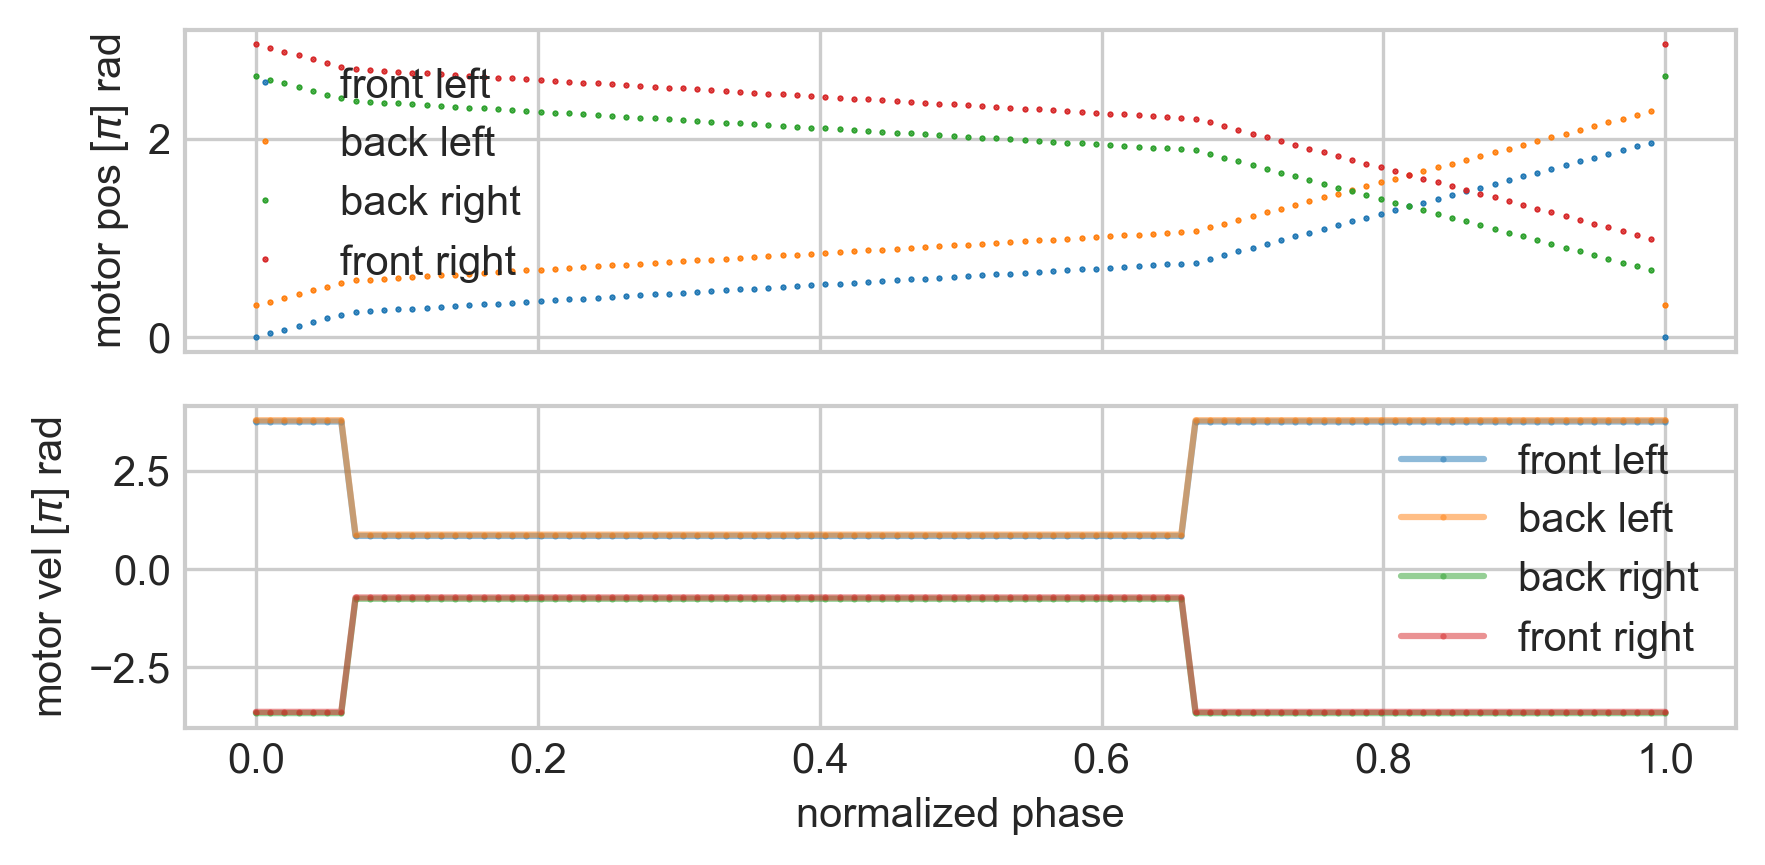

In [14]:
labels= ('front left','back left','back right','front right')
f,axes = plt.subplots(2,1,figsize=(6,3),dpi=150,squeeze=True,sharex=True)
ax = axes[0]
for k in range(4):
    ax.plot(phase_arr,(motor_pos[:,k]+k)/(np.pi),'.',label=labels[k],markersize=1)
ax.set_ylabel("motor pos [$\pi$] rad")
# ax.set_xlabel("normalized phase")
ax.legend()

ax = axes[1]
for k in range(4):
    ax.plot(phase_arr,(motor_vel[:,k]+k*0.1)/(np.pi),marker='.',label=labels[k],markersize=1,alpha=.5)
ax.set_ylabel("motor vel [$\pi$] rad")
ax.set_xlabel("normalized phase")
ax.legend()
plt.tight_layout()
plt.show()

In [40]:
items = [widgets.Label(str(i)) for i in range(4)]
widgets.Box(items)

Box(children=(Label(value='0'), Label(value='1'), Label(value='2'), Label(value='3')))

In [42]:
items = [widgets.Label(str(i)) for i in range(8)]data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABuUAAANhCAYAAADwtbYGAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAuIwAALiMBeKU/dgAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzdeXiU9b3+8XsmOxNCwiI7CRASSJBNBeupiKJ1q4cAbV3QVi0u/R231noul2OhrbW2tS7F1o2qVQER0eBSN7RWLUVFK4XsgWysDQlJyCSTZJj5/THOmIFkJnkmsyXv13V5keeZ+c58B3QMc+dzPyan0+kUAAAAAAAAAAAAgKAxh3sDAAAAAAAAAAAAQH9HKAcAAAAAAAAAAAAEGaEcAAAAAAAAAAAAEGSEcgAAAAAAAAAAAECQEcoBAAAAAAAAAAAAQUYoBwAAAAAAAAAAAAQZoRwAAAAAAAAAAAAQZIRyAAAAAAAAAAAAQJARygEAAAAAAAAAAABBRigHAAAAAAAAAAAABBmhHAAAAAAAAAAAABBkhHIAAAAAAAAAAABAkBHKAQAAAAAAAAAAAEFGKAcAAAAAAAAAAAAEGaEcAAAAAAAAAAAAEGSEcgAAAAAAAAAAAECQEcoBAAAAAAAAAAAAQUYoBwAAAAAAAAAAAAQZoRwAAAAAAAAAAAAQZIRyAAAAAAAAAAAAQJARygEAAAAAAAAAAABBRigHAAAAAAAAAAAABBmhHAAAAAAAAAAAABBkhHIAAAAAAAAAAABAkBHKAQAAAAAAAAAAAEFGKAcAAAAAAAAAAAAEWWy4NwAEg8PhUFtbm9e5mJgYmUymMO0IAAAAAAAAAACEk9Pp1NGjR73OJSQkyGwOzQwboRz6pba2NhUWFoZ7GwAAAAAAAAAAIILl5OQoKSkpJM9FfSUAAAAAAAAAAAAQZIRyAAAAAAAAAAAAQJARygEAAAAAAAAAAABBxjXl0C/FxMQcdy4nJ0exsfwrL0k2m02lpaWe46ysLCUmJoZxRwD6G95nAAQb7zMAgo33GQDBxHsMgGDjfaZrdrtdhYWFXue6yhOChYQC/ZLJZDruXGxsrOLi4sKwm8hjt9u9jvm9AdDXeJ8BEGy8zwAINt5nAAQT7zEAgo33mZ7rKk8IFuorAQAAAAAAAAAAgCAjlAMAAAAAAAAAAACCjPrKENm3b19YnnfMmDFheV4AAAAAAAAAAAB8jVAuRM4666yQ9pJKrh7UYy9YCAAAAAAAAAAAgNAjlAsxp9MZ7i0AAAAAAAAAAAAgxAjlQqingdyxE3X+1vX2/gAAAAAAAAAAAAgtQrkQueGGG3p0v/Lycr311lsymUxyOp2Kj4/XGWecoRkzZmjSpEkaPHiwEhIS1NzcrAMHDmjHjh165513VF9fL5PJpJiYGN16663Kzc0N8isCAAAAAAAAAABATxHKhUhPQrni4mI999xznkDue9/7nn7yk58oNTW12zVLly7VXXfdpaeeekqrVq3S0aNH9fDDD+vxxx/XvHnz+vIlAAAAAEC/5LBa1fBKvtpKSpSQna3UxXkyWyzh3hYAAACAfoZQLkK0t7frtttuU2Njo0wmk2677Tb98Ic/7NHauLg4XXfddUpPT9ePf/xj2Ww23XbbbXrttdc0ZMiQIO8cAAAAAKKXw2pV5WXL1FZS4jnXsGGDMtau8RvMEeYBAAAA6A1CuQjxxhtvqKysTCaTSfPnz+9xINfZeeedp7/97W/atGmTamtrtXHjRl199dVB2C0AAAAA9A/uUM2cnKz49HS1V1WpraREDfn5GrpsWbfrwhHmEQICAAAA0Y1QLkK89tprnq9/8IMfGH6cSy+9VJs2bZIkvfPOO4RyAAAAAOCDO1SLT0+XraBAibm5shUUqK24xOe6UId5gYSA7vUEgQAAAEB4EcpFiF27dnm+PvHEEw0/TlZWlufrmpqagPYEAAAAAP1dQna2JKm9qkqJublqr6pynZ+a7XNdqMM8o+uk8ASBhHkAAADA8czh3gBc6urqPF/Hx8cbfhyn0+n5tampKeB9AQAAAEB/lro4TwnZ2XI0N8tWUCBHc7MrRMrL87mur8K8+PR013k/YZ7RdZJ3oJeYmytzcrIn0AvGOneYd/Cee9SwYYMO3nOPKi9bJofV6nevDqtV9c+v0f67f6b659f0aE1frAUAAABCgUm5CGGxWNTY2CjJNTWXk5Nj6HEKCgo8Xw8ZMqRP9gYAAAAA/ZXZYlHG2jVqyM9XW3GJEqa6Ajl/U12pi/PUsGGD2kpKZPvq72HBDPOMrpOMT/VFS7VnX6yl2hMAAAChQCgXIaZMmaJt27ZJkl5++WXDodxf/vIXSZLJZDL8GAAAAAAwkJgtFr8VkF2tCWWYZ3Sd+35S6ILAUId5gaz1FebJ3H25ENWeAAAAMIJQLkKcfvrp2rZtm5xOp1544QUtXLhQ3/jGN3r1GC+88ILee+89z/E555zT19sEAAAAAHwllGGe0XVS6IPAUId5gaz1FeYlLVliaF2wpgHd65nqAwAAiF6EchFiyZIleuyxx2Sz2WS32/X//t//0+23366LL77Y79r29nb94Q9/0FNPPSWTySSn06mRI0dq0aJFIdg5AAAAAKA3jIR5ga4LZRAY6jAvkLW+wrwkg+t8CWQa0GigR7UnAABA5CCUixAjRozQ9ddfrwcffFAmk0mtra1auXKlHn/8cZ177rk68cQTNW7cOFm++ib2yJEjqqys1Jdffqk333xTTU1NcjqdklzVlStXrlR8fHw4XxIAAAAAIEKEMggMdZgXyNpoqfaUjAd6oZ7qC9c0IAAAQDQglIsg1157rYqKivTWW295Jt727dunZ555xuc6p9Mpk8nkWXPbbbdpwYIFIdkzAAAAAADHCmWYF8haX2Fem8F1vgQyDWg00Av1VF84pgHda5nqAwAAkY5QLoKYTCY98MADSk9P1+rVq3X06FGZTCZJ8kzBdbXGHcYNHjxYP//5z3XBBReEctsAAAAAAPQJoxN9Rtf6DPNaW42t8yGQacBomeoLxzRgNFV7BroWAABEN0K5CGM2m/XjH/9YeXl5+vOf/6y3335bR44c6fb+TqdTQ4cO1dKlS3X11VcrLS0thLsFAAAAACC6RUO1p2Q80IuWak8peqb6Ag3zwhEEAgCAyEAoF6EmTpyoe+65RytWrNCOHTtUVFSkPXv2yGq1SpIsFovGjx+v6dOna/r06TKbzWHeMQAAAAAA8CeQENBIoBfqqb5wTANGS7VnIGup9gQAoH8glItwcXFxmjNnjubMmRPurQAAAAAAgDCKhqm+cEwDRku1ZyBrqfYEAKB/IJQDAAAAAADAcUIZArrXRcNUXyAVnaEOAqn2BAAgshDK9WPFxcWaOnVquLcBAAAAAADQI9Ew1RdIRWeog0CqPan2BABEFkK5CNXe3q6amho1NjbKbrfL4XDI6XR2ed+jR4+qo6NDNptNzc3Nqqmp0datW7Vz504VFhaGeOcAAAAAAAChFQ3VnoGspdqze9FU7ele3/BKvqyFBYodPFj2+fOlxMQeryMIBIDoRigXYQ4cOKAHHnhAmzdvVmtrq+HHcTqdMplMfbgzAAAAAAAASMZDQKNrqfbsXrRUe0rHB3rxkmL/9oFsK37Wq3US1Z4AEK0I5SLI7t27demll6qpqanbqbieIIwDAAAAAADoX6j27Fq0VHtK3oFe7ITxaquolLm6WrEffiTNmdOjdZFe7RnoWgDo7wjlIshPf/pTNTY2SnIFa52Duc5B27GB3bEhnNPplMVi0TnnnBPE3QIAAAAAACDSUe3ZtVBXe0rHB3qOiRMVU1Ehc3V1r9ZFarVnX6zlGn8A+jtCuQjxj3/8Q4WFhZ6Azel0au7cucrNzZXFYtH69etVW1ur2NhYXXfddXI4HGpublZlZaU+++wz2Ww2z9pzzjlHq1atCufLAQAAAAAAwABEtWf3Ogd68dOmqa2yUpLkmDChx+siudozkLXhuMYfYR6AcCCUixBvv/22JFcYFxMToz/96U8644wzPLfX1dVp3bp1Onr0qObPn6+ZM2d6bmtoaNDdd9+td999V5K0efNmbd68WWeffXZoXwSiRktHizbXbVaNrUbjE8croyNDSUlJPVqXX56v0sOlykrLUl5mngbFDQrBjgEAAAAAALoWDdWekneg115UJJNcgZx9/uk9XhfJ1Z6BrA31Nf4CCfPc65nqQ6Qz+hkwgotQLkLs3LlTkquKcsmSJV6BnCSddNJJWrdunSRpy5YtXqFcamqqVq1apf/93//Vq6++KqfTqXvvvVcLFixQbCx/xPDW0tGi5e8vV3ljuefc1ve3as2Fa3wGbC0dLbrizStUerjUc25j2UY9d/5zfoM5wjwAAAAAABBpQlnt6V7nDvSsBQWqH5ziCuQSE3u8LpKrPQNZG+pr/AUyDchUH6KB0c+AEXwkNhFi3759nq+//e1vH3d7Tk6O5+t//etfXT7GypUr9cknn+jgwYPav3+/Nm/erPPOO6/vN4uoll+er/LGciWaEzUqfpQOtB9QeWO5Nu3apEunXupzXenhUlniLEpPSVdVU5VKD5f6XRdImOdebyTQIwgEAAAAAACRxh3oJbW26j+Fhb1e19vnCmWYF8jaUF/jL5BpwGib6sPAZPQzYAQfoVyEaG5u9nydnX38/zTS09MVFxcnu92uwm7+hz1o0CAtXrxYjz32mCTXRB2hHI7lDsdGxY9Spa1SGYkZqrRVqqTe9zcd7nXpKekqrCtUzrAcFdYV+l1nNMyTjAd64ZjqIwQEAAAAAACRJpRhXiBrQ32Nv0CmAaNtqo8Ju4HJ6GfACD5CuQhhNps9X6ekpBx3e0xMjMaNG6eKigrV1dXpyJEjGjx48HH3O/vssz2hXEkJ/4HheFlpWZKkA+0HlJGYoQPtByRJ2UN9f9PhXlfVVKWcYTmqaqrq0TqjYZ5kPNAL9VRfuKYBAQAAAAAAgsFoRafRtaG+xl8g04DRMtXHhN3AZvQzYAQfoVyEGDJkiGprayVJdrtd8fHxx91n7NixqqiokCTt3r3b67pybmPGjPF8vXfv3iDtFtEsLzNPG0o2qLyxXJW2SklS5pBMLZq8yO+6jWUbVXq4VIV1rmnNrLQsv+uMhnmS8UAv1FN94ZgGdK9lqg8AAAAAAPQHobzGXyDTgNEy1RfIhB2in9HPgBF8hHIRIi0tzRPK7d+/X+np6cfdZ9y4cZ6vd+3a1WUoN2TIEEmS0+n0qsQE3AbFDdLqs1Zr9dbVqrHVaHzieC0/dbnfUGZQ3CA9d/5z2rRrk0rqS5Q9NFuLJi/yu85omOe+n9T7QC/UU33hmAak2hMAAAAAAMC4QELAaJjqC+S6edReRj+jnwEj+AjlIkRubq5KS10fkn/66addhnIZGRmerwsKCrRkyZLj7lNXV+f52uFw9P1G0S8Mihuks4ed7XXc03W9vRCo0TBPMh7ohXqqLxzTgFR7AgAAAAAAhEc0TPUZnbCj9rL/MPoZMIKLUC5CzJ07V6+88ookafXq1brgggtkOeZNLisry/P1Rx991OXjbNmyxfN1V9emA8LBSJjnXmck0Av1VF84pgGp9mSqDwAAAAAADAxGwjyjE3bUXgLBRSgXIc466ywNGjRIra2tqq6u1hVXXKGVK1dqxowZnvvMnDlTCQkJam9vV01NjZ5++mldddVVntsPHz6sRx55RJJkMpmUmZkZ8tcB9LVAAr1QTfWFYxqQas/ImuoLJMwjCAQAAAAAAH3N6IRdILWXEtWXgD+EchFiyJAhuuSSS/TUU0/JZDKpsLBQF198sU455RQ9++yzkiSLxaIzzzxTb731liTpt7/9rbZv36558+bp8OHDevHFF3Xw4EHPY/7Xf/1XWF4LEM1CGQK610XDVB/Vnn0fAvbFWsI8AAAAAADQHSMTdkZrLyWqL4GeIJSLIDfffLM+//xzbd++XSaTSU6nU+3t7V73ufHGG/Xuu+/K4XDI6XTq7bff1ttvvy1JcjqdMplMkqTk5GR95zvfCflrANB70TDVR7Vn9wKp6AxXEEi1JwAAAAAA6IrR2kspsOpLJuwwUBDKRZCEhAQ9/vjj+vnPf64333xTkjR27Fiv+0yePFl33nmnfvnLX3oCOKfTKUmeIM9sNusXv/iF0tLSQvsCAIQU1Z5di5Zqz0DWRlO1pyTZjtr0YtmLqmiuIAgEAAAAACCCGa29lIxXXzJhh4GEUC7CpKam6sEHH9SVV16p119/XRkZGcfdZ9myZRo6dKh+9atf6dChQ57zTqdTJ5xwglasWKGFCxeGcNcABgKqPbsWSEVnqIPAUFd7Sq5A7lcVv1KNrcZzLpKv8QcAAAAAwEBnpPZSMl59GciEHRBtCOUi1MyZMzVz5sxubz///PN1zjnn6B//+IcqKirkdDo1efJknXrqqYqPjw/hTgEgeKJhqi+Qis5QB4GhrvaUpI8bPlaNrUaWWIvSh0T+Nf6MhnkEgQAAAACAgc5o9aXRCTuJ2ktEH0K5CHHo0CFVVVXppJNO6vGa2NhYnXHGGTrjjDOCuDMAiD7RUO0ZyNpoqfaU5JmQmzB4QkRf4y/QMI9r/AEAAAAABjqj1ZdGJ+yovUQ0IpSLEC+//LIefPBBDRs2TAsXLtSiRYs0Z86ccG8LANADRkNAo2ujpdpTksYnjpckVR+pjuhr/AVS0RlN1/gjzAMAAAAABJOR6kujE3bUXiIaEcpFiPfff19Op1OHDh3Siy++qNGjRxPKAQC6FQ3VnpL0zdRv6u+H/64aW01EX+MvkIrOaLnGXyBhnns9U30AAAAAgL5mdMKO2ktEI0K5CLFnzx6ZTCY5nU5JrmvGAQDQ10JZ7SlJiTGJumviXdqVuEu7m3dH7DX+AqnojJZr/AUyDRhNU32EgAAAAAAQfYxM2FF7iWhEKBchrFar1/Ho0aPDtBMAAPpWYkyivjvlu0pKSurVumio9gxkbaiv8RfINGC0TPVR7QkAAAAAAwe1l4hGhHIRIjs7W9u3b/ccV1RUKDvb/0/nAwAAb6EM8wJZG+pr/AUyDRgtU31UewIAAADAwBGO2kuJ6ksEhlAuQlx//fW6/vrrZTKZJEmPP/64HnjggTDvCgCAgcNoRafRtaG+xl8g04DRMtVHtadvhIAAAAAA+ptQ1l5KVF8icIRyEWLBggX6xS9+oXvuuUft7e168803lZCQoJ/85CcaMWJEuLcHAACCIJTX+AtkGjBapvqo9gxOCOheT6AHAAAAoD8wWnspBVZ9yYQdJEK5iOFwOPSd73xHs2bN0r333qutW7cqPz9fr732mqZOnapZs2Zp5MiRSk1NVVxcXI8fN68HbyQAAGBgCCQEjIapPqo9+z4ElJjqAwAAANC/GK29lIxXXzJhBzdCuQiRm5vrdWwymeR0OmW327Vz504VfJXY9xahHAAA6AvRMNVHtWffr5Oib6oPAAAAAPwxUnspGa++DGTCDv0LoVyEcDqdniDOfV05969d3deXYx8HAAAg2kRDCChFz1RfOKYBwzXVx4QdAAAAgGAxWn1pdMJOovayvyGUiyDusM1f6NbTxwEAAEDPUO3ZvWiZ6mvpaNG1717LhB0AAACAoDFafWl0wo7ay/6HUC5CPPvss+HeAgAAAAyIhqm+cEwDhnqq7/XK1w1P2ElM2QEAAADoGSPVl0Yn7Ki97H8I5SLE3Llzw70FDCCOlhbFvvOOzNU1ckwYL0dGhpSUFO5tAQCAHghlCOheFw1TfeWN5ZKMXTeP69gBAAAACCajE3YB1V7yGXBEIpQDBhiH1ar9V16l+LIyz7n9W/6pSS+sY+QZAAB0KRqm+jKHZEoydt28QK5jBwAAAAA9YWTCLpDaSz4DjkyEcsAA0/BKvjrKyuRMSpJj1CiZDxxQR1lZj0aeuagoAADojVBO9X0749t6tfJVQ9fNM3odO4naSwAAAADBE0jtpdHPgBFchHLAAOMeeXaMGqWYigodnThRMRUVfkeeuagoAACIZIFcN8/odeyovQQAAAAQTIHWXvb2M2AEH6EcMMC4R57NBw7o6MSJMh844DrvZ+SZi4oCAIBIZ3Qyz+h17Ki9BAAAABBsgdRe9vYzYAQfoRwwwKQuzlP9+vXqKCtTTEWFJCluyhS/I88BXVSU2ksAABDBjE7ZUXsJAAAAIBIZ/QwYwUcoBwwwZotFo595WuVPPClzdbUcEyZowrXX+A3JArmoKLWXAAAg0hmZsqP2EgAAAEAkMvoZMILPHO4NAAg986BBsn/rHLUv/6Hs3zpH5kH+P/xJXZynhOxsOZqbZSsokKO5uccXFXXXXibm5sqcnOypvQQAAIhmeZl5ykrLkrXDqsK6Qlk7rL2uvcwZliNLnMVTewkAAAAAfcHIZ8AIPiblAPRIoBcVNVJ7KVF9CQAAIhe1lwAAAACA3iCUA9BjgVxUtLe1l1L/qb5sb2/Xtm3bVF5erubmZiUkJCg1NVUTJkzQySefLJPJFO4tIkicTqd27typwsJC1dfXKyYmRoMHD9a4ceM0e/ZsJScnh3uLAIAAUXsJAAAAAOgpQjkAQZW6OE8NGzaoraREtoICSepR7aXkXX0Zn56u9qoqT/Vlb8PBcHn33Xe1YsUK1dXVHXfb0KFD9c9//jMMu4osX375pWbNmtUnj/Xyyy/rjjvu8Bw/++yzmjdvXp88dm/t2rVLt9xyi0pLS7u8/Y033lBmZqbXub78vQAARK68zDxtLNuo0sOlKqwrlKRe116mp6SrqqnKU3vZk2CQKTsAAAAACC9COQBBZbT2Ugqs+jISai83b96sm266SQ6Ho8vbp02bFtL9RJq9e/fq3nvvVVFRkd5///1wb6dP7dmzR5deeqkaGxu7vD0xMVETJ070HNfX1+v3v/+9Nm7cqOLi4lBtEwAQJuGqvWTKDgAAAADCi1AOQNAZqb2UjFdfRkLtpd1u1z333OMVyI0dO1annXaa0tLSVFdXp9mzZ4dkL5FozZo1+t3vfqfW1laNHTs23Nvpcw8++KBXIDdo0CAtXLhQo0ePVlNTkwYNGqSYmBhJ0jvvvKO7775bDQ0N4douACAMQll7KQU+ZQcAAAAACByhHICIZbT6MpDay76asCsqKtL+/fs9x3PmzNEzzzyjhISEXj9Wf/TWW2+ptbU13NsICqfT6TX5l5KSoldffVWjR4/u8v7vv/8+gRwAoEeM1l5KgU/ZUXsJAAAAAIEjlAMQsYxWXxqtvezLCbt9+/Z5HS9ZsoRAboBoaGhQS0uL53jBggXdBnIAAPSG0dpLyfiUHbWXAAAAANB3COUARDQj1ZdGay8DmbA71rFTYGPGjOnVekQv/uwBAMFkpPZSMj5lR+0lAAAAAPQdQrkQWbhwYbi3cByTyaTNmzeHextAnzNae2l0wk46vvbyaIzZ6/bYWN5uB4rO1xGU+LMHAEQGo1N21F4CAAAAQN/hk8IQ2bt3r0wmk5xOZ7i34mEymcK9BSAojNZeGp2w66r28tDIkQG+CgAAgL5lZMqO2ksAAAAA6DuEciEWCcFcJOwBCDYjtZdGJ+zcE3J/iInR+/YO18kD+73u8/3vf9/r+IYbbtCNN94oSbr99tv1yiuvSJIuuugi3X///bLZbHriiSe0adMm1dbW6oQTTtC0adN07rnn6oILLpDZ7D2JJ0n19fXKz8/XJ598opKSEjU0NEiShg4dqokTJ+r000/XBRdcoBNOOMHv70VXe5JcP2Dw6quv6oMPPtC+fft0+PBhpaamavz48VqwYIHy8vI0sptActWqVXrkkUeOO793715lZ3/9wV7n35tQKSkp0VtvvaV//vOf2rt3rw4fPiyLxaLhw4frpJNO0sKFC3XGGWd0u/7ll1/WHXfc0eVtjzzyiNfrnjt3rhYvXtzt/Tv/XixevFj33XefwVcFAEDgwlF7yYQdAAAAgP6KUC4MTjnllLA+/2effRbW5wcildEJO/eEnDnZIn0VhPWG0273fN1eUam2hgZdc+ON+vTTTz3na2pqVFNTo6KiIn3729/2Wt/e3q6HH35Yzz33nNra2o57/L1792rv3r36+OOP9eCDD+ryyy/XzTffrPj4+B7v0eFw6JlnntFDDz103HPU1taqtrZWX3zxhR599FHdfPPNuuqqq3r82OFUW1ur++67T2+88cZxP6zQ0NCghoYGlZeXa/369ZoxY4ZWrFih6dOnh2m3AACEXqhrL5mwAwAAANCfEcqFkNPplMlk0nPPPRfWfUydOjWszw9EMiMTdu7aS0eztdfP57Ba1fz3Dz3Htp07dN8FF+rTukNd3v+cc87xOq6vr9dVV12l4uLiHj2fzWbT6tWrtW3bNv3xj3/U8OHDe7Tu3nvv7dF7V2trq+677z45nU5dffXVPXrscCkuLtb111+v/fv3+7+zpH//+9+6/PLLdf/99+vss88O8u4AAIgcoay9DGTCDgAAAAAiHaEcAATIXXt5U0mJbjK5aiU/HDlSD3SqsHz22Wc1b96849Y2vJKvo02NnuP/xMRoSzeBnCR961vf8nx9pLZWV3/veyret89zLjExUVdccYXOP/98paeny2QyqbKyUn/961/1/PPPy2azSZK+/PJL/ehHP9KaNWv8Tsx9+OGHamx07XHMmDG6+uqrdcYZZ2jUqFFqbGzUtm3b9Oijj6qk0zX1Hn74YV144YVeVZY33nijp5byiiuu8EwCjh07Vu+//77PPfS12tpa/fCHP9ShQ1//Xo8fP15XX321Tj/9dI0cOVJWq1VFRUXasGGD/vrXv0pyhY633HKL1qxZo5kzZ3rWLlmyREuWLJEk7dmzRwsXLvTc1l0dp/v+natCJXn9PgIAEK2M1l4anbBzo/oSAAAAQCQjlAshk8kU7i14RNJeEJmsbXa99PkeFR9o0tRRKfrOSeNkSeAtoytd1V4ON5ullSv9rm07JoApOnpUkpQUG6tbbrtN559/viwWi4qLi/XGG29o1qxZklwTdr/+7/9WUX29Z+2ouDg9/cILmjRtmtdj5ubmKjc3V0uXLtXy5cu1d+9eSa7JrwceeEC33367zz26A7nTTz9dDz30kJKTkz23jRgxQueff74WLDiDg0gAACAASURBVFigq6++Wl988YUk10TeX//614itsfzf//1fr0DuvPPO03333aekpCTPufj4eJ122mk67bTTdN555+nWW29VR0eHOjo6dMstt+jNN99UYmJiOLYPAEDEM1p7aXTCTqL6EgAAAEDkM4d7AwPJsdcrCqdI2gsij7XNrqWPbtGKVwu07tMarXi1QEsf3SJrm93/4gHKXXs5+pe/0NBly2RKSOjROnf15bF+c8kluvLKKzVy5EglJyfr5JNP1ooVKzyBetmzz+m1ToFcoqSfddiV+lUo1pVJkyZp9erVXsHT2rVrVVtb63efI0aMOC6Q6ywpKUl33XWX17mtW7f6fdxw2LZtm7Zs2eI5nj17tu6//36v35djnXvuubrzzjs9x/v27fOabgMAAMdz116uPG2lLp16aY+CsbzMPGWlZcnaYVVhXaGsHdYeTdhJ3tWXOcNyZImzeKovAQAAACASEMqFSH5+vvLz87v9EPehhx7SRx99pObm5rDvBXBNyB1RckKsThw7RMkJsSo+cEQbv9gT7q31O6mL8xSTMsTr3CkWi875yU98rnvrb39Te6fjpSNO0BiTSW3FvqudJk2apCsvv9xz3NbWppfWrfO7z+9973vdBnJu06dPV1pamuf44MGDfh83HJ5//nmv49tvv11xcXF+11188cUaPXq053jt2rV9vjcAAAY694TdnfPu1NIpS3XnvDt7POl2bPVlekq6JPWo+rKlo0Vri9Zq5ZaVWlu0Vi0dLYG9EAAAAADoAl10ITJ16lSftz/22GMymUyKiYnRe++953UdplDvBSg+0CRJmjjcoh17G3Xi2CHasbdRRfubwryz/sdssSj5jPnSa695zp37P/8js8Xic90XzUe8js9qcX1wlDDVd7WTw2rVN97/mx7tdO6Dp5/WdT/8oc/nnDt3rs/HdRszZowOHz4syXX9tUjUeYJv3LhxnkpQf2JiYjR//nytX79eklRWVqb6+noNHTo0KPsEAGCgck/Y9ZbR6ktqLwEAAACECpNyEcTpdOro0aM6+tU1pYBwmToqRZJUcciqE8cOUcUhqyRp2uiUcG6r3zLFev98xOx58/yuKepUOTlC0rCWFiVkZys1L8/nuoZX8pWye7dGdLquZElLixry832umzx5st89SfKqgLTbI6/udPfu3Z7QUJKmHXP9PX+yO9WNOp1O/fvf/+6zvQEAgMAYrb6k9hIAAABAqDApF0Hc14oydfqw3Air1aqmpiavmjWgN75z0jit+7RaxQeOaMfeRknS1FGDtXTOuDDvbGDwNylrt9vVdOTrSbkJI0dq5HXXKTUvz++EXVuJq75p3CCLaq2uutxWSU0FhfI17zV48GA5rFY1vJKvtpISVwC4+PjnM5u//lmPSLx25bGVmu+++65X0NZbPbkeHwAACA139eWmXZtUUl+i7KHZWjR5kd9pt2NrL3OG5aiwrrDHtZfuUC8rLUt5mXlM1wEAAADoFqFcBPr2t7+tadOmKScnx/NPZmam14fdvhw8eFAXXnih0tLSdN111+kHP/hBkHeM/saSEKuNPzpNG7/Yo6L9TZo2OkVL54yTJYG3jFAYMmSIz9sbGxu9Aq/hs2Zp6LJlPXrshK8CqEFtNq/zbRPG+1wXf/SoKi9b5gn1JKlhwwZlrF3jNwiMJI2NjX36eA0NDX36eAAAIDBGqi+pvQQAAAAQKnzCHmGcTqesVqs+//xzff75557z8fHxysrKUk5OjnJzczVt2jRlZ2crPj7+uMew2+1yOp2qr6/X66+/TigHQywJsfr+NzLCvY0Bqav/rjtzOByGHzt1cZ4aNmzQ0eIir/NpF1zgc517Qs6cnKz49HS1V1WpraREDfn5PQ4EI0FfV2q2tbX16eMBAIDQy8vM08ayjSo9XKrCukJJ6nXtZXpKuqqaqjy1l/6CQSbsAAAAgIGJUC4Cda6vdE/DtLW1aceOHdq5c6fntpiYGE2ePNkzTTd58mQlJCToqaee8tynuro6dBsHEBLHTtId6VRl6Y/ZYlHG2jXqWLJEqqz0nE8ePtznOveEXHx6umwFBUrMzZWtoEBtxf5rnbqqvQyXlBTv6yLeeuutuvbaa8O0GwAAEAlCXXvJhB0AAAAwcBHKRRiTyaQRI0boP//5z3Hn3dxBnd1uV0lJiUpLS5Wfn3/c/Z1Op1paWoK/aQAhFR8fryFDhniqGCsqKnq13myxqNpq9RynpqZq0CDfHwC5ay/bq6qUmJur9ipXrVPCVN+1Tg6rtcvaS6clPB84DRs2zOu4pqYmLPsAAACRJZS1l4FM2AEAAACIboRyEcTpdMpkMumFF15QcnKyCgsLVVhYqIKCAhUVFamystKrtq6roO7Y20aMGBGazQMIqRkzZuijjz6SJO3fv1/79u3TmDFjerS2pqZGtbW1nuPMzEy/a9y1l20lJbIVFEhyBXWpeb6n3rqrvbT7uYadW1dTdoFcw27KlClKTEyUzea6pt7WrVt7tf7QoUOy2WwaNWqUYmP5XygAAAOZ0dpLoxN2ErWXAAAAQLTjE8UIlZKSolNPPVWnnnqq51xra6uKiopUVFSkgoICFRYWqry8vMtrJLlDunPPPTdkewYQOnPnzvWEcpL00ksv6aabburR2pdeesnreN68eX7XuGsvG/Lz1VZcooSprkDOX0DWXe2ls6XV73N2N2WXsXaN4WAuPj5ec+bM0ZYtWyS5Kn63bt3q9V7ry1133aUPPvhAZrNZJ5xwgv7whz9o5syZhvbi1vkHLAAAQPQwWntpdMKO2ksAAAAg+hHKRZGkpCTNmTNHc+bM8Zzr6OhQaWmpJ6CrqqrSkSNHlJCQoJNPPlnLly8P444BBMuSJUu0atUqtbe3S5Kefvpp/fd//7cyMjJ8rqusrNSzzz7rOTaZTFq0yPdPc7uZLRYNXbasV/vsrvYyLtkifTWs13kCuLPupuwa8vN7vY/OLr74Yk8oJ0m//vWvtX79eiUmJvpct2XLFn3wwQeePbe3tysnJ8fwPtxiYmK8jh0Oh8xmc8CPCwAAgs9I7aXRCTtqLwEAAIDoRygX5eLi4pSbm6vc3NxwbwVACA0fPlzf+9739Pzzz0uSWlpatHz5cq1evbrbYK6yslLLly/3utZkXl6e0tPTg7bP7movU0aPkr66Fl5jY6Onvrez7qbs2or9Vzu51T31tOrLyr1qL7/1rW9pypQpKisrkyQVFxfrhhtu0EMPPaTk5OQuH6ekpES33nqr17nrrrtOcXFxPd5Ld469nl9DQ4OGDh0a8OMCAIDIZHTCLpDaS4nqSwAAACASEMoBQJS67bbbtG3bNhUXF0tyXSsuLy9Pl19+uc4//3xlZGTIZDKpsrJSb775pp599lnPtdQkKSMjQ3fccUdQ99hd7eUJv/ud5z4tLS166KGHdN111ykmJkYdHR1KTk7udsouYarvaqfOmj/4QAf//nev2kuz2ayHHnpI3/3udz0B5UcffaTzzjtPV111lRYsWKBx48appaVF1dXVeuWVV7Rx40bPVKIkzZkzR8sCmNbr7Nhrf/7ud7/T7bffrqSkJLW2tmrIkCF98jwAACByGJmwM1p7KVF9CQAAAEQKQjkAiFKJiYl6/PHHdf3116uoqEiS69qTTz75pJ588kmfazMzM/XEE0+EJPDpqvZy1qxZWrdunef4scce02OPPSbJNb33m9/8ptspu9S8vB4/d3xGhsx1dcfVXmZmZupPf/qTbrnlFjU0NEiSamtr9dvf/la//e1vfT7mtGnTtGrVqj6ZkpNcvxedvfzyy3r55ZclSaeccopnGhIAAAxsRmsvpcCqL5mwAwAAAPoOoRwARLFRo0Zp3bp1+v3vf6/169d7TXN1JSEhQcuWLdONN954XG1iKF100UV66aWX9Nlnnx13W8lXtZXdTdm5ayh7or2yUvHTp3dZe/mNb3xDGzZs0K9+9SvPteJ8MZvNuuSSS3Trrbd2W3NpxCmnnKKLLrpIr7322nG3lZaWdrECAAB0q61Z+nKtdHCnNHK6NOsyKaHv/r8dTkZrLyXj1ZdM2AEAAAB9i1AOAKJcUlKS/u///k/Lly/X66+/ri1btqiiokKHDx+W3W5XWlqasrKydPrpp+uiiy7SsGHDwr1lxcTE6KmnntIzzzyjt956S3v27JHValVycrISExM99+tqyq434jMyfNZeTpgwQY8//rgKCgr09htv6KO1a3WwtVVHvrp9cGyssk46SXNPPVWLFi3S2LFjDe/Fl9/97nc66aSTtGnTJlVWVurIkSMaNGiQRo8ercbGRiosAQDoibZm6alzXYGc2xd/ka5+u18Fc72tvZSMV18GMmEHAAAA4Hgmp9PpDPcmIE2dOlUmk0mSdPLJJ2vGjBnKzc3VtGnTNHHixDDvLvp0dHTo3//+t9e5GTNm9FndXLRrbW1VYWGh5zgnJ0dJSUlh3BHQdxxWqyovW6a2kq9/8jshO9tzTbnu1D+/RgfvuUfm5GTFp6ervapKjuZmjbz7//wGgw6rVQ2v5KutpMRVsbm4dxN9/RHvMwCCjfeZfszotNsnT0hv3iYlDJaGZUp15VLbEemC+6W51wR/3xGsq4m3rLQsvxNvK7es1MayjZ7JOvevS6cs1crTVvp9zmivveR9BkAw8R4DINh4n+lauLMDJuUijNPp1LZt27Rt2zbPuUGDBmnq1KmaNm2acnNzlZOTo8zMTMXExIRxpwAQmYzWXrpDvPj0dNkKCpSYm9tl7eWxugoBGzZs8BsCAgCALgQy7eZeMyxT2vcvafQsaf+X0oEdwdtvlDBafWl0wo7aSwAAAKBrhHIRzD3EaLVa9cUXX+iLL77w3BYfH68pU6YoJyfHM1E3depUxcfHh2u7ABAxjNReJmS7Plxqr6pSYm6uz9rLztwTcp0n7NpKStSQnx9Q9SYAAAOSe0Ku87TbwZ3S9nX+p91GTnf9WlfuCuTqd7mOR50Y3D1HCSPVl3mZedpYtlGlh0tVWOf6KeustCwtmrzI5zpqLwEAAICuEcpFoGMbRd21lp1va2tr086dO1VQUKANGzZIcl2jadKkScrJyfH8M2vWLMXG8scMAP6kLs5Tw4YNaispka2gQJIrqEvNy/O5zuiEnRvVlwCAfstIDWUg026zLnNN1R3c6VojuZ53JiGQUUYn7NwTcukp6V61lyX1/r8/6g+1lwAAAEB3SGsijMlk0vr169XQ0KCioiIVFBSosLBQe/bsOe5+bu6gzm63q7S0VGVlZdq0aZMk6aWXXlJubm7oXgAARCmjtZdGJ+wkqi8BAP2Y0RrKQKbdEpJdj799nSvEG3WiK5DryfXo0C0jE3bUXgIAAABdI5SLIE6nUyaTScOHD9eMGTM0f/58z21HjhxRYWGhCgsLVVBQoKKiIlVUVMjhcHjuc2xQ1/kYAOCfkdpLoxN2EtWXAIB+zGgNZaDTbgnJ/msuEXTUXgIAAABdI5SLEH/84x/1+eef64svvlBMTMxxtw8ePFjz5s3TvHnzPOdsNpuKioo8YV1hYaHKy8vV0dERyq0DwIBmdMJOCqz6ktpLAEDIhLKGkmm3fiEctZcS1ZcAAACIfIRyEWLhwoVauHBhr9YkJiZq9uzZmj17tudcR0eHysrKPNN0KSkpfb1VAMAxjEzYScarL6m9BACETLhqKJl2i3qhrL2UqL4EAABAdCCU62fi4uKUk5OjnJyccG/Fi9Pp1EcffaT33ntPX375pQ4ePKjm5mYlJSVp6NChmj59ur75zW/qwgsvVHx8fLi3CwAhYbT6ktpLAEDIhKuGEgOS0dpLKbDqSybsAAAAECqEcgi67du3684771R5eflxt3V0dKipqUmVlZV6/fXX9cADD+iuu+7SeeedF4adAkBoGa2+pPYSAGAINZSIcEZrLyXj1Ze+JuxM4jrtAAAA6FuEcgiq1157TbfffrvsdnuP7v+f//xHN998s2688UbdcMMNQd4dAISfkepLai8BAL1GDSWihJHaS8l49aWvCbu8dN/tBQAAAEBvmcO9gYFi7ty5mjt3rubNmxfurYRsL59//rnuuOMOr0Bu9uzZeuihh/Thhx9q586d2rp1q5588snjrqe3atUqvfzyy0HdHwBEq9TFeUrIzpajuVm2ggI5mpt7XXuZmJsrc3Kyp/bSH4fVqvrn12j/3T9T/fNr5LBa++rlAAB6o61Z+uQJ6dWbXL+2NfdsXecayjGzXb+6ayh9mXWZK5hrO+KakGs7Qg0lIlJeZp6y0rJk7bCqsK5Q1g5rj6ovj52wS09JlyS/E3aSa8pubdFardyyUmuL1qqloyXwFwIAAIB+jUm5EGlqapIkmUzhr78IxV4cDod+/vOfq6Ojw3Pummuu0a233ur1vGlpaZo/f77mz5+vDRs26O6775bT6ZQk/frXv9ZZZ52l1NTUoO0TAKJRqGsvmbADgAhhdNpNooYS/Z7R6kujE3a+ai+5Hh0AAAC6QyiHoPjoo49U0unD2zPPPFM//elPfa757ne/q927d+upp56S5AoPX3zxRV177bVB3SsARKNQ1l52nrCLT09Xe1WVZ8Kut3sAAASg87TbsExXpaR72s1fTSQ1lBgAjFRf5mXmaWPZRpUeLlVhXaEkfT1h5+MqDL5qL43UbwIAAGBgoL4SQfH22297Hf/P//xPj9Zde+21iomJ8Rz//e9/79N9AcBAZrT28tgJu/h0V62Tvwk7D5tNTS+8QPUlAHRmpIby2Gm3oZNdx/6m3SRqKIFuuCfs7px3p5ZOWao7593Zo2k3ai8BAABgBJNyIeSubXzkkUfCvJPg2759u+frtLQ0nXhiD34C96v7Tpw4UeXl5ZKkioqKoOwPAAYio7WXRifsJEk2mxJ//gvVV1d7TlF9CWDAM1pDGei0GzWUQJeMTNhRewkAAAAjCOVCzOl06o9//GNY92AymTzXbQuWlJQUjRgxQnV1dRo7dmyv1iYkJHi+dl//DgDQN4zUXqYuzlPDhg1qKymRraBAkno0YSdJsR9+KHN1tUwWixIyMqi+BADJeA3lrMtc4d3Bna5pN6l3027UUAJ9xmftpQ+B1l62dLR4HiMrLUt5mXmEeQAAAFGEUC7E3NNy/d26deskSXa7XUeOHOnxOrvdrupO0xRDhw7t870BAHrH6ISdJJmrayRJcekTZCsoUGJurmwFBT2qvnRYrZ7r2SVkZyt1cc+eEwBCqq3565Bt5HRXcOZv+uzYGsrRs1whm78aSqbdgIjhrr3ctGuTSupLlD00W4smL+p17WXOsBwV1hX2uPaSKTsAAIDoRigXQsGeTotEsbGxSktL6/H9//GPf3iFeJMmTQrGtgAAvWRkwk6SHBPGS5I6qqp7VX3psFpVedkyz/XsJGovAUSgcNVQMu0GRIRQ1l5KgU/ZAQAAIPwI5ULkvffeC/cWIp7T6dSjjz7qde7MM88M024AAH3BPn++Yv/2gczV1b2qvnRPyJmTkxWfnt6r2ksm7AAYYmTiLVw1lACiltHaSynwKTtqLwEAAMKPUC5EentdtYHo+eef17/+9S/PscVi0UUXXdRnj2+z2WS32/vs8aKZzWbzeQwAgfK8ryQmyrbiZxpZWCRnxW7FZ2Up+aKL1GY2S62t3a63FroCvNgJ42UrKFD8tGlqLyqStaBAST7WOVpatP/Kq9RRVuY5V79+vUY/87TMg/jgCehP+vT7mXarEp6/SObaQs8px7an1Xb5a1J896F+3L7tipV0NHWSYvb9S0dHzlDMwX/LvvdLdfh4r5JipMs2KWbnepn/UyjHCTk6Ov1iyRHj870RQGgF4+9NJpn0xIIn9EblGyprLNOUIVN0YcaFMtlNarX7/u9/YvJESVJVY5Wmpk1VVaNrym5S8iS1+njvaOlo0fL3l6u8sdxzbkPJBq0+azXBHBBGfDYDINh4n+lauDMCQjlEhM8++0y/+c1vvM4tX768T68pV1pa6v9OA9Tu3bvDvQUA/Vliog7OmS3Nme06rqz0uyR28GDFS2qrqJRj4kS1VVbKJKl+cIr+U1jY/bp33lF8WZmcSUlyjBol84ED6igrU/kTT8r+rXP65OUAiEyBfD8zouIVTagt1NHYQbJZxinRukcxtYWqffdh1U7sfrJ3xNE0TZCkujJZh2Qpsc71gfe+o0NV6+O9yiPxVGnCqa6vy6sM7x9AaPTl35tylavcQblSh1RZVtmjNZlHMzU+cbxqbDUqPlwsSRqfOF6TbZNV6OM9Z3PdZpU3livRnKhR8aN0oP2AyhvLtXrrap097Oy+eDkA+gCfzQAINt5nIgOhHMJux44d+tGPfqSOjg7PuRkzZmj58uVh3BUAIJw6117GVFRIkhwTJsg+/3Sf68zVNa77jhqlmIoKHZ04UTEVFTJXV/t/UptNsR9+KHN1jRwTxss+f76UmBjwawEQOmZ7q4bVvKWkpt1qTZmkuvHnyRGb5HddUpPrL6c2yzhZGktlHZIlS2Opkpp2+VxXN/48Da9+Q4OadsvS6PoBsJaUSaobf27gLwYAjpEYk6i7Jt6ljxs+Vo2tRuMTx+ubqd9UYozv71dqbK7vj0bFj1KlrVIZiRmqtFV6zvtiO2rr9fMBAIC+1Wp36G+VrapqsCs9NVZnZiQpKdYc7m3BIEI5hNX27dt1zTXX6MiRI55zaWlpevjhhxUfHx/GnQEAwuqr2svYDz+Subr660DOT0jmmDBekmQ+cEBHJ06U+cCBr85P8P18NpsSf/4Lr/Au9m8fyLbiZwRzQJQw21uV/Y8bNajp65/+HF79hkr+a5XfYK41ZZIkKdG6xzXxZt3z1fnJPtc5YpNU8l+rNKzmbSU17VJrymTVjT+3R0EgABiRGJPY6+m28Ymu748OtB9QRmKGDrQf8DrfHdtRm35V8Suv8O7vh/+uuybeRTAHAECItNoduuv9elU1fl25uHl3q3511lCCuShFKIew+fjjj3XjjTeqpaXFc85iseiJJ57QmDFj+vz5srKyFBvLv/KSqz+487jypEmTlMiHzgD6UJ+9z8yZ06u7OzIytH/LP9VRVuaZsIubMkUTrr3G5zXlml54QfXV1TJZLIpLn6COqmqZq6s1rqxMKRdf3Pt9Awi6Y99nslu3aVDTbjnjB8uRNknmw7s1qGm3cu3bdXTG1b4fLDNdjoPvKaa20DPx5hiRoxHn3KwRPq4p5zHjJElSsqQRRl8QgIjTX/7elNGRoa3vb1V5Y7kqbZWSpMwhmVp+6nKf15R7sexF1dhqZIm1aMLgCao+Uq0aW412Je7Sd6d8N0S7B/qv/vIeAyC41ny6R1WN/1FyQozShw5SVX2LqhrtKralatnccT7X8j7TNbvdHtZLXZFQICxeeuklrVy50quyMjk5WatXr9aMGTOC8pyJiYmKi4sLymNHu8TERCUl8RPdAIInZO8zSUma9MI6NeTnq624RAlTs5WalyezxfeH6g27XQFeQkaGbAUFSszNla2gQI5du3u0b4fVqoZX8tVWUqKE7GylLvb/nAB8aGuWvlwrHdwpjZwuzbpMSkj2uST+cJkkyTQ8UzH7/iWNniXt/1LxdSWSv/+Ok5Kk5e9K29dJB3ZIo06UeealSvLznAAGlmj9e1NSUpLWXLhGm3ZtUkl9ibKHZmvR5EU+AzlJqmh2fX+UPiRdhXWFyhmWo8K6Qu1u9v/9UUtHi/LL81V6uFRZaVnKy8zz+3zAQBet7zEAes7aZtdLn+9R8YEmTR2Vou+cNE6WBN8Rza66VknSxOHJ2rG3USeOHaIdexu1q6611+8ZvM+4dM4kwoFQDiHlcDj0+9//XqtXr/Y6P3ToUD355JOaPn16mHYGAOgvzBaLhi5b1qs1CdnZkqT2qiol5uaqvarKdX5qtt+1DqtVlZctU1tJiedcw4YNyli7hmAOMKKtWXrqXFcg5/bFX6Sr3/YZzDlGTHN9UVfuCuTqv7oe3KgTe/a8CcnS3GsMbhoAItuguEG6dOqlvVqTlZYlSapqqlLOsBxVNbm+P8oe6vv7o5aOFl3x5hUqPfz1T6BvLNuo585/jmAOADBgWdvsWvroFhUf+PoyTus+rdbGH53mM5ibOipFklRxyKoTxw5RxSGrJGna6JTgbhhBQ+koQqa1tVU33XTTcYHc2LFjtWbNGgI5AEDYpC7OU0J2thzNza4JueZm18RbXp7fte4JOXNyshJzc2VOTlZbSYka8vNDsHOgH3JPyCUMlsbMdv16cKdris2Hoyde4pqqazsi7f/S9evI6dLM3n0IDQBwycvMU1ZalqwdVhXWFcraYVVWWpYWTV7kc517Qs4SZ1HOsBxZ4iwqPVyqTbs29eh5WzpatLZorVZuWam1RWvV0tHifxEAACFkbbPrL1sqdcfL/9ZftlTK2mb3u8Y1IXdEyQmxOnHsECUnxKr4wBFt/GKPz3XfOWmcpo4arOY2u3bsbVRzm11TRw3W0jm+qysRuZiUQ0jU19frmmuu0c6dO73O5+bm6vHHH9eIEVx9A8DA0N7erm3btqm8vFzNzc1KSEhQamqqJkyYoJNPPlkmkyncWxyQzBaLMtau6XXtpSTPhFx8erpX9WVbcYmfldReYgAwUEPpmZAblil1qqHUgR2+18VbXNN0nSooNfNS/88HAOjSoLhBeu7853pde+mekEtP8a69LKn3/70RU3YAgEhndOKt+ECTJGnicItXDWXR/iafz2dJiNXGH52mjV/sUdH+Jk0bnaKlc/zXXiJy8SeHoNu/f7+uvPJKVVZWep1fsGCBHnjgAVn48BH9zCeffKLvf//7nuNf//rXWrJkSRh3FF5nnXWW9u7dK0maO3eunnvuuZA+/+23365XXnnFc1xS4v/DgGB59913tWLFCtXV1R1329ChQ/XPf/7zuPPbt2/XzJkzQ7G9Ac9I7aVkvPqS2kv0ewZrKDXyq/YEIzWUKDMqcgAAIABJREFUVFACQJ8KZe2l5D1ll56SrqqmKs+UXW/3AQBAMHSeeJs43KKKQ1bPxNv3v5HR7bpAaigtCbE+HxvRhfpKBNXBgwd1xRVXHBfIXXbZZfrTn/5EIAdgwNi8ebNuuummLgM5SZo2bZrXcWlpqS6//HLdf//9odgeAmC0+jKQ2kuH1ar659do/90/U/3za+SwWvvq5QBda2uWPnlCevUm169tzf7XGKyh1KzLqKEEgChmtPZSOn7KLj0lXZJ6PGVH7SUAoKeMVFBKx0+8TRzu+nzb38QbNZRwY1IOQdPa2qrly5erpqbG6/ytt96qa6+9Nky7AoDQs9vtuueee+RwODznxo4dq9NOO01paWmqq6vT7NmzPbc9+OCDWr16tex2u+bOnRuOLaMXjFZfGq29ZMIOIWd04s1oDWVCMjWUABDFjNZeSsan7Ki9BAD0htEKSsn4xBs1lHDjTxxB88tf/lKlpV9/Q2wymbRy5UpdcsklYdwVAIReUVGR9u/f7zmeM2eOnnnmGSUkJHR5/9dee012e89+QguRwUj1pdHay84TdvHp6WqvqvJM2Bmp3wT86jzxNizTVSvpnnjzVRVJDSUADFhGai8l15TdxrKNKj1cqsK6Qknq0ZQdtZcAgN4wWkEpuSbe1n1areIDR7Rjb6Mk9XjijRpKSIRyCJL3339fGzdu9Dr3k5/8hEAOwIC0b98+r+MlS5Z0G8hh4EhdnKeGDRvUVlIiW0GBJPWo9tLohJ3kmrJzh3oJ2dlKXex/og/9SFvz1wHbyOmumsieTJ8ZnXibdZlrou7gTtf9JWooAQA+GZ2yO7b2MmdYjgrrCntce+kO9bLSspSXmcd0HQBEEWub/auQrUlTR6XoOyf5nz47toLyxLFDtGNvo98KSomJNwSOf1OimNPp1N69e1VXV6dRo0Zp5MiR4d6Sx8MPP+x1PH/+fCorAQxYra2tXsdjxowJ004QSYzWXhqdsKP2coAzWkEpGZ94o4YSAGCAkSk7ai8BYGAyWkNptILSjYk3BIJQLkI1Nzfrs88+05lnntnl7evWrdOjjz6q2tpaz7lp06bpxz/+sU4//fRQbbNLH3/8sYqLi73Offjhh8rO9v3NcHdKSvz/ZBsARLLO15KTpNhY/vcLFyO1l0Yn7Ki9HOCMVlBKgU28UUMJAAiBcNReMmEHAH3LyMSb0RrKQCoogUDxqWCEOXTokB588EFt2rRJDodDW7ZsUWpqqtd97r//fv35z3+W8/+zd+dxUdb7+/ivYRvZEXBFBZQAQXDBKP2VJcdP5XIEXD/uS/o1j2WdOn1cS1NS81SesuUcj8c1MTXUNJfKSs3sgPsCCqYsiqDsMAMMDDO/P27ndoZlZrhBGOF6Ph494L7nvu95DykgL67r1moN9iclJWHOnDlYvHgxJk+e3JTLNnD8+PFme24iIqKWTmrCriG1lwCrLy2KlBpKqRWUABNvRERk8Zq69pIJOyKixiU18Sa1hpIVlNSc+KfMguTk5GDy5MnIyMiAVquFTCbDnTt3DIZyFy9exMaNGyGTySCTyQBAHM7JZDJoNBq8//776Ny5MyIiIprlddy+fbtZnpfI0ikUCsTFxeH7779HWloaSkpK4Onpie7du2PIkCEYPnw4XFzMi8nrVFZW4sSJE4iPj8fFixeRm5uLwsJCqFQq2Nvbo127dggICMDzzz+P4cOHw87Orl7XLygowHfffYeTJ08iJSUF+fn5sLKygpubGwIDA/HMM88gMjKy3uuuy61btzBlyhTk5uaK+0aOHIk1a9bA2tq6UZ7DXKdOncLPP/+Ms2fPIicnByUlJXBzc0PHjh0xcOBADB06FD179qzz/IULF2Lfvn21PjZ16lSD7VdffRWZmZm1Hp+QkGCQNF69ejVGjRol8VVRSyElYSe19hJg9aVFkVpDKbWCUoeJNyIisnBNWXvZkIQdERHVJDXx1pAaSlZQUnPhUM6CvPfee0hPTxeHbQBw584d9OrVS9z+8ssvDc7x9vbG4MGDcefOHfz0008AhCHd6tWr8eyzz8LW1rZpFq/nX//6V5M/J5Gli4+Px4IFC5CVlWWw/+7du7h79y5OnTqFTz75BG+++SbGjRtn1jV37dqFL7/8ssY1dRQKBRQKBVJTU3H06FF8/PHHWLZsGYYMGWLy2hUVFfjiiy+wZcuWGvdDA4Ds7GxkZ2fj+PHj+OSTT7BgwQKMHTvWrHXXJSMjA9OnTzcYyEVHR2PVqlWwsrJq0LXr4/Lly4iJicGlS5dqPJaTk4OcnBxcuXIFGzZswLBhw7BkyRJ4eHg02fqIpJJaewk0rPqSCTsjpCTepNZQNqSCkoiIqIWSWnspNWGnw+pLImrJpNRQSk28sYaSHkccylmI69ev49ixY+JAzt3dHTNnzkT//v3FY4qKivDbb79BJpNBq9WiR48e+Oabb2Bvbw9AuG/bX/7yF6jVaty5cwcnT57En/70p2Z5PUT0UHx8PI4ePYry8nKjxxUUFOCdd95Beno63n777TqP02g0WL58OXbt2lWvddy/fx+vvfYa1q9fb3QwV1RUhDlz5uDChQtmXbekpARLly5FVlYW5s+fX6816dy9exfTp0/HvXv3xH2jR49GTExMkw7kDh06hEWLFkGlUpk8VqvV4tChQ7h06RI2bNiAHj16NMEKiaSTWnsJSK++ZMLOCKmJN6k1lKygJCIiqkFq7aXUhB3A6ksiatmk1lBKTbyxhpIeR/zTaSH0U24eHh74+uuv0bVrV4NjTpw4AbVaDUCoqpw9e7Y4kAOAQYMG4X//93/x1VdfAQB++eUXDuWILMD+/fvF91988UVMmTJFrD1MSkrCtm3b8OOPP4rHbNy4Eb6+vhgzZkyt19u1a5fBQM7JyQnTp09HREQEvL29YW9vj7KyMqSmpuL48ePYunUrSkqEb4Z0FbcRERG1Drs0Gg3++te/Ggzk7OzsMGHCBAwfPhzdu3eHXC7HH3/8ga+//hq7d+8WK3Q///xzBAcH1/vzzr179zBt2jRkZmaK+8aNG4cVK1YYJIcftd9//x1/+9vfoNFoxH1PPvkkpk6dir59+8LV1RUFBQU4c+YMtmzZgitXhB+A37lzB7Nnz8a+ffvg6uoqnrtmzRqsWbMGALB3714sWrRIfGzbtm146qmnaqxBd3xERIT48QgPD8f27dsb/wVTqySl9hKQXn3ZkIRdiyc18daQGkpWUBIREdUgpfZSasIOYPUlEbVsUmsoG5J4Yw0lPW44lLMQ8fHxAIRh24wZM2oM5AAhCadjbW1d6w++//znP4tDOd0PjIkkkVKpRXWysrJCTEwMRo8ebbA/PDwc4eHh2LFjB1auXCkOuD744ANERETA3d3d4PiysjKsW7dO3HZwcMDOnTvh7+9vcJyTkxNCQkIQEhKC6OhojB07Fvn5+QCEVNr58+cNkrg6e/fuxW+//SZut2vXDhs3bkRgYKDBcUFBQVixYgXCw8Px1ltvifvXrl2LwYMHm51uy83NxbRp05CRkSHumzBhApYtW9akA7nCwkK89dZbBgO5t99+G7NmzTI4rkOHDhgxYgSGDRuGv//979i0aRMAIDMzE++++y4++eSTJlszUVOSWn0pNWEHPGa1l1K+ZkpNvLGGkoiIqNlJTdgBDau+ZO0lETUVKRWUgPQaSibeqDXhn2oLoZ8QGTx4cK3H/P777+IPqXv16gVnZ+cax+jXp+Xl5TXyKqnVkFqpRXWaN29ejYGcvkmTJuHmzZvYsWMHAKC4uBjffPMN/t//+38Gx506dQpFRUXi9ty5c2sM5Krr0qULJk2ahPXr14v7kpOTawzltFqtwT0hra2tsX79+hoDOX0jRozAqVOnsG/fPgBAWloa4uPjMWDAAKNrAoS6zhkzZiA1NVXcN2nSJLz77rsmz21ssbGxBp8zZ86cWWMgp8/Kykq8R+CRI0cAAN9//z1u3rzJGktqkaRWX0pN2D1WtZdSv2ZKTbyxhpKIiMgiSEnYAdKrL1l7SURNRWoFJSC9hhJg4o1aj6a7UQ8ZVVBQIL7fuXPnGo8nJycb/MC4ttozQEjNAMIP1wsLCxt5ldRq6Fdqde4rvNVValG9tW/fHnPmzDF53Pz582FnZydux8XF1ThGLpdj1KhRCA8Ph5eXl9FBn76goCCDbf3Bns6FCxcMEmtDhgxB3759TV57+vTpAIQhXteuXZGVlWXynOLiYsycORMpKQ//QTl16tRmGchptVrExsaK225ubnjttdfMOvf11183uM7Onfw7Qi2Xrvqy08oVcJ80yazhmFt0FOQBAdAoFChPTIRGoTArYadfe9kmOBhWTk5i7aXFkfo1s89EYTCnKhESb6oS8xNvuhrKkZ8KbzmQIyIiemxE+UXBv60/lJVKJOUlQVmpNKv6Ur/2MsgjCI62jmLtJRFRY9KvoAzxcoWT3EasoDRlTFgXBHZ0hkKlxpXMIihUarNrKIlaCyblLERlZaX4vo1Nzf8tp0+fBiD80Fcmk+Hpp5+u9TpKpVJ8Xy6XN/IqqdWQWqlFtYqMjIStra3J49zc3PDss8+K95hMS0vDvXv30KFDB/GYQYMGYdCgQfVeg2O1H57r7k+p7/fffzfYHjlypFnXDgwMxNGjR9GlSxezXqdCocDLL7+MpKQkcd+MGTOwcOFCs56vsd24cQM5OTnidkREhPgLDqb4+vrC19dXTPvpqoiJSCA1YdcstZdSa5ulfs1k4o2IiKhVklp9ydpLIpJCSg2l1ApKgDWURObg3wYL4erqitzcXABAfn6+wQ/hAaGyTsfOzg79+vWr9Tq61IlMJoObm9sjWi21eFIrtahWdf19rU1ISIg4lAOAy5cv43/+538kPW9WVhauX7+Oixcv4ueffzZ4TP/eaTrXr1+vsRZz+fr6mnVcaWkpZs+ejcuXL4v7rK2tMX78eLOfq7GdP3/eYLtnz571Oj8gIEAcyt24cQMKhQJOTvyhOpGOLmFXH01ee9mQ2uaGfM3UJd6IiIioVZFSfcnaSyKqL6k1lA2poARYQ0lkCodyFuKJJ54Qh3KXLl3CCy+8ID6mUChw5swZ8X5y4eHhdabgDh8+LL7v5+f3CFdMLVqficIPI+9dFX7bHzC/Uotq8Pb2NvvYrl27GmzrPi/URa1W4+rVq7h27RrS0tJw+/ZtZGZmIiMjA6WlpXWep9Vqa+zTv7elnZ1djV8OaAxXr16tsa+qqgpLlizBjh07xM9zTSk7O9tg+/3338f7778v6VparRZ5eXkcyhE1kFt0FAr37IEqORnliYkAUO/aSztvb1Skp4u1l0YHg/oVlB5+woBNV0FpamjGr5lERETUBKL8ohB3Iw4pBSlIyhNaR+pbe+nt4o304nSx9tLUYJAJOyLLISXxpl9D6evpiNRcpVhDaWxoNiasC3YmZOB6dgmuZAq3P2EFJVHj4VDOQjz55JNiddzGjRsREREh1lhu2rQJFRUVAIQE3JAhQ2q9xrlz57Br1y7xh9phYWFNsHJqkVip1aicnZ0lH1vbvd8A4T6UGzZswL59+wzuSVkXGxubWisr9enX3zbFUMnR0VF8znPnzmH79u2YOnXqI3/e6oqLTdcv1Edd/8+IyHwNrr30dBBqL33ao1yhMF17ee8qNJUyFN7rDNWvtyD37gQ3dwWszKlt5tdMIiIiagJNXXvJhB2R5ZCaeJNaQ8kKSqJHi3+TLMSIESPw2WefQavV4sqVK5g8eTIiIyORnJyM3bt3QyaTQavVQi6X46WXXjI4V6FQYPfu3Vi/fj2qqqqg1WphY2ODESNGNNOroRaBlVqNprZUWl2q10q2adOmxjHnzp3DvHnzjA7jHB0dERgYiNDQUDz99NOwtrbGrFmzzF/0IzZt2jSMGDEC48ePF1/zunXrMHjw4BppwUfN1LCyvsrLyxv1ekStlaTayx4+AICKO9lo01aNijvZAKwg9/Mxep7G1R9pP3lCVVgCwBG4pUChmyd8XgyAlVlPzK+ZRERE9Og1Ze1lQxJ2RNS4pCbeGlJDyQpKokeHQzkL0a1bN4wZM0YcwF26dAmXLl0C8PAH+jKZDDNmzICrq6t4XkJCAmbMmAGNRgOtVguZTAaZTIYJEyagc+fOzfJaiMhQWVmZ2ceWlJQYbOv/fQeAjIwMzJ492yDV5urqikGDBqF3797w8/ND9+7da1RP6pK4xug/l/71G9vMmTOxYMECAMDkyZOxbds2AML95pYuXYqtW7c+sueujYuL4Teju3fvRu/evZt0DURUC5XiYa1kh15CTaSJ9JmbbykK3SqhKrRFeYEdAEDuVgk3X+OfhwtTHaAqtIWVjQZ2zmpUlNhAVWiLwlR7uA8yvVSNUilWZ8oDAuAWbTrVR0RERNQUpNZeSk3YAay9JDJGSg2l1MQbayiJLBOHchZk6dKlSEtLQ0JCgsF9lXQpuaeffhpz5841OKdTp06oqqoSh3FarRYDBgzA22+/3dTLJ6I6ZGVlwcfHx6xjU1NTDbY7duxosL127VqDgdnQoUMRExNjsm5SoVCYfG53d3fxfZVKhZycHLRr186cZSM7OxtOTk4m1xESEiIO5ADgjTfewLFjx3D37l0AwH//+1/s2rUL48ePN+t5G4OHh4fBdkZGBodyRM1NpQA2vSgM5HTObxVqIo0M5qyKUuDzp1wUFvhDlZYNuXcHuLnfgFWh8R8eqW6mAQDsunZCeeo9ofYy7T5Uf6SZXKpGqUTaxElidSYAFO7ZA5/YHRzMERERUbOTWnspNWHH2kuiukmtoZSaeGMNJZFlMquRh5qGnZ0dNm/ejLfeegudO3eGVquFVqtFu3bt8Prrr2PDhg2ws7MzOMfLywu2trbQarWws7PDnDlzaj2OiJpPUlKS2cdeuHBBfN/a2hqhoaHidklJCX755Rdxu0OHDli7dq1Z93+rPuyrTa9evQy2r169WseRNc2dOxdhYWEIDw/HK6+8Uudx9vb2BtuOjo5Yvny5wb61a9ciOzvb7OduqJCQEINtc1KF+m7fvo379+/Xq6aUiEzQJeTkzkDnvsLbe1eF+7YZ06EXrGy1cO96F50ifeHeLQtWtlrhPm9GyAOEHy5V5CjRJjgYFbmlwv5A4z90AiAm5KycnNAmOBhWTk5QJSejcP9+814rERER0SOmq71cPnA5JgROMGs4FuUXBf+2/lBWKpGUlwRlpdKshJ1+7WWQRxAcbR3F2kui1k6/hjLEyxVOchuxhtKYMWFdENjRGQqVGlcyi6BQqc1OvOlqKFePCsXUAT4cyBFZAP4ttDDW1taYPXs2Zs+eDYVCAa1WC2dn5zqPt7Kywvjx49GtWzeMGDHCIOlCRJbhhx9+wMsvv2zyuMzMTMTHx4vboaGhcNRLWWRkZBjc/6xv375mD+CPHTtmsF1VVVXjmP79+xtsHzp0CIMHDzZ57fv37yP5QUKkqKjIYM3meO655zBs2DAcPnwYgJDqe/fdd7Fhw4Z6XUeq0NBQ2NvbizWjP/zwAxYuXFij1rI25eXlGDduHPLz82FnZ4du3bph7969kMvlj3rZRI8PCTWUYkLOww+4ewHo1AfIughkXzF+Xp+JQqLu3lXheEB4zt7G73viFh2Fwj17oEpORnliIgBhUOcWFWX65T34/Gfn7Y3yxES0CQ5GeWIiVNdNVzux9pKIiIgsldSEXUNqLwFWX9LjoylrKJl4I2pZ+DfXgpmTfgGE2ksislwXL17EkSNHMHToUKPHrVq1ChqNRtyePHmywePVk1gFBQVmPf+2bdvEe1TqVFZW1jguPDwc3t7eSE8XakmOHj2KWbNmITAw0Oj1N2/ebDDke+mll8xal74lS5bgt99+Q1GR0HF+4sQJ7Nu3D9HR0fW+Vn3Z2dlh1KhR2LFjBwAhkfjhhx9ixYoVJs/98ssvkZ+fDwCoqKiAj49PowzkbGwefnnW/zNB9NiRWEOJDg+Su3l/CAO5/JvCtonEG+ROwrUv7RQGeB1DhIGciSGglaMjfGJ3oHD/fqiuJ0MeKAzkzBmQiSm79HQhZffgc6iplB1rL4mIiMjS6RJ29SG19hJg9SU9Ppq6hhJ4mHgjoscf6yuJiJrAkiVLcO7cuVof02q1WLNmjUGarUePHjWGW97e3rC1tRW3z5w5g7Nnz9b5nFqtFps2bcLatWtrPFZeXl5jn5WVFWbNmiVuV1ZW4tVXX8Xt27frfI4ff/wR27ZtE7d9fHwQERFR5/F18fT0rHEvzNWrVyMnJ6fe15Ji5syZaNOmjbi9a9curFu3zmgl5XfffWeQ5pPJZPjLX/7SKOtxcHj4D87CwsJGuSZRs5BaQ9lnojCYU5UIiTdViVmJNwDCAC58NjDyU+GtqVTeA1aOjnCfNAmdVq6A+6RJZg/G3KKjIA8IgEahQHliIjQKhVkpO9ZeEhERUUsktfYSaFj1ZWllKWKvxWL56eWIvRaL0srSxng51MIpVWpsPZ2GRXsvY+vpNChVatMnoXlqKImo5WBSzsKp1WpcvnwZly9fRn5+PgoLC2FtbQ0HBwd07twZfn5+9aqwI6KmZ21tDaVSiWnTpmHSpEmIjo6Gt7c3VCoVzp8/j3//+984f/68eHybNm3wj3/8wyAtBQDOzs4YPHgwfvjhBwBCgmr27Nl45ZVX8MILL8DLywsVFRXIyspCQkICvvnmmzrvZ6dQKGrdP3bsWPz888/ivetu376NyMhIzJgxAy+++CK6desGjUaDlJQU7NmzB3FxceLgysrKCjExMbC2tpb0cRozZgwOHDiAhIQEAEIV5vLly/H5559Lul59dOnSBe+99x4WLFgg7vvnP/+JX3/9FVOnTsXTTz8Nd3d35Ofn48aNG9i+fTtOnDhhcI2ZM2ciODi4UdbTrl07XLt2DQDwxx9/IDY2FqNHj0ZVVRW0Wm29K0KJGkVT1lBKTLw1B6kpO9ZeEhERUUsktfYSkF59yYQdSSE17QawhpKIGoZ/4y3U/fv38Z///Ad79uwR73NUFzs7OwwbNgxz5syBj49P0yyQiMy2cOFCrFq1CpWVldiyZQu2bNlS57EODg749NNP4e/vX+vj//d//4czZ86I1ZWlpaX4+OOP8fHHHxtdQ9++fZGRkYG8vDwAqDP9JpPJsHbtWsybN08cjimVSnz22Wf47LPP6ry+lZUVVq1ahSeffNLoOoyRyWRYsWIFRo4ciYqKCgDCvfAOHz6MYcOGSb6uuaKiopCfn4+///3vYmVkYmKiwaCuLiNHjsRbb73VaGvp3bs3Tp48KW6/9957eO+99wAA8+bNw/z58xvtuYjM0tQ1lMDDxNtjQJeyqw/WXhIREVFLJaX2EpBefamfsPN28UZ6cbqYsJOyDmod9NNuvp6OSM1Vimk3UzWRrKEkooZgfaUFOnbsGIYNG4Zt27ahtLQUWq221go13X6VSoX9+/cjMjISO3eaqIMioib3wgsv4KOPPoKzs7PR43r16oWdO3fi2WefrfOYrl27YsuWLWYP4B0cHPD6669j+/btCAl5+EPwxMRElJSU1HqOi4sLNm3ahDlz5hhUOtbFy8sLmzdvbpT7v/n6+mLu3LkG+1auXCnet+1RmzlzJv7zn//UORStztnZGUuXLsXatWslJwRrM336dHTv3r3Wx5KTzbtBOlGtVAogfgNwYL7wVlV7araG5qihbOGao/ZSo1Qi/6sdyHrnXeR/tQMapbKxXg4RERFRg0mtvqyesPN28QYAkwk7gLWXLYWUGsrqaTdfT+EX3Eyl3QDWUBJRwzApZ2H27NmDZcuWiSkNmUwmDuTqureRTCYDAKhUKqxYsQJlZWWYOXNm0yyYiMwyfPhw9O/fH7t378ZPP/2EzMxMVFRUoF27dggNDcXQoUMxZMgQ8e+zMYGBgTh48CAOHTqEH3/8EdeuXUN+fj6qqqrg6OiIdu3awd/fH2FhYRg2bBjatm0LQBgOHj9+HIBQjRsXF4fp06fX+hy2trZ48803MXnyZBw8eBC//fYbUlNTxeGYh4cHevXqhSFDhmDo0KEG97prqNmzZ+PIkSNISRH+YZWfn4+YmBiTacDGMnDgQBw4cAAnTpzAiRMncP78eeTk5KC4uBi2trZwd3dHz5498eyzz2LYsGEmh61SODk5Yffu3di4cSN++uknZGVloby8HC4uLo36saZWRmraDWgVNZRNralrL5mwIyIiIksntfpSasKOtZctg9Qayoam3VhDSURSybR1TXqoyV24cAFTpkyBWq0Wh3EODg4YOnQowsLC4OPjA1dXV1RVVaG4uBi3bt3C+fPn8f3336OsrEw8x8rKCtu3b0dYWFhzv6RmU1lZicuXLxvsCw0N5Q+zHygrKzO411hQUBDs7e2bcUVE1NLw84wFit8AHHlbSLl5+AmVkqoSYNiHpmsi9c917yHUUJp7LjWq/K924F5MDKycnGDn7Y2K9HRoFAp0eGep0QpNqedZMn6eIaJHjZ9niB4PtQ3X/Nv6mxyuxV6LxeqE1Qa1l8pKJRY/tbhJai/5OaZxbD2dhmUHEg1qKBUqNVZEBhutiaxtmBfY0dmse8oRPS74eaZ2zT074GcYCxITE2MwkBs9ejQWLVoEJ6faf5u8f//+GDduHJYuXYoPPvgAe/bsgUwmg0ajQUxMDPbt29fEr4CIiIiahErxsFKyQy+hJvJRpd0A4frntwrXyLoo7GMNZbNwi45C4Z49UCUnozwxEQDMqr2UmrDT0SiVYnWmPCAAbtGmU31ERERETUFqwq567WWQRxCS8pLMrr3U3cvOv60/ovyimK5rBEqV+sG93ooR2NEFY8JMp8+q11CGeLniSmaRyRpKpt2IqLnws4yF+PXXX5GYmChW182dOxevv/66Wec6OTlh5cqVaNeuHb744gsAwPXr1/H7779jwIABj2zNRERE1Ayk1lB26CW8zftDGMjl3xS2O4ZL3Ed8AAAgAElEQVTUfY4OaygthtTaS3mAUN9UkZ6ONsHBqEgXap3kgcZrnQBWXxIREZHlc7B1qHe6jbWXlqW5aiiNpemIiB4Fq+ZeAAl093kChKikuQM5ffPnz0fv3r3F7R9++KExlkZERESWRJeQkzsDnfsKb+9dFQZmxvSZKAzmVCVC2k1VUr+0m9xJqKoc+anwlgO5ZmPl6Aj3SZPQaeUKuE+aZNZgzC06CvKAAGgUCpQnJkKjUJiVsAMgJuSsnJzQJjgYVk5OUCUno3D//sZ4OURERETNIsovCv5t/aGsVCIpLwnKSiX82/ojskek0fN0CTlHW0cEeQTB0dYRKQUp+Pbmt0208pZJSMiVwElugxAvVzjJbXA9uwRx5+8YPW9MWBcEdnSGQqXGlcwiKFRqBHZ0xuh+XZpo5URE9cOknIU4e/as+P60adMkX2fatGl48803AQAXL15s8LqIiIjoEWrKGkqm3Vo1qQk7oGHVl6y9JCIiIkvVHLWXwMPqy2u51+BU5oRn3J5BG+s2DX49loQ1lEREdeNnJwuRk5Mjvh8eHi75OrpztVotbt++3eB1ERER0SPSXDWU4bOlr5kea7qEXX1Jrb5k7SURERFZuqasvQRqr748UXACS3yX1GsNlow1lERExrG+0kIUFz/8rQ83NzfJ19E/t7y8vEFrIiIiokeouWooiepJavUlay+JiIioJZJaewkYVl/2bNsTbaza4Hb5bZwqPGXy3NLKUsRei8Xy08sRey0WpZWljfFy6qRUqbH1dBoW7b2MrafToFSpzTqPNZRERMYxKWchnJ2dUVBQAAAoLCyEp6enpOvoriGTyeDiYvo3SYiIiKgRsIaSWjCp1ZesvSQiIqKWSGrtJVCz+tKnjQ/SytNwu9x421VtCbu4G3HYPnS7Wc9bX1LTbgBrKImITOFnNQvRoUMHcaB25swZDB06VNJ1zpw5I74vdbBHRERE9cAaSmoFpFRfsvaSiIiIWioptZeAYfVlYNtApBWlAQC6tulq9Dz9hJ23izfSi9ORUpCCb29+K2kdpuin3Xw9HZGaqxTTbqZqIllDSURkHOsrLUS/fv3E97du3Sr5Ovrn6l+TiIiITFApgPgNwIH5wluVwrzzWENJVKvmqL3UKJXI/2oHst55F/lf7YBGqWysl0NERETUYPrVl9cLrqNcU46ubbriGbdnjJ5XPWHn7eINAEjON91AkKMoxuuHP8Pw2Pl4/fBnyFEYT6wBNdNuvp7CL0aZSrsBrKEkIjKFSTkLMWTIEMTGxgIALl26hM8++wyvvvpqva6xfv16XLp0SdwePHhwo66RiIioxZKadgNYQ0lUh6auvdSUliJt5stM2BEREZHF0q++TMpJglOZE55xewZtrNsYPU8/YRfkEYT0YqGBIMDdeANBjqIYL+waB7VNJgAgI+cXnNz1HX4YvxvtnOpOrjU07cYaSiKiuvGzoYUYOHAgAgICkJKSAq1Wi88//xx5eXn429/+BkcTP0RQKpVYu3Ytdu/eDZlMBgDw9/fHc8891xRLJyIievzpp908/IRKSV3azVRNJGsoierUlLWXigMHxISdnbc3KtLTxYRdfddARERE9Kjoqi/LvMuQlJRk1jlRflGIuxGHlIIUJOUJ5/i39Udkj0ij58Wc3Aa1TSa0Gjnk2g5Qye5BbZOJ93/djn8MnVfneWPCumBnQgauZ5fgSmYRANQr7cYaSiKiunEoZ0FWrFiBiRMnQqPRQKvV4uuvv8bBgwfx0ksvISwsDD4+PnBxEX4jpbi4GKmpqTh37hyOHj2K0tJSaLVaAICNjQ0WL17cnC+FiIio+agUD4dsHXoJNZGPKu0GCNc/v1W4RtZFYR9rKIkkc4uOQuGePVAlJ6M8MREAzKq9rLhxA0D9E3Y6GqVSrM6UBwTALdp0qo+IiIioKTjYOuCfEZvx/sntuFGYjCfcArBk0BQ42DoYPe+PQqH2Uq7tgArrDMiruqECGbhRYPz7I0e5DbbP6oP3T27DjcIUPOHmjyWDpjLtRkTUCPiZ1IL07t0bS5YswcqVK8XEm0KhQFxcHOLi4uo8T6vVQiaTQSaTQavVYsGCBXjqqaeaatlERESWQ2oNZUPTbqyhJGo0Umsv7Z54AkD9E3aAMJBLmziJ1ZdERERkkZQqNaZsvIjr2T4AfJAI4HrKRcTNHWh0UObn5o+MnF+gkt2DvKobVLJ7kAF4oq3x749KK0vxys8zxHvZZeT8gts//4LtQ7ebHAQSEZFxVs29ADI0ceJE/P3vf4e9vb04bAOEwVtt/wEQh3Ft2rTBhx9+iClTpjTnSyAiImo++jWUnfsKb3U1lMb0mSgM5lQlQtpNVVK/tJuuhnLkp8JbDuSIGkRXe9lp5Qq4T5pk1mDMaeRIyAMCoFEoUJ6YCI1CYVbCDoCYkLNyckKb4GBYOTmJ1ZdEREREjUmpUmPr6TS8e/A6Dv+hRJlaY/Kcb87dwfXsEjjJbRDi5QonuQ2uZ5cg7vwdo+ctHTQVNmovyKxUqLDOgMxKBRu1F5Y8a/xnh/v/2I+UghQ42joiyCMIjraOSClIwbc3vzXrNZZWliL2WiyWn16O2GuxKK0sNes8IqLWgEk5CzRixAgMHDgQX3zxBQ4cOIDi4uI6j9VqtXB0dMTo0aMxY8YMdOrUqQlXSkRE9Ag1ZQ0l025Ejz0rBwdJCTsAYkJOSvUlay+JiIjIXEqVGqO/PI3r2SXivmO3yvB+hLvR865nCz8b9PV0xJXMIoR4ueJKZhGuZdX9M0MAaOfkgh/G78b7v27HjYJkPNE2AEuenYJ2Ti5Gz9Ml5LxdvJGUl4QgjyAk5SUhOd/090allaWYcmSKeA0AiLsRx5QdEdEDHMpZKHd3dyxduhSLFy/G1atXcenSJeTn56OwsBAajQZubm7w9PRE7969ERwcDGtr6+ZeMhERUeNprhrK8NnS10xEzU6XsKsveYBQ4VTf6kvWXhIREVF96CfevN3tcStHgfQiNY6nlSEstO7zAjsKQ7TUXCVCvFyRmqsEAPTsZHy4BgiDuX8MnVevdfq39QcApBenI8gjCOnFwvdGAe6ma8H1U3beLt5IL04XU3YTAnnfbSIiDuUsnJWVFUJDQxEaauQrMxERkQWzUpfB+tx/gPwU8xNv+jWUHn7CkE1XQ2lscNZnojC8u3dVSMgB9auhJKJWyS06CoV79kCVnIzyxEQAMKv6Ur/20s7bGxXp6WLtpanhIBN2REREjy+lSv1gwFaMwI4uGBPWxei93XSqJ966t7XBrQI10grVRs8bE9YFOxMycD27BFcyiwAAgR2dMbpfl4a/mFpE+UUh7kYcUgpSkJSXBEAY1EX2iDR5bkNTdrqhnn9bf0T5RTFdR0QtDodyRERE9MhYqcsQ8NtrsCu+9XCnOYk31lASUROycnSUVH0ptfaSCTsiIqLHV20VlDsTMhA3d6DJwZx+4i24kzNu5SgAAD5uxs9zlNsgbu5AxJ2/g2tZxejZyQWj+5k3CJTCwdYB24dux7c3v0VyfjIC3AMQ2SPSrAGZ1JQday+JqLXgUO4xcOfOHVy/fh2ZmZlQKBSwsbGBi4sLvL29ERISAmdn5+ZeIhERUa08bh+FQ/EtaO2cIfOsR+KNNZRE1MSkVF9Krb1sSMKOiIiImpd+BaWvpyNSc5W4nl2CuPN3MHWAj9Fz9RNviVnCUM/b1QbP+9ibfF5HuY3J6zcmB1sHSXWTUlN2rL0kotaCQzkLVVhYiK+++goHDx5ERkZGncdZW1ujb9++GDduHEaMGAGZTNaEqyQiolZDpXhYKWluBSUA+wcJOU3b7rCuT+KNNZRE9BiQWnspNWEHsPaSiIioMUmpoaxeQRni5YormUW4llVs8vn0E29XbhfAVVuC533sYW9j1SivxxJITdmx9pKIWgsO5SzQrl27sHbtWpSWlkKr1Yr79Qduuv1qtRpnz57F2bNnsWHDBqxZswbBwcFNvmYiImrBVApg04sPKyUB8yooAZS5dAcAWBXcql/ijTWURPQYkFp7KTVhx9pLIiKixiO1hlK/gjLEyxWpuUoAQM9OLmY9ry7xVtanA5KSkhrwCiyXlJQday+JqLVoOb+G0UKsWbMGy5cvh1KphFarrTGI0/1XnVarxY0bNzBhwgT88ssvTblkIiJq6XQJObkz0Lmv8FZXQWlCXteXUOrSHbKKEiHxpioxP/Gmq6Ec+anwlgM5IrJAutrLTitXwH3SJLOGY27RUZAHBECjUKA8MREahcKshJ1+7WWb4GBYOTmJtZdERERUP/o1lCFernCS24g1lMaMCeuCwI7OUKjUuJJZBIVKjcCOzhjdr0sTrbxlivKLgn9bfygrlUjKS4KyUlnv2ssgjyA42jqKtZdERJaISTkLsnv3bmzZsgWAkIrTarWwtbXFc889h9DQUHTt2hXOzs6oqqqCQqFAamoqLl26hNOnT0OtVkMmk6GiogJvvPEG9uzZA39//+Z9QUREZHmk1FDqEnIefkB9KigBaGzskfz/rUew+hLs8pKZeCMigvSEXUNqLwFWXxIRUcvVlDWU+hWU17KK0bOTC0b3M/18ZBxrL4moteBXCwtRVFSEDz/8UEzGabVajBs3Dm+++Sbc3NyMnpubm4s1a9bgu+++g0wmg0qlwpIlS7Bnz56mWDoRET0upNZQduglvM37o34VlA9obOxRFToTsDd983IiotZCl7CrD6m1lwCrL4mIqOVqjhpKXQUlNS7WXhJRa8D6Sguxb98+FBc//E2chQsXYsWKFSYHcgDg6emJDz/8EK+++qpYbXn16lWcPHnyka2XiIgeQ1JrKPtMFAZzKgkVlERE1Gik1l4CDau+1CiVyP9qB7LeeRf5X+2ARqlsjJdDRERUg1KlxtbTaVi09zK2nk6DUqU2eQ5rKFu35qq9LK0sRey1WCw/vRyx12JRWlnaGC+HiFoBJuUshP594CIiIjB9+vR6X+PVV19FQkICEhISAADfffcdBg0a1FhLJCIiS9KUNZRyJyFNd2mncCwrKImImoXU2ktAevUlE3ZERNRUpCbeWEPZujVX7SVTdkQkFb/KWIgbN26I70+bNk3ydV5++WVxKHfhwoUGr4uIiCxQc9RQyp2A8NnS10xERI1CSu0lIL36Uj9hZ+ftjYr0dDFhJ2UdREREddFPvPl6OiI1Vykm3oxVRbKGkpqy9hIwTNl5u3gjvThdTNnVdx1E1PqwvtJC6FdXBgcHS75O3759AQj3pLt//36D10VE9RcfH4+AgADxv7179zb3kppVRESE+LGYMmVKcy/HbAsXLjT4//jIqBRA/AbgwHzhrUoBwMSfo0auoSzyHY7U1NRH9xqJiKjZSa2+rJ6ws/P2FvabSNgBrL0kImqtpFRQAjUTb76eQiLbVOKNNZQkhdTaS6Bmys7bRfj+yNyUHWsviVo3JuUshJubG3Jzcxt8HblcLr5vZ2fX4OsREdEjZCzxZkwj1VBqO/RCXKojPho5Gm+//TZ8fX0b9nqIiMhiSa2+lJqwY+0lEVHrJLWCEpCeeGMNJUkhtfYSkJ6yY+0lEQEcylmMLl26iEO5y5cvY8CAAZKuo0s6yGQydOnC3wgiIrJo+ok3Dz+hVlJMvIXWfV4j1FDev38f8+fPZ9UxEVErIqX60i06CoV79kCVnIzyxEQAMCthx9pLIqLWSWoFJSAk3nYmZOB6dgmuZBYBgNmJN9ZQkhRSai8BIWUXdyMOKQUpSMpLAgCzUnasvSQigEM5i/HSSy/h4sWLAIDNmzdLHsrp15tFREQ0ytqIiMgEleLhgK1DL6Em0ti93XSMJd46GBnK9ZkoJOruXRWOB4Tn7W3+N/GpqakcyBERkUlSE3bVay/bBAejPDHR7NpL3VBPHhAAt2jTz0dERI1PqVI/GLIVI7CjC8aEmU6fVa+gDPFyxZXMIpMVlAATb/T4kJqyq157GeQRhKS8JLNrL3VDPf+2/ojyi2K6jugxxa9qFmLUqFHYvHkz7t+/j19//RUbN27ErFmz6nWNs2fPIjY2FjKZDI6Ojhg/fvwjWi0RUcu3Zs0arFmzxvSBxiooTQ3mjCXetEbOq1ZDiY4hwkDOnEEgERFRPUlJ2LH2kojo8Sa1hlJqBaUOE2/0uJCSsmPtJREBgFVzL4AELi4u+OijjyCXy6HVavHRRx8hJiYGZWVlZp1/5MgRzJ07F2q1cPPcpUuXon379o9yyUREBBhWUHbuK7wVKyhN6DNRGMypSoTEm6rE/MTbgxpKjPxUeMuBHBERWRC36CjIAwKgUShQnpgIjUJR79rLNsHBsHJyEmsviYhIGqVKja2n07Bo72VsPZ0GpUpt8hz9GsoQL1c4yW3EGkpjxoR1QWBHZyhUalzJLIJCpTa7gpKopYvyi4J/W38oK5VIykuCslJZ79rLII8gONo6irWXppRWliL2WiyWn16O2GuxKK0sbayXQ0QSMSlnIRQKBQIDA/H555/jzTffRFFREXbs2IGDBw9i+PDhCA8PxxNPPAFXV1fY2NhAoVDg7t27uHLlCg4dOoRr165Bq9VCJpMhPDwcALDfjH+4Rpn4RzERUasipYbSWAWlKUy8ERFRC9UctZcAqy+JiKqTmniTWkPJCkqiujV17SUTdkSWiV8RLUT//v0hk8nEbZlMBq1Wi6KiIuzcuRM7d9aduNBqteI5AJCQkICEhASznpdDOSKiB6TWUBqroDSHLvFGRETUwjRl7SXA6ksiotroJ958PR2RmqsUE2/GaiIbUkPJCkqiujVl7aV+ws7bxRvpxeliwq6+ayCixsOhnIXRpd0AGAzpdIO36mQymcFxpo7XnaP/PETUNBQKBeLi4vD9998jLS0NJSUl8PT0RPfu3TFkyBAMHz4cLi7m9ezrVFZW4sSJE4iPj8fFixeRm5uLwsJCqFQq2Nvbo127dggICMDzzz+P4cOHw87Orl7XLygowHfffYeTJ08iJSUF+fn5sLKygpubGwIDA/HMM88gMjKy3uuuy61btzBlyhTk5uaK+0aOHIk1a9bA2tra/AvpJd7W/1aMz/b/DgDo168fdu7ciaqqKmzfvh1ff/017t69C09PT/TwsMMLbW5ipL8z5B38sHB/BvbdzAX+EQYASE6u4zfQ+kwUhnf3ruLezcuIu2WPU3ldcPPIv6FUfgI3Nzd069YNL7zwAqKjo+Hq6or8/HwMGDBAvMS2bdvw1FNPmfXSqqqqcPToUfzwww+4evUqcnNzIZfL0b59e/Tq1QuRkZF4+umn6/wcHxBQ+zftixYtwqJFi8TtOl8vERHRI+QWHYXCPXugSk5GeWIiAJhVewkYVl/aeXujIj1drL6s73CQiMgSKVXqB0O2YgR2dMGYMNMJNKmJtzFhXbAzIQPXs0twJbMIAFhDSdRMovyiEHcjDikFKUjKSwIAs2ovpSbsACFlpxvq+bf1R5RfFNN1RI2EQzkLohukGRuo1XWOlOchoqYTHx+PBQsWICsry2D/3bt3cffuXZw6dQqffPIJ3nzzTYwbN86sa+7atQtffvlljWvqKBQKKBQKpKam4ujRo/j444+xbNkyDBkyxOS1Kyoq8MUXX2DLli213tsyOzsb2dnZOH78OD755BMsWLAAY8eONWvddcnIyMD06dMNBnLR0dFYtWoVrKzqcQvU6om3P5wAGCbdFixYgIMHD4rbmZmZyMwEzto4489PdxZqKOU+AMpNP5/cCdoZR7Eh5q/44vBvKK/UAFADEP7hmpOTg5ycHJw7dw7//ve/8d5776Ffv37mvx49ly9fxpIlS5CSkmKwv7y8HEVFRbhx4wb27duHPn364B//+Ac6deok6XmIiIiai9TaS6Dh1ZdERJZMag2l1MQbayiJLIfU2kupCTvWXhI9WvxKaiG2bdvW3EsgokckPj4eR48eRXm58QFPQUEB3nnnHaSnp+Ptt9+u8ziNRoPly5dj165d9VrH/fv38dprr2H9+vVGB3NFRUWYM2cOLly4YNZ1S0pKsHTpUmRlZWH+/Pn1WpPO3bt3MX36dNy7d0/cN3r0aMTExNRvIAc8vCec3Fm4z1tSusHDcXFxBgM5fc92qkCb4ptCDWXCbQC2Jp9Oo9Hgb4uX4dChX00em5ubi9dee83o/9+6/Prrr3jvvfdM/jkCgIsXL2Ly5MmIi4uDm5tbvZ+LiIioOUmpvQQaVn1JRGTppNZQNiTxxhpKIsshpfZSasKOtZdEjxaHchYiPDy8uZdARI/I/v37xfdffPFFTJkyBT179gQAJCUlYdu2bfjxxx/FYzZu3AhfX1+MGTOm1uvt2rXLYCDn5OSE6dOnIyIiAt7e3rC3t0dZWRlSU1Nx/PhxbN26FSUlwm9TajQavP/++4iIiKh12KXRaPDXv/7VYCBnZ2eHCRMmYPjw4ejevTvkcjn++OMPfP3119i9e7eYvv38888RHByMP/3pT/X6+Ny7dw/Tpk1DZmamuG/cuHFYsWIFZBXKh0O2Dr2Eqkhj93cDHibkPPyExJt9DwDCb4MqFAp8+OGHdZ76QnA7QHUDyLoIaFxhzlDuk08+waFDh8RtKysrjBs3DmPGjIGfnx9UKhWuXr2KrVu34uTJk9BoNPjggw9MXre6w4cPi9cfOnQoxo4dC39/fzg7O+P27ds4cOAA/vOf/6CyshIAcOfOHXzxxRdYvHixwXV0tZTx8fGYOnWquH/16tUYNWpUvddFRERkKRpSfUlE1JSasoaSiTei1ktqwq4htZcAqy+JTOFXYCKqFb+ANi4rKyvExMRg9OjRBvvDw8MRHh6OHTt2YOXKleKA64MPPkBERATc3d0Nji8rK8O6devEbQcHB+zcuRP+/v4Gxzk5OSEkJAQhISGIjo7G2LFjkZ+fD0BIpZ0/fx79+/evsc69e/fit99+E7fbtWuHjRs3IjAw0OC4oKAgrFixAuHh4XjrrbfE/WvXrsXgwYPNTrfl5uZi2rRpyMjIEPdNmDABy5YtEwZy+jWUgHDvtpnfGx/MdeglvM37Q0i8JWUAEO6lp6t9tLGxwZw5czB69Gi0bdsWN2/exN69e/H8q3OAmweB7CvA7TtAaqLR9d+4cQP//ve/xW17e3t88cUXGDhwoMG+Z555Bs888wy2bNmC1atXm/WxqY2joyM+/vhjPP/88wb7e/Togb/+9a/o27cvXnnlFfHP0bfffotFixbxHqJERNQqNKT6koioqTR1DSXAxBtRayYlYSe19hJg9SWROerZCUZErYHuC+jqhNWIuxGH1QmrMeXIFJRWljb30h5b8+bNqzGQ0zdp0iRMnDhR3C4uLsY333xT47hTp06hqKhI3J47d26NgVx1Xbp0waRqFVC6tJQ+rVaLf/3rX+K2tbU11q9fX2Mgp2/EiBGIjo4Wt9PS0hAfH290PToFBQWYMWMGUlNTxX2TJk3C8uXLhSGSfg1l577C23tXgUs7jV+4z0RhMKcqERJvVRU1Dnnvvfcwf/58eHl5wcHBASEhIVi2bBmcPDoC4bOBkZ8C7Yx/XAHgn//8J6qqqsTt5cuXGwzkqps+fTqmTZtm8rp1WbRoUY2BnL7nn38egwYNErcLCwsNPr5EREQtna76stPKFXCfNIkDOSKyOPo1lCFernCS24g1lMaMCeuCwI7OUKjUuJJZBIVKbXYNJRFRfUT5RcG/rT+UlUok5SVBWak0q/YSMKy+DPIIgqOto1h9SUQCDuWIqAZ+AW1c7du3x5w5c0weN3/+fNjZ2YnbcXFxNY6Ry+UYNWoUwsPD4eXlZXTQpy8oKMhgW3+wp3PhwgWDxNqQIUPQt29fk9eePn06AGGI17VrV2RlZRkeoNU8fL/4LqBSoLi4GDNnzhSTawAwdepUvPvuuw+PrV5D6d5D2M6+YnxBcichTTfsQ6DfNOCJ/zF42M/Pz+yPmzEKhcKgdrRnz56IMqMe64033oCzs3O9n69bt251Vprq0x/KAUKNJRERERERNS6lSo2tp9OwaO9lbD2dBqVKbdZ51WsofT2FXx4wt4ZyRWQwJoR3xYrIYJPpOiIiKXS1l4ufWozRT4zG4qcWm510q1596e3iDQBmVV+WVpYi9loslp9ejthrsQwHUIvFr9xEVENDu6PJUGRkJGxtTd+bzM3NDc8++yx++uknAELq7N69e+jQoYN4zKBBg2oMXczhWO23xNXqmv9g/P333w22R44cada1AwMDcfToUXTp0qXm61QpgJJ7D7fzb0Hx5f/g5V87ISkpSdw9Y8YMLFy40PDc6jWU+TeF7Y4hphcldxISbwCQvh7Aw9c2aNCgRqlz/O9//wuVSiVuR0aa/o0xQKgcHTZsmMF9Ac0xYMAAs9bt5eVlsK27nyARERERETUOqRWUAGsoiejxIKX2EpBefcnaS2pNmJQjohoa0h1NNfXr18/sY0NCDAdOly9flvy8WVlZ+OWXX7Bu3TrExMQYPKbRaGocf/36daNrgUoBxG8ADswX3qoU4kO+vr61Dx4vxgKaSnGztMoas/dk4/LVh/dqs7a2xvjx42ueW72GUlUibPeu/zeFBpft06dB5+tcuWKY2KvPdevzZ0KnW7duZh3n4GD4zWpFRc36TiIiIiIiEkhJvEmtoARYQ0lELZvU6suGtHYxYUePGybliKiGKL8oxN2IQ0pBCpLyhDSTud3RVJO3t7fZx3bt2tVgOzc31+jxarUaV69exbVr15CWlobbt28jMzMTGRkZKC2t+5sQrVZbY19mZqb4vp2dnUFCDyoFsOnFh5WSAHB+q1ATKXeqe4H6xwO4mmcNwNpgX1VVFZYsWYIdO3YYJsF0NZSXdgqVlR1DhIGcseczg8HraoD09HSD7er/74zx9fWt9/O5urrW+xyg9v/XREREREQkPfFWvYIyxMsVVzKLTFZQAg9rKOPO38G1rGL07OSC0f26sIaSiFoEXfXltze/RXJ+MmpijgwAACAASURBVALcAxDZI9Jk2k1qaxcTdvQ44ld8IqpB6hdQql197h9W/dja7v0GAAUFBdiwYQP27duHgoICk9e1sbGptbJSn1KpFN93cqo2+LoYKwzY5M7CPd7y/hC2L+18WBNZmw69AByu9SFHR0fxOc+dO4ft27dj6tSphgfp11A2EqnDreqq10LW+JgZIeWectbW1qYPIiIiIiIis+kn3nw9HZGaqxQTb8ZqIhtSQQmwhpKIWjYp1ZdSW7v0E3beLt5IL04XE3ZS6jeJmgKHckRUK6nd0VRTfZJK1Wsl27RpU+OYc+fOYd68eUaHcY6OjggMDERoaCiefvppWFtbY9asWQ8PuHtBqKHs0EuoiTSVPtMl3jz8hHM79REqJbOvGD+vz0TAah0Aw9c1bfJEjIiMxvjx48XXvG7dOgwePLheiTMpzLm/nxRVVVVmH8v0GhERERFR41Kq1A+GbMUI7OiCMWGm02dSE29jwrpgZ0IGrmeX4Eqm8IuUrKAkIpJOamuX1IQdIKTsdEM9/7b+iPKLYiCBmgSHckREj1hZWZnZx1ZPX1VPdWVkZGD27NkGqTZXV1cMGjQIvXv3hp+fH7p3716jovH33383fKKbPwGOD+4J96CGUv+59K8P4EHiDUJCrlMfIP+msN2x2n3nqpM7Ac4dgJIscdfMaVOwYPFSAMDkyZOxbds2AEBpaSmWLl2KrVu3Gr+mhXBxMfwtWIVCAUdHR7POrfHxJSIiIiIiyaTWUEpNvLGCkoiocUlt7ZKasGPtJTUnfrdARPSIZWVlwcfHx6xjU1NTDbY7duxosL127VqDgc7QoUMRExNjsjpRoVAY7rC2Azr3NaihdHd3Fx9WqVTIyclBu3bthB19JgrDu3tXhYQcIAzqegtpyuzsbDg5OdW+DpmV+G5ISIg4kAOAN954A8eOHcPdu3cBAP/973+xa9cujB8/3ujrsQSdOnUy2M7IyDD7fnUZGRmPYklERERERK2S1BrKhiTeWEFJRNS4pLR2SU3YsfaSmpOV6UOIiKghkpKSzD72woUL4vvW1tYIDQ0Vt0tKSvDLL7+I2x3at8fasQFw+nkxEL8BUFUbvOmpPuyDfVuhhtK9h7CdfQW9evUyOOTq1asPN+ROwMzvgWEfAv2mCW9nfi/WXs6dOxdhYWEIDw/HK6+8Uuc67O3tDbYdHR2xfPlyg31r165FdnZ2ndewFH369DHYvnLFRJWnnsuXLzf2coiIiIiIWgSlSo2tp9OwaO9lbD2dBqXK+L2xgZo1lL6eQoOFqRpKXeJtRWQwJoR3xYrIYJPpOiIishy6hN3ipxZj9BOjsfipxWal3arXXnq7eAOAWbWXgJC0i70Wi+WnlyP2WixKK0sb9kKoVeF3GUREj9gPP/yAl19+2eRxmZmZiI+PF7dDQ0MN6hAzMjKgVj/8B2lf10LY/bjw4QUe1FDWdn+4Y8eOGWxXKQtq1FD2b29YRXno0CEMHjz44Q65ExA+u8a179+/j+Rk4ZuWoqIisyscdZ577jkMGzYMhw8fBiCk+t59911s2LChXtdpauHh4bCzs0NFRQUA4LvvvsPMmTNNnqdWq8XX2pxkMllzL4GIiIiIyEBT11ACTLwRET3upCTspNZeAqy+pIZjUs5C5Obm4ty5c829DCJ6BC5evIgjR46YPG7VqlXQaDTi9uTJkw0e12q1BtsFRSWA3FmooZQ7izWU1W3btg2XLl0y2FdZWSnUUKpKxBrK8PBweHt7i8ccPXoU169fN7nuzZs3o6qqStx+6aWXTJ5T3ZIlSwzuaXfixAns27ev3tdpSm5ubgavNTExEUePHjV53qZNm5CTk/Mol2YWa2trg239P3tERERERA0hJe0GGNZQhni5wkluI9ZQGjMmrAsCOzpDoVLjSmYRFCq12TWURETU+kT5RcG/rT+UlUok5SVBWak0q/YSMKy+DPIIgqOto1h9aQoTdgQwKWcx9u7di3Xr1sHDwwN/+tOfEBkZiX79+jX3soiokSxZsgTt27dHWFhYjce05SX4YMEcHDv2cDDfo0ePGsMtb29v2NraCgM1AGdy7HC2rDP6370gpN6yLgLZDysUtVotNm/ejI8//rjGc5Z7DQT6dQQ6hgj3hZM7wQrArFmz8M477wAQBnevvvoqNm/ejK5du9b6un788Uds27ZN3Pbx8UFERIT5H5gHPD098fbbb2Pp0of3m1u9ejWeeeaZh/e1s0CvvPIKjhw5Iv4/Wbp0Kdq3b1/n5+8jR47g008/bcol1ql6orGwsLCZVkJERERELYnUtBtQs4YyxMsVVzKLzK6hjDt/B9eyitGzkwtG9+vCGkoiIqqVrvby25vfIjk/GQHuAYjsEWlW0q169WWQRxCS8pJMVl8yYUc6TMpZiJ9//hlarRa5ubnYvXs3EhISmntJRNRIrK2toVQqMW3aNKxevRrXr19HWVkZCgsL8fP3hzFx6NPYfPThQK6NDfCPtatgY2P4D0hnZ2eDOkmNVobZcbn4120/pKbeQkUVoHD1x40bN7Bjxw6MGjUKH3zwgTgw0qdw6AqM/FSoo9Sruxw7dqzBc9y+fRuRkZFYv349UlJSUF5ejtLSUly8eBFLlizBa6+9JlZqWllZISYmpkYCy1xjxoxBeHi4uF1UVFTjfnOWpkePHgb30CspKcGUKVMQExODxMRElJWVQaFQ4OzZs/jb3/6GN954o9b/H1ZWTf/luPqw86uvvkJKSgrUajXy8/ObfD1ERERE1DJITbsBjVNDuXpUKKYO8OFAjoiIjNLVXi4fuBwTAieYPRiTWn3ZkIQdtSz8DsVC3LlzBzKZTKynGzp0aDOviIjqRaUALsYKFZL5rgYPLVy4EKtWrUJlZSW2bNmCLVu21HkZBxstPn2mAP6lZwD0qfH4//3f/+HMmTMoKCgAAJSqZfj4lAIfwwGAA7B7PYD1Nc7r27cvMjIykJeXB0AYttVGJpNh7dq1mDdvnvjLAUqlEp999hk+++yzOtdtZWWFVatW4cknn6zzGFNkMhlWrFiBkSNHivdpO3bsGA4fPoxhw4ZJvu6jNm/ePNy+fRv79+8HINwzbvv27di+fXutx9vZ2WHgwIE4fvy4wb6m5uHhga5du4p/FrKysvDnP/9ZfPzYsWN1JiSJiIiIqHVQqtQPhmzFCOzogjFhptNnUtNugFBDuTMhA9ezS3AlswgAWENJREQWJcovCnE34pBSkIKkvCQAMKv6UmrCDhBSdrqhnn9bf0T5RTFd9xhjUs5CKJVKg+1OnTo100qIqN5UCmDTi8CRt4HzW4H4fxo8/MILL+Cjjz6Cs7Oz0cv0cq/EzgmeeLZThUENpb6uXbtiy5Yt8PHxMWtpDg4OeP3117F9+3aEhISI+xMTE1FSUlLrOS4uLti0aRPmzJmDNm3amHwOLy8vbN68GdHR0WatyRhfX1/MnTvXYN/KlSstOrklk8mwatUqvP7665DL5UaP9fLywsaNGzFgwACD/c0xlAOAd955B7a2trU+lpxs+ptCIiIiImq5dDWUyw4kYmfCbSw7kIjRX542eX+4hqbd4uYOxIrIYEwI74oVkcFm1V4SERE1FV315eKnFmP0E6Ox+KnFZlVQSk3Y6WovVyesRtyNOKxOWI0pR6bwfnSPMX5XYyECAgJw6dIlcTs1NRUBAcb/QhKRhdAl5OTOgIcfkH+rxiHDhw9H//79sXv3bvz000/IzMxERUUF2rnIEdomG0N7yDCkjzdkBbcANYR7vdUhMDAQBw8exKFDh/Djjz/i2rVryM/PR1VVFRwdHdGuXTv4+/sjLCwMw4YNQ9u2bQEIw0FdOkutViMuLg7Tp0+v9TlsbW3x5ptvYvLkyTh48CB+++03pKamisMxDw8P9OrVC0OGDMHQoUPrHOxIMXv2bBw5cgQpKcJvEOXn5yMmJqbWe+NZCmtra/zlL39BZGQkDhw4gBMnTuDOnTsoLCyEi4sLevTogRdeeAFjxoyBvb09Lly4YHC+u7t7s6z7ueeeQ2xsLDZv3ozz588jLy8P1tbW8PT0RFlZWbOsiYiIiIgsg34Npa+nI1JzlWIN5dQBPnWe19C0m66GkoiIyFLpqi/rQ2rCTr/20tvFG+nF6WLtZX3XQJZBptX1JVKzOn78OF555RXIZDIAQn2lJf8A2tJVVlbi8uXLBvtCQ0MbdXDwOCsrK0NSUpK4HRQUBHt7+2ZckQXRr6Hs0Avo8/+zd+/xTRX2/8ffadN7aWtpKZRbYYy7LTdR8e50XIaKwJwymZevc6ATfnPzIXid4FA33XTeL3PDqfgVEdSJinyV6cSJyKVAKYrIrZRSKW3pLW2a/P6IjU1pk/SkSU7a1/Px4NGcNJ9zPieBQ3I++XzOLI9rrrXqzXmuDrns0dKhzVKvUVLxFmnMVa7rtvna3vMTXdtrkjVSuvY939tFxFqyZImWLl0qyVXQy8/PP+EagpGO4wyAYOM4AyDYOtNxxsgYyoWv52vZhgPu8ZNNP68Y31f3Tc/1ub0Vmw5qZ3GlhvVK0YwxvrcHdDWd6RgDwD81DTV64+s3tKtsl4akD9ElP7jEZ4fd79f/Xiu+WuEed9n0c8YPZ+j3E37vNZbjTOvCXTvgHZFJnHvuuVq0aJHuvfde1dfX65133lFcXJxuvvlmZWZmhjs9oGtorUC2aanvAlnWSNfPo7tdBbmyr13LXrrd3OKSXevfusw1srLnyVLeFRTkIoDdbtfbb7+tPn36qG/fvsrMzHR/scKX7du//zs2cODATleQAwAAgHk0jaEsPPz9+PplG/b7HAsZ6BhKut0AAPBkpMPO6NhLmBdnAU3C4XBo5syZGjVqlJYsWaL//ve/WrVqld566y0NHTpUo0aNUlZWltLS0tpVsZ02bVoQswY6mZZjKI/udi1vXSaN/2XbcaNmuYp3JdtdHXKSq1CX5+d/snHJ3tcPU7Jarbrzzjtls9kkSRMnTtRf/+qjM1JSfn6+vvjiC/fyKaecErQcAQAAgHCNoQQAAIEzOvYS5kVRziRGjBjhsWyxWOR0OmW327V9+3bt2LHD0HopyqHLMjKGsqlDrvsgzzGUh7d5j6PbrcsaPny4+/pw69at09atW5WXl9fm4w8ePKibb77ZvWyxWDRjxoyg5wkAAIDOwcgYysLDlZKkARlJHmModxZXeo1LirNqxdwJjKEEACCMEmMS9c/J/2z32EuYF++kTMLpdLoLcU3jz9oag+brMoAt1wN0OeEaQ0m3W5dz+eWXu4tyNptNV199tS699FJNnTpVvXv3Vvfu3VVXV6f9+/fr3//+t5YuXapjx4654y+77DKNHDkyXOkDAAAggjCGEgCArsnI2EuYF0U5E2kqtvkquvm7HqBTMNLxFq4xlOhypk2bpo8++khvv/22JKmmpkYvvfSSXnrpJZ+x5513nu64445gpwgAAACTMdLtJjGGEgAAoDOgKGcSL7zwQrhTAMzHaMcbYygRQg8++KAGDx6sp59+WjU1NT4fn5iYqLlz5+p//ud/FB0dHYIMAQAAYBZGu90kxlACAAB0BrwDM4nx48eHOwXAfIx2vDGGEiEUFRWlOXPm6Gc/+5neeecdrV+/Xrt27dLRo0dVV1en2NhYZWZmavDgwTrjjDM0depUpaT4HhUEAACAzsdot5vEGEoAAIDOgKIcgOAzMoJSMt7xxhhKhMFJJ52kWbNmadasWeFOBQAAACFgZAyl0W43iTGUAAAAnQFFOQDBZXQEpWS8440xlAAAAACCyOgYykC73RhDCQAAENl452Zydrtd+fn5ys/PV1lZmcrLyxUdHa3ExERlZ2dr0KBBGj16tGJjY8OdKtA6oyMopcA63hhDCQAAACBIjI6hDLTbjTGUAAAAkY2inEkdOXJEf/vb37R8+XLV1tZ6fWxsbKymTJmiX/3qV8rJyQlNguiajIyhNDqCUqLjDQAAAEDQhXIMJd1uAAAAXRvv+kxo7dq1WrBggaqrq+V0Ot33WywWj8c1/c5ms2nVqlVavXq1FixYoCuu4LpZCAKjYyiNjqBsQscbAAAAgCDxNoYyyktcoGMo6XYDAADomry9x0QYLF++XPPmzVNVVZWcTqdHIc7pdHr8adL0GJvNpkWLFun5558Ped7oApqPocwe7frZNIbSm1GzXIU523FXh5ztuP8jKAEAAADAT9U2u5au36uFr+dr6fq9qrbZfcY0H0N5cu9UJcdZ3WMovZk5to+G9uymKptd24oqVGWzt2sMJQAAALomOuVMZPPmzbrnnnvkcDhksVjkdDqVkJCgyZMna+zYscrJyVFqaqoaGxtVWVmpPXv2aNOmTXrvvfdUW1vrjnnwwQeVl5ensWPHhnuXYFb11cr8ZqUSKveoNmWgNKi/lJDgPcboGEpGUAIAAAAIMm8db95GQ3odQzkqq804xlACAADTM3IOGEHHu0UTuffee2W3293FtRkzZmjhwoVKTm69eDFu3DhddtlluuOOO/TAAw9o+fLlslgscjgcuvfee7Vy5coQ7wEigq1KcS9epH6lBe67HCX/J133fvDGUDKCEgAAAEAQNe94G5CRpG++rXZ3vHkbFckYSgAA0CkZPQeMoGN8pUl8/PHH2rFjh3sU5dy5c/WHP/yhzYJcc8nJyVq8eLFuuOEG91jLwsJCffrpp0HNGRFqy8uKKi1QozVR1amD1WhNVFRpAWMoAQAAAISdkRGU0okdbwMykiTJ1fHmBWMoAQCA6dmqpM+ekd6c5/ppq/IdY/QcMIKOTjmTWLdunft2bm6u5s+f3+51zJs3T5988om2bt0qSVqzZo1OP/30jkoRncV3YyjrkvooqeJLVacOVlLFl4yhBAAAABBWRkdQSsY73ryNoaytbQhwjwAAAAJkq5Ken/j9pYUkadNS13lab+dljZ4DRtDRKWcSGzdudN++6qqrDK+neeyWLVsCygmd1HdjKOOrD6o6dbDiq7+7gHl7xlBe/FfXTwpyAAAAADpI8xGUJ/dOVXKc1T2C0pdAOt6axlDeNz1Xvzg9h+vCAQAA89jysqvAFtdNyh7t+lmy3XfHWyDngBFUvNM0idLSUvft8ePHG15PU6zT6dSBAwcCzgud0KhZcmz8u6JLC1zfjpDkyByuKMZQAgAAAOgg1Tb7d0W2Sg3tmaKZY/v4LHa1HEF5cu9UbSuq8DmCUvLe8QYAAGAKtqrvi2xZI12XC/LV9NDUIdd9kHRos9RrlOvSQr463jgHbFq8OzWJysrvP2SkpaUZXk/z2Lq6uoByQicVlyzblW+p9P1HlFD5tWpTfqDMC+crga43AAAAAB3A6BhKoyMomzR1vAEAAJiO0TGU33W86ehuV0Gu7GvXsq+ON84BmxZFOZPo1q2bjh07JkkqLy9XRkaGofU0rcNisSglxb8PLuiCYpNUOmCaezEzNimMyQAAAAAwKyMdb83HUA7ISNI331a7x1B6K5rNHNtHyzbsV+Hh49pWVCFJfo+gBAAAMLXmYyi7D3IV2ZrGUI7/Zdtxo2a5incl210dcpKrUOdPxxvngE2JopxJZGVluQtqn3/+uSZPnmxoPZ9//rn7ttHCHgAAAAAARjvejI6hZAQlAACICKEcQxmX7Oqm27rM9dieJ7sKcnS8RSze2ZrEmDFjVFhYKElaunSp4aLc0qVLPdYJAAAAAIARRjveAhlDyQhKAABgaqEeQym51uutmw4RJSrcCcDlggsucN/eunWrHnvssXav49FHH9XWrVvdy+edd16H5AYAAAAAiGzVNruWrt+rha/na+n6vaq22X3GtOx4G5DhGnnkq+Nt5tg+Gtqzm6psdm0rqlCVzc4YSgAAYC62KumzZ6Q357l+2qr8i2s+hjJ7tOtn0xhKb0bNchXmbMddHXK24/6PoUSnQqecSUyYMEFDhgzRl19+KafTqccff1xHjx7V7373OyUleZ/1Wl1drT/+8Y969dVXZbFYJEmDBw/WOeecE4rUAQAAAAAmZnQMpdGON8ZQAgAAUzPa7SYxhhIB4x2xiSxatEizZs2Sw+GQ0+nUK6+8orfeekuTJk3S2LFjlZOTo5QU14efyspKffPNN/riiy/07rvvqqamRk6nU5JktVp12223hXNXAAAAAAAmYXQM5cyxfbRsw34VHj6ubUUVkuR3xxtjKAEAgGk173brPsg1UrKp283XmEjGUCJAFOVMJC8vT7fffrsWL17s7nirqqrSihUrtGLFijbjnE6nLBaLLBaLnE6nbr31Vp166qmhShsAAAAAEALVNvt3BbZKDe2Zoplj/es+azmG8uTeqdpWVOFzDCUdbwAAwPRsVd8X2bJGusZEBqvbTXKtf9NS1zqKt7juYwwl2oF30iYza9YspaSk6K677lJNTY27ONfUBddS82JcQkKCFi9erKlTp4YyZQAAAABAkBkdQSkZH0Mp0fEGAABMzOgYykC73RhDiQBQlDOhqVOnasKECXriiSf05ptvqrKy7W8vOp1OJSUlacaMGbrmmmvUq1evEGYKwB/19fXauHGjdu/eraqqKsXFxSktLU39+vXTuHHj3MV3AAAAoC1GR1BKgY2hBAAAMC2jYygD7XZjDCUCQFHOpNLT03XHHXfotttu0/bt27V161aVlZWpvLxcDodDaWlpysjIUF5enkaMGKHo6OhwpwygFe+//77uvvtuHT169ITfpaen69NPPw1DVuayZcsWjRo1Kqw5vP7661q4cKF7+YUXXgj5GOAhQ4a4b1966aW6//77g7Idu92unTt36uST/fj2FwAACAojYyiNjqCUGEMJAAAiQCjHUNLthjDiHbjJRUVFKTc3V7m5ueFOBUA7rV27VvPmzZPD4Wj198OGDQtxRuZSVFSkJUuWaOfOnfrggw/CnU6XsHHjRi1atEjDhw8PWtEPAAB4Z3QMZSAjKCXGUAIAABML1xhKut0QBhTlOqmqqiodOXJEAwcODHcqQJdkt9t17733ehTkevfurQkTJuikk07S0aNHNXr06DBmGF4vvfSS/vSnP6m2tla9e/cOdzpdwq233qo33nhDTqdTw4cPD3c6AAB0CkY63oyOoWQEJQAA6LTCNYYSCAOKcibxi1/8QpJksVi0dOlSw+upqKjQpZdequLiYg0aNEhvvfVWR6UIoB127typ4uJi9/KYMWP0j3/8Q3FxcWHMyjzeffdd1dbWhjuNLmXVqlXhTgEAgE7FaMeb0TGUjKAEAAARgTGUgFe8ezeJDRs2SHIV5QKRnJysQ4cOSZJHQcAM9u/fr1dffVWfffaZ9u3bp5qaGqWnpys7O1vnnHOOLrnkEmVnZ4c7TaBDNP07bDJ9+nQKciY2ffp0TZ8+PdxpAACACGK04y2QMZSMoAQAAKbGGErAp6hwJ4COVV5e7r5dV1cXxky+Z7fb9dBDD2nSpEl69tlnlZ+fr4qKCjU0NKikpESbN2/Www8/rB//+Md65pln2rz+FhBJWnaBUXAGAAAwr2qbXUvX79XC1/O1dP1eVdvsPmNadrwNyEiSJJ8dbzPH9tHQnt1UZbNrW1GFqmx2xlACAABzsVVJnz0jvTnP9dNW5V9c8zGU2aNdP5vGUHozaparMGc77uqQsx1nDCU6LTrlQqSqqkqVld4/nDUpLi6W0+ls1/odDofKy8v1yCOPuO9LS0tr1zqCobGxUb/5zW+0Zs0an49taGjQQw89pMLCQv35z38OQXZA8LQsLlutHG4BAADMyOgYSqMdb4yhBAAApma0201iDCXgB971h8iRI0d08cUXq7Gx0evjnE6nzj///IC3Z7FYNHjw4IDXE6i//vWvHgW5tLQ03XTTTTr//PPVvXt3HT58WP/617/07LPPujuL3n77bQ0aNEg33HBDuNIGAAAA0EUYHUM5c2wfLduwX4WHj2tbUYUk+d3xxhhKAABgWs273boPco2UbOp28zUmkjGUgE8U5UJk4MCBuvrqq/Xcc8/5fGx7u+Sas1gs7uvSXXbZZYbX0xF2796tZ5991r3cq1cvLVu2TL169XLf179/f91444368Y9/rNmzZ+vYsWOSpCeeeEIXX3yx+vRhhAsix4IFC7Ry5cpWf/eLX/zCY/nXv/61brrpphPiLrroIj344IOqq6vTM888ozfeeEOlpaXq0aOHhg0bpokTJ2rKlCmKijpx+nBZWZlWrVqlzz77TLt27XKPs01PT9eAAQN01llnacqUKerRo0e79qUpJ0kqKirSm2++qXXr1unQoUM6duyY0tLS1LdvX5177rmaNm2asrKyWl3no48+qscee+yE+4uKijRkyJBWn5v2+uyzzzye6x07dshqtWrdunV66qmntGvXLiUmJqpv374677zzdOmll6pHjx56/fXXtXDhQnfcCy+8oFNPPdXrtmpra/Wvf/1L77//vnbu3Kljx44pMTFRvXr10tlnn60ZM2YoJydHkjR16lR99dVXhvbv888/19tvv60NGzboyJEjstvtysrK0oABAzRlyhRdeOGFSkhIaDV29uzZ7muWNrdy5UqPv6v+7C8AAJGg2mb/rshWqaE9UzRzrO8OtJZjKE/unaptRRU+x1DS8QYAAEzPVvV9kS1rpGtMZLC63STX+jctda2jeIvrPsZQAh74tBBCN954o95++20VFxcHbRtOp1NRUVG6/vrrNWnSpKBtxx+PP/64uzPQYrHoL3/5i0dBrrkf/vCHevTRRzV79mw5nU41NDTo8ccf13333RfKlAFTaGho0C9/+UuPYsqBAwd04MAB7dy5U1OnTvV4fH19vR555BH985//lM1mO2F9RUVFKioq0n/+8x/95S9/0ZVXXqn58+crNjbW75wcDof+8Y9/6OGHHz5hG6WlpSotLdWmTZv05JNPav78+brmmmvaudfB8+qrr+rOO+90L9fU1Ojbb7/V5s2bNXbsWL+KlC198MEHuvvuu3XkyBGP+ysqh1xtBwAAIABJREFUKlRRUaHCwkL9/e9/15w5c3TjjTcayvvbb7/VnXfeqQ8++OCE3+3du1d79+7Vhx9+qJ49e+qPf/wjRTUAQJcX6jGUEh1vAADAxIyOoQy0240xlIBXFOVCKCEhQX/605/03//+94TfNXWPWCwWQydwrVarEhMTlZmZqdzcXPXu3TvgfANRVlam999/3718xhlnaPTo0V5jTjnlFP3oRz/S2rVrJUmrV6/WnXfeqcTExKDmCpjNk08+2Wp3kyRdeOGFHstlZWW65pprVFhY6Ne66+rq9Nxzz2njxo16/PHHlZGR4VfckiVL9M9//tPn42pra3X//ffL6XTq2muv9WvdwfT1119r8eLFrf4uIyNDY8aMafc6X3rpJS1evNhnV3NDQ4MeffRRHT58uN0d0EVFRbr88st14MABn489fPiwrrvuOr344ovKy8tr13YAADAjI91uUnjGUAIAAJiW0TGUgXa7MYYS8IqiXIiNGzdO48aNO+H+xx57zD128te//nWo0+pwH330kRoaGtzLF110kV9xU6dOdRfl6urqtG7dOk2ZMiUoOQId7f7779f9998vSYbGIUquYsx7773X5u9//OMfu29XV1fr+uuv9yjIxcfHa/bs2Zo8ebL69+8vi8WivXv3avXq1XrxxRdVV1cnSdqyZYvmzp2rl156yWfH3EcffaSKCtcJquzsbF177bU655xz1LNnT1VUVGjjxo168skntWvXLnfMI488op/85Cceoyxvuukm99jG5mMVe/fu3Wo3WEdYsmSJ6uvrW/3dj370o1bHgHrz8ccfn1CQO/PMM3X11VcrNzdXMTEx+vrrr7Vq1SotW7ZMjY2NWr58ebvzbl6UHT16tGbPnq1Ro0YpMzNTR48e1b///W899thjKi0tleTqlrz77ru1atUqj/U0L6Q2HxF66aWXuv+uAgBgJka73STGUAIAgAhgZJyk0TijYyjpdgOCik8ZJuJ0Ot2FuUj36aefeiyfdtppfsW1LFr8+9//pigXJo7qapWvXCXbrl2KGzJEaZdOU1RSUrjT6vQ2bdokSUpMTNT8+fM1efJkJSUlqbCwUG+//bZGjRrlfuxjjz2mbdu+fyPVt29fPffcc+7rmDUZMWKERowYoRkzZui6665TUVGRJCk/P19//vOftWDBAq85NRXkzjrrLD388MNKTv7+TVhmZqYmT56sc889V9dee607/7q6Oq1evTrsYyybOpMnTZqkuXPnKicnR8XFxXrnnXc0fvz4dq2rvr5ed911l0dB7je/+Y3mzJnj8biTTz5ZJ598siZNmqQ5c+aoqqrKcP7z5s3TDTfc4PF/Q69evXT55Zfr7LPP1vTp093X4ty5c6cKCws1dOhQw9sDACDcjHa7SYyhBAAA7WS0QGY01ug4yXCNoaTbDQiK9rUIIGheeOEFvfDCC1q6dGm4U+kQzTtm0tPT1bNnT7/i0tPTPTprmhccEDqO6mrtnfVzldx7r8qXL1fJvfdq76yfy1FdHe7UuownnnhCV199tbKyspScnKxx48bp7rvvdhdnSkpK9PLLL7sfn5iY2GpBrrmBAwfqueeeU0JCgvu+l19+2d1t5U1mZuYJBbnmEhISdPvtt3vc19qo3nCYNm2aHnnkEQ0dOlTx8fEaMGCAbrjhhla7lr1ZuXKlDh065F6ePn36CQW55k455RQ98MADhvO++OKLdeONN7b5ZY3s7Gxdd911Hvdt2bLF8PYAAOho1Ta7lq7fq4Wv52vp+r2qttl9xrTsdhuQ4fpSmK9uN8k1hnJoz26qstm1rahCVTY7YygBAOgKbFXSZ89Ib85z/bT58eXYpkLXO7e4Clzv3OJaDmZs83GS2aNdP5vGSQYjbtQsV2HOdtzVIWc73r4xlACCgqKcSYwfP979pzPYs2eP+3b//v3bFduvXz/37QMHDrT7WkwIXFOHXFRysuJHjFBUcrJsu3apvMVoPATHOeeco9NPP93rY1avXu0eRSlJ1157rdeCXJOBAwd6dK/ZbDatWLHCZ9xll13WZkGuyciRI3XSSSe5l0tKSnyuN9isVqtuvvnmDlnXypUr3bdjYmJ0yy23+Iy54IILNGHChHZvy2Kx6De/+Y3Px5199tkeywcPHmz3tgAACIamMZR3v7lDyzYc0N1v7tCMJ9f7LMwF2u22Yu4ELbpkhK4Y31eLLhnh19hLAADQwYwUyYzGhbpAFkhsy3GS6T9wLfsaJ2k0rmkM5ZQHpTFXuX766q4DEHR8OjE5u92u/Px85efnq6ysTOXl5YqOjlZiYqKys7M1aNAgjR492uc1oUKpvLxcNpvNvdy8880fmZmZ7tv19fU6evSoMjIyOiw/+Gb7rtMxtn9/1e3YofgRI1S3Y4dshbt8RKIjtCy0tOaTTz7xWJ45c6bf67/sssv0xBNPuJf/+9//eu34kuT3Fways7Pd4xRra2v9zilYhgwZ0u5jUGsqKiq0detW9/KZZ56p9PR0v2Jnzpyp9evXt2t7/fv3V3Z2ts/H9e7d22O5stJ3FwEAAKFgdAzlzLF9tGzDfhUePq5tRa4R2u3pdmMMJQAALYTyGmZNcaEc0di8QNZ9kGtUY1OBzNv4RaPXWwsk1ug4ScZQAp0KRTmTOnLkiP72t79p+fLlPk9sx8bGasqUKfrVr37lV6dMsB09etRjOTU1tV3x3bp181iuqKjokKJcXV2d7HbfI3O6guYdVq0tRw0cIEmy7d2r2GHDZNu713X/DwaaotASCerr6z2WbTZbm89dy7+Xw4YN8/k8Ny8Q9erVS2lpaX6/NmlpaerVq5eKi4slua4t1zK2ZU69e/f2a/1xcXHu2w0NDW3GNDY2um87HI4O+3vV/AsBkuv6bv6s29fr9cUXX8jhcLiXR44c6XfOw4YN81j29rw06dOnj1/rj4rybHivra31K85utwf937Kv4wwABIrjTOhU19u1asth7Sqp0pCsZE0b1VNJsd4/Sm4/6PqSTv/0BG0rqtCIXt20o/i4th04ptpRbX9hJkrSi9eMPmF7UY4G1dY2dORuAT5xnAEQTO0+xtRXK3rbK4oq3SlH5jA1nny5FJvkMybuxYsUVVrgvsux8e+yXfmW91ijcZKiv/iHYku2yxnbTY6TBirq2B5ZSrarfuNSNY65tsPjYg5tlVVSY9pARR/arMasXEWX5MtetEUNXj73RqcPVqwk57e75cjKVdTRr2WRVN99iBp9fF42HDt0uuI2/t31vBa7Lj/hyBwu25BLpWDEocvjvUzrwl0joChnQmvXrtWCBQtUXV3tMbqx5XWFmn5ns9m0atUqrV69WgsWLNAVV4R3LnBNTY3HclKSjzcILbR8fHUHXcfsyy+/7JD1dEbNx41KkgYPVny/forav1/1O3dKkhz9+ungD38oFRS0sga01PzaY5K0b9++Nv8tVFRUeCyXl5erwMvz3NjYqOPHj7uXu3fv7vXxrenevbu7KFddXa0tW7Z4dNy2zOngwYM6cuSIz/U2L/TYbLY282p+nGhoaGh3/m3Zt2/fCff5s25fr9eGDRsMrbdJTEyMGhpcJxJLS0t9xjqdTkPPia+/O00qKio67Dn31wnHGQDoYBxngqPW7tDtH5RpX8X3H1z/uX6P/nB+uhKsbV8NIcXpeg+/p7RKA0+yak+pa4RUqvO4X/8HjU52/ZEqtW83neAwB44zAJpE2WvV/cC7Sqjco9qUgTrad5Ic1gTfgS1iM5vFejvGRNlrNeSTmxRb+f1jajb8TbvOeNTrdjO/Wal+pQVqtCaqLqmP4qsPKrq0QKXvP6LSAdM6PE6S+n25XpmSahJ6Kalkq6pTByup/rgqdn2i/fGndXhcZuNJ6idJR79SdepgxR/dLUk61JiuUi/vOaJiRmlIykAlVu5RdEm+JKkmZaB2WfPk8PFeJaDYcX9S9wPvKaHya9Wm/EBH+06UY/eJ5zI6Kg5ojvcy5kBRzmSWL1+uu+++292RYbFY3MW3tq6t1lSss9lsWrRokWpra3XttW1/gyTYWnacxMTEtCveavX8a9l0IhshFB+vurvvkvWjjxW1f78c/frJfvZZUnx8uDPrEnxdu62qqsrjeJCYmNjubbRW/PY2BtdMI3Lbo71fCmhLyy8bJCT492GreR7l5eV+Pz46Orpd6wcAIFg+3FurfRV2JVgtyu4WrUPHG7Wvwq51e2s1eVDb/8+el5OgtXtcsXuOuQp6/VOtOjenff+HAgDgD6NFMiNxTQWyxGYFsoz9b/sskAUS2/3Au0qs3ONRJEus3KPuB97zWiRL+G47dUl9lFTxpavQVfGlEiq/9pqn0ThJqk0ZKEmKrz7oKpJVH/zu/h8EJe5o30nK2P+2Eiv3KKnC9YX8mpSBOtp3otc4hzVBu8549MRClx9/bwKN9VXY7Mg4AOZDUc5ENm/erHvuuUcOh8NdjEtISNDkyZM1duxY5eTkKDU1VY2NjaqsrNSePXu0adMmvffee6qtrXXHPPjgg8rLy9PYsWPDsh/NR7xJJ3b4+dJyHFtbxUgEWXy87D++MNxZdEktC9MtdcS/iZb/Tlv+u+ssfD2XRrV8/nzhOAYAMINau8NVZCu3q3+aVeflJHjtdpOkfeWuglp2t2h9fczu6no7Ztfecu8jXxKsUfrD+elat7dWe8vtyklzFeR8bQ8A0LWFskgW6gJZILFGi2ShLpBJxotk4SquGS10USQDYBRFORO59957Zbfb3cW1GTNmaOHChW12zYwbN06XXXaZ7rjjDj3wwANavny5LBaLHA6H7r33Xq1cuTLEe+DSssOjvSevW8507agOncGDBwftBH2kqaur82hXHjhwoOLpgutQX331lcdy//79NXz48FYf2/K6i209rknL7lGLxeIzpqWWxfJRo0Z5dH+1N6cmzbv2YmJi2ozz93Ht1XLcbXZ2tl/r9vV67dixw+P36enp7cq5+bXuMjMzfcampqYaek78jTO6/vbgOAMg2DjOtE91vV0/f36TdpVUue/7zyGnXrp2jNfrw51WdVBrv/lSJTVOjejVTfvKXN3jpw3tq+HD+/jc7tjcwHMHwoXjDLo8I9cwCzCu5XXM+pT8n8/rmEV/8TfFVu7xuBZZYuUejbBvVWOut2uYGYuL2f+860b3HyqpZKsas3KlknxlR5cp08fnrJaxzYtr3o4x0bUTpP1vK7G2WI1ZuUo89o0kKXXIGd4/2w3qL0fJ/ym6tMBd6HJkDlfmhfOV6e01MRrXZOj7qt/+v4o6UiBHj+GyjPyZhgYzTpJyXc0JyZIy/YsAOj3ey7TObreH9VJXVChM4uOPP9aOHTvcJ8rnzp2r+fPn+xWbnJysxYsXKzMzU0888YQkqbCwUJ9++qlOP/30oOXclpZj3ZqfjPZHy8d3VFEuPj6+3aM0u4r4+Ph2j+ODdy3/3sbFxbX5HLcsFvt6LRISEpSamuq+7tv+/fvb/fp988037ttpaWlKT08PKKcmzYvyUVFRbcb5+7j2iouL81iOjY31a92+Xq/+/ft7/L64uNjvnI8cOeJxId2YmBifsVar1dBz4m+c0fUHguMMgGDrKseZaptdr31xUIWHKzW0Z4pmju2jpDjfH+te3bxXu0qqlBxn1YCMJH3zbbV2lVRpdcFR/eL0nDbjrjhtgF7bXKzCw8e1o9h1TduhPbvpitMGKMGP7QKdSVc5zsDEbFXSlpelku1S1khp1CwpzvvlDwzH2aqkly9xxTTZtky69j3vsUbjJCn/n1JpgRTXTeo+SDq6W1GlBUrYtVIa/8u248pcJ1YtGYMUfWiz1GuUVLxFsUd3Sd7+zRqNy86Ttr6o6PI9Uq9Rii5zdatZe4+S1dcxollsY1au+/pntSk/UKa3Y8wpV0vblslSst19DTNljVTsuKukOC/bTEiQrntf2rpMOrxN6nmyovKuUIKv18JoXPP4M27077EdEQfAL7yXcQn35bL4FGUS69atc9/Ozc31uyDX3Lx58/TJJ59o69atkqQ1a9aEpSjXssOmqqqqjUe2rmWnS1paWsA5AZ1Nbm6uPv74Y0muAtGhQ4eUnZ3tV+yBAwdUWlrqXh40aFBQcuxM8vLyPK7xuX37dh8R38vPzw9WWgCALqbaZteMJ9er8PBx933LNuzXirkTfBbmCg9XSpIGZCRpW1GFTu6dqm1FFdpZXOk1LinOqhVzJ2jFpoPaWVypYb1SNGOMf4VAAEAbjBbJnp/oWezatNS/IpmRuKb8mhXIVLLdVaTxViAzGid9n2P3QVKzIpkOb/MelzXS9fPoblfMd0Uy9Tw5OHGjZrmew5Ltrvya1pV3hfe4FrFNxbWmEY1eu7vikl2vWbMimfKu8K8oG5fs+7nvyDgAgFcM9DeJjRs3um9fddVVhtfTPHbLli0B5WRURkaGx2i8srKydsV/++23HsstO3gASOPHj/dYfu211/yObfnYU089tUNy6szS0tI0cuRI9/J//vMfHTt2zK/Yt956K1hpAQC6GFeH3HElx1l1cu9UJcdZVXj4uFZsOugzdmjPFEnSN99W6+TeqfrmW9cX4Yb1SvEZmxRn1S9Oz9F903P1i9NzKMgB6FxsVdJnz0hvznP9tPn5xeJA4p6fKL1zi6s4884trmVf8c2LXdmjXT+bil3BiGtZIEv/7lpivgpkRuOkwIpkWSMl23FXkcx23L8imdG4pgLZlAelMVe5fvrTCdgi1p53pfaPnOfzGnYeseN/KV38V9dPf7vWAACmwqcpk2jetdLyZHt7NMU6nU4dOHAg4LyMiI2NVY8ePVRSUiLJ1cXTHocPH3bf7tGjR4eNrwQ6k+nTp+vRRx9VfX29JOnvf/+7Lr74YuXk5HiN27t3r1544QX3ssVi0SWXXBLMVFvVfDxme687GS4/+9nPtG2b64NkQ0ODHn30Ud11111eYzZv3qw1a9aEIj2frFar+5qdkfKcA0BnZmQMpdFuN0maObaPlm3Yr8LDx7WtyDUCe2jPbpoxxvd14QAgpEI9ojGU3WeS8U4yo11kkdJ9JhnvQDPaRRaO7rNmsQ21tSotKPD9eABAp0JRziQqK7//IB3IuMbmsc2vYRRqP/zhD91FuX379qmxsdHjGlJtsdvt2rdvn3t58ODBQcsRiGQZGRm67LLL9OKLL0qSampqdN111+m5555rszC3d+9eXXfddaqpqXHfN23atBOulxYKiYmJ7tsVFRVyOp0eHbZmdMkll+i5557T3r17JUkvv/yyBg4cqCuvvLLVx+/evVvz5s0zTQEsMTHR/X9NeXl5mLMBgK7N6BjKQLvdGEMJIGQCKawxorF1kTKiMZDRjoxoBAB0AYyvNIlu3bq5bwdysrRpnJrFYlFKiu8P58GSl5fnvl1bW6uvvvrKr7jCwkLZbLZW1wPA0y233KKhQ4e6lw8cOKBp06bpwQcf1I4dO1RdXa2amhoVFBTooYce0iWXXOLRQZuTk6OFCxeGI3VlZn4/Lb+mpkYPP/ywampqZLPZ2n0dylCJjY3VPffco6go13+dTqdTixcv1pw5c/TJJ5+ooqJCNptNX331lf7yl79oxowZOnLkyAnrCVfxsflzvn79eq1du1b19fWqqqryOO4CAILP6BjKmWP7aGjPbqqy2bWtqEJVNnu7ut0YQwl0YaEc0Wh0PKPEiEZvImVEYyCjHZviGdEIAOjE+BRmEllZWe6C2ueff67JkycbWs/nn3/uvp2RkdEhuRlx5pln6vHHH3cvf/jhhx7Fg7Z8+OGHHstnnHFGh+cGdBbx8fF6+umnNWfOHO3cuVOSqwj+7LPP6tlnn/UaO2jQID3zzDNKTU0NRaonGDVqlJYt+/4D8lNPPaWnnnpKkqt774EHHghLXr6cdtppWrRoke688045nU5JruNWy2NXcxMnTtR7773nXg7XSN68vDx9/bXrA39DQ4NuvPFG9++WLFmiGTNmhCUvAIh0oRxDSbcb0EkY7SIzGhsp3WcSIxq9iaQRjXSfAQDQJj69mcSYMWNUWFgoSVq6dKnhotzSpUs91hkuo0aNUu/evVVUVCRJevXVV3XttdcqLi6uzZja2lq9+uqr7uW+ffuGdR+ASNCzZ08tW7ZMDz30kP73f//XfY25tsTFxennP/+5brrpJo8RkqF20UUX6bXXXvP4IkGTXbt2hSEj//30pz9VWlqa7rnnHo/rgbaUmJiom2++WePGjTNFUW7+/Pn6+OOPW83Z7M85AJhVuMZQ/uL0nMASB9AxQlkgCyQ21CMajRbIJEY0+hNLkQwAgIjG+EqTuOCCC9y3t27dqscee6zd63j00Ue1detW9/J5553XIbkZERUVpVmzZrmXDx06pMWLF3uN+f3vf+8x6m327Nmmv8YUYAYJCQm644479P777+uWW27RGWecoezsbCUkJCgmJkY9evTQmWeeqYULF+rDDz/UrbfeGtaCnCRFR0fr+eef129/+1uNGDFCqampslqtSktLU3x8fFhz88eFF16od999V4sWLdJZZ52l3r17Ky4uTikpKRo6dKjmzJmj1atXa/bs2aqtrfWITU9PD0vOPXv21IoVKzR79mzl5OQoMTFRMTExHmMtAaArq7bZtXT9Xi18PV9L1+9Vtc3uMyZcYygBtCESRjQaHbMYSGyoRzQG2kXGiEYAANCJWZxN87cQdpdccom+/PJLOZ1OWSwWXX755frd736npKQkr3HV1dX64x//6NFlNnjwYL3xxhvBTtmr2tpa/eQnP3F3y0nSzJkzdfvtt3sUBGpqarR48WK9/vrr7vtycnL01ltvGe4oaWhoUH5+vsd9ubm5iomJMbS+zqa2tlYFBQXu5eHDhyshISGMGQGd19q1az1GRS5dulSnnXZaGDMKDY4zAIKtI48zrXW8De3ZzWfH28LX87VswwH3+Mmmn1eM76v7puf63CZjKNGpGR3RGEhcyy6yrJHGRjR+F1friG77OPPZM65CXPMuMttxV3HGW0fSm/NcRbzs0Z5dZGOuchVovDEa2zzX9B+4imT+5Go0zuhr0TzeSBeZ0TggTPjMBCDYOM60Lty1Az71mciiRYs0a9YsORwOOZ1OvfLKK3rrrbc0adIkjR07Vjk5OUpJcY20qays1DfffKMvvvhC7777rmpqatzXN7JarbrtttvCuSuSXN07Dz30kK655hp3p8hrr72mNWvW6LzzzlNWVpYOHz6sdevWqbKy0iPu4YcfDtuINwBozQcffKCEhAT16dNHvXr1ktXq33+h27dv91gePHhwMNIDAASgecfbgIwkffNttbvjzduoSMZQokuIhGuYScEZ0XjylW3HhfoaZoHEhnpEYyDjGZviGdEIAAA6KYpyJpKXl6fbb79dixcvdo9trKqq0ooVK7RixYo245o66ywWi5xOp2699VadeuqpoUrbq9GjR+vpp5/WjTfeqOPHXd88rqysbLOLLyUlRU888YSGDRsWyjQBwKeXXnpJ//nPfyRJGRkZ+uijjxQdHe01pra2Vq+88op7edCgQWEbXwkAXUG1zf5dga1SQ3umaOZY/7rPCg+7viA2ICPJo+NtZ3Gl17iZY/to2Yb9Kjx8XNuKKiSJMZQILqNdZEZjI+UaZpLxIpm3OG+1rlAXyAKJNVokC8e1zwAAADo5inImM2vWLKWkpOiuu+5STU2NuzjX1pTR5sW4hIQELV68WFOnTg1lyj6deuqpeuedd/TnP/9Zq1evVl1d3QmPiYmJ0ZQpU/Tb3/5WWVlZYcgSALwbOXKkuyj37bff6sUXX9RVV13V5uNtNpvmz5+vY8eOue+bOXNm0PMEgK6qut6uK//+uccIymUb9vscQSkZ73hLirNqxdwJjKHsykI5ojGQLrJQF9eCUSDzxWiRLNTFtUALXaEuklFcAwAA6FB8WjShqVOnasKECXriiSf05ptveox2bMnpdCopKUkzZszQNddco169eoUwU/9lZmbqvvvu05133qnPP/9cRUVFqqioUGJionJycjR69Gj3aE4AMKPp06fr+eefV319vSTpvvvu04YNG/TTn/5UgwYNUo8ePeR0OlVcXKzPP/9cS5cu1VdffeWOHzx4sH7+85+HK30ACAujnWtG4lZtOWxoBKUUWMcbYyg7iUgY0RhIF1moi2uhLpBJwRnR6PASF64uMopkAAAAEY2inEmlp6frjjvu0G233abt27dr69atKisrU3l5uRwOh9LS0pSRkaG8vDyNGDHC5wg1s0hMTNQ555wT7jQAoN369++vhQsXatGiRXI6nXI6nVq7dq3Wrl3rV+xTTz3FtTIBhJXRApnR2GqbXTOeXN/uzjWjcbtKqiS1fwSlRMdblxcpIxoD6SILdXEt1Ncwk4IzovG7a6N7jaVABgAAgHbgU6bJRUVFKTc3V7m5ueFOBQC6vFmzZqlHjx5asmSJioqKfD4+KipK06ZN04IFC5SamhqCDAF0BaEskAUS68qx/Z1rRuOGZLlOvLd3BGUTOt66sEgZ0RhIF1mkjGgMpPusKZ4RjQAAADAxinIAALTDBRdcoLPPPlsffvihPvzwQxUUFKi4uFg1NTWKiorSSSedpIEDB+qUU07RRRddpH79+oU7ZQBBFsoRjaEukAUSW3jY1aHW3s41o3HTRvXUa5uLDY2gRBcXKSMaA+kiC9f1zyiQAQAAAB4oygEA0E6xsbGaOHGiJk6cGO5UALQQygJZU1woRzSGukAWSOzQnq4OtfZ2rhmNS4plBCUMipQRjYEWyMJx/TMAAAAAHviEajJOp1Nr1qzRO++8ox07dqisrEw1NTWG1mWxWFRQUNDBGQIAAARfJFzDTAr9iMZQF8gCiZ05to+Wbdjf7s41o3ESIyhhUCSNaAykQEZxDQAAAAg7inImUlpaqptuuklbt26V5CrQAQAAmEFnHtEYyGjHUI9oDHWBLJDYpDhjnWtG4wDDGNEIAAAnvPSJAAAgAElEQVQAIET4ZGsSdrtdv/rVr9ydbRaLRRaLhcIcAAA4ASMaWxfqApkU+hGNoS6QdUSskc41Ot4QchTJAAAAAIQARTmTWLlypQoKCmSxWCS5uuSysrI0ePBgpaamKiYmJswZAgCAjsaIxtZFyjXMpNCPaAxHgSzQWAAAAAAA4EJRziTeffddSa5inNVq1e9//3vNnDkzzFkBANB1GO0iMxrLiMa2Rdo1zEI9opECGQAAAAAAkYminEkUFha6u+Suv/56CnIAgC4vEq5hFkgsIxrbFmnXMGNEIwAAAAAA8AdFOZOorKyU0+mUxWLR9OnTw50OAAAdptbu0EsbDurro7WmHdEYSBcZIxo7Po5rmAEAAAAAgM6IopxJpKWlqbS0VJKUlZUV5mwAAJ1VKLvPJFdB7vYPyrSv4oj7PjOOaAyki4wRjR0f1xRLkQwAAAAAAHQmFOVMol+/fu6iXFlZGYU5AOgiImFEYyCjHT/cW6t9FXYlx0VrQEayaUc0BtJFxojG4MQBAAAAAAB0NhTlTGLixIn64osvJEkff/wx15QDgAgSSGEtEkY0BjLacV+5XZLUPz3R1CMaA+kiY0QjAAAAAAAA/EFRziSmTZump59+WmVlZXryySc1adIkJScnhzstAIhIkdB9JkXOiMZARjv2T3M9B/vKakw9ojHQAhkjGgEAAAAAAOALRTmTSElJ0ZIlSzRnzhwdOnRI119/vR5++GH16NEj3KkBQNhEwojGQLrIImVEYyCjHc/LSdDaPa4RlmYf0RhIgYziGgAAAAAAAHyhKGci55xzjv70pz9p4cKF2rx5sy688EJdcMEFGjdunHr16qXExERZLJZ2rfOUU04JUrYAuppQdp81xUXCiMZAusgiZURjIKMdE6xR+sP56SqsS9PXR2sZ0QgAAAAAAIAui6KcyZx22mnKy8vTxo0bZbPZtHr1aq1evdrQuiwWiwoKCjo4QwBmEQkjGsMx2jFSus+kyBnRGEj3meQqzP18fB8lJCT49XgAAAAAAACgM6IoZyL5+fm65pprVFNT49ER53Q6w5gVgGCLhCJZqLvPpMgZ0RhIF1kkjWik+wwAAAAAAAAIDEU5kygvL9fcuXNVXe06CWyxWCjGAWHAiMbWhbr7TIqcEY2BdpFRJAMAAAAAAAC6BopyJvH666/r6NGj7mJcdHS0zjrrLOXl5al79+6yWnmp0DUxorF1kTKiMRyjHSOp+wwAAAAAAABA10GlxyTWrFkjyTWqMjs7W88++6x+8IMfhDkroGOEuossUrrPpMgpkoW6+0xiRCMAAAAAAACAzoWinEkcOnRIkmts5a233kpBDkFVXW/X6t3V2lduV/80q/oPsishwY+4EHafSYxo9CZSRjSGa7QjAAAAAAAA0JUZPQeM4KIoZxLl5eXu2xMmTAhjJujsqm12/fz5TdpVUuW+7z+HNun1G84wVfeZxIhGbyJpRCOFNQAAAAAAACB0jJ4DRvDx7JtERkaGu1suJiYmzNmgM3vti4PaVVKlBKtF2d2ideh4o3aVVJmu+0xiRKM/sRTJAAAAAAAAADRn9Bwwgo+inEkMGDDAXZTbu3evhg4dGuaM0Fk1Fcmyu0Xr62N2DTzJqj3H7KbrPpMY0QgAAAAAAAAA7WX0HDCCj6KcSUyZMkWffPKJJOmNN96gKIegaSqSHTreqIEnWVV8vFGS+brPJEY0AgAAAAAAAEB7GT0HjOCjKGcSU6ZM0eOPP67i4mK98sormjp1qkaMGBHutNAJzRzbRy9/tk+7Sqq055hdkjQkK9l03WfN4ymSAQAAAAAAAIB/jJ4DRvBRlDOJhIQEPfDAA7rmmmtUW1urX/7yl1qwYIEuvvjicKeGTiYpzqqXrh2jp97drL3lduWkWTVn0mhTdp8BAAAAAAAAANrH6DlgBB+vgImccsopevLJJ/X//t//U1lZmW699VY9/PDDGj9+vPr376/09HTFxsbKYrH4vc5p06YFMWNEqqRYqyYPSvJY9iuO4hoAAAAAAAAAmJ7Rc8AILl4Fkxg2bJjHssVikdPp1KFDh/TGG28YXi9FOQAAAAAAAAAAgPCjKGcSTqfTXYhr6oRrrSPO6XT6XFfL9QAAAAAAAAAAACC8KMqZSFPBzZ/Cmz/rAQAAAAAAAAAAgDlQlDOJF154IdwpAAAAAAAAAAAAIEgoypnE+PHjw50CAAAAAAAAAAAAgiQq3AkAAAAAAAAAAAAAnR1FOQAAAAAAAAAAACDIGF+JTsnpdJ5wn91uD0Mm5tTyubDb7WpoaAhTNgA6I44zAIKN4wyAYOM4AyCYOMYACDaOM61rrU7QWj0hWCzOUG4NCJHa2loVFBSEOw0AAAAAAAAAAGBiw4cPV0JCQki2xfhKAAAAAAAAAAAAIMgoygEAAAAAAAAAAABBRlEOAAAAAAAAAAAACDKuKYdOyeFwyGazedwXHR0ti8USpowAAAAAAAAAAEA4OZ1ONTY2etwXFxenqKjQ9LBRlAMAAAAAAAAAAACCjPGVAAAAAAAAAAAAQJBRlAMAAAAAAAAAAACCjKIcAAAAAAAAAAAAEGQU5QAAAAAAAAAAAIAgoygHAAAAAAAAAAAABBlFOQAAAAAAAAAAACDIKMoBAAAAAAAAAAAAQUZRDgAAAAAAAAAAAAgyinIAAAAAAAAAAABAkFGUAwAAAAAAAAAAAIKMohwAAAAAAAAAAAAQZBTlAAAAAAAAAAAAgCCjKAcAAAAAAAAAAAAEGUU5AAAAAAAAAAAAIMgoygEAAAAAAAAAAABBRlEOAAAAAAAAAAAACDKKcgAAAAAAAAAAAECQUZQDAAAAAAAAAAAAgoyiHAAAAAAAAAAAABBkFOUAAAAAAAAAAACAIKMoBwAAAAAAAAAAAAQZRTkAAAAAAAAAAAAgyCjKAQAAAAAAAAAAAEFGUQ4AAAAAAAAAAAAIMopyAAAAAAAAAAAAQJBRlAMAAAAAAAAAAACCjKIcAAAAAAAAAAAAEGQU5QAAAAAAAAAAAIAgoygHAAAAAAAAAAAABBlFOQAAAAAAAAAAACDIKMoBAAAAAAAAAAAAQUZRDgAAAAAAAAAAAAgyinIAAAAAAAAAAABAkFGUAwAAAAAAAAAAAIKMohwAAAAAAAAAAAAQZBTlAAAAAAAAAAAAgCCjKAcAAAAAAAAAAAAEGUU5AAAAAAAAAAAAIMgoygEAAAAAAAAAAABBRlEOAAAAAAAAAAAACDKKcgAAAAAAAAAAAECQUZQDAAAAAAAAAAAAgswa7gSAYHA4HLLZbB73RUdHy2KxhCkjAAAAAAAAAAAQTk6nU42NjR73xcXFKSoqND1sFOXQKdlsNhUUFIQ7DQAAAAAAAAAAYGLDhw9XQkJCSLbF+EoAAAAAAAAAAAAgyCjKAQAAAAAAAAAAAEFGUQ4AAAAAAAAAAAAIMq4ph04pOjr6hPuGDx8uq5W/8pJUV1enL7/80r08ePBgxcfHhzEjAJ0NxxkAwcZxBkCwcZwBEEwcYwAEG8eZ1tntdhUUFHjc11o9IVioUKBTslgsJ9xntVoVExMThmzMx263eyzz3ADoaBxnAAQbxxkAwcZxBkAwcYwBEGwcZ/zXWj0hWBhfCQAAAAAAAAAAAAQZRTkAAAAAAAAAAAAgyCjKAQAAAAAAAAAAAEFGUQ4AAAAAAAAAAAAIMopyAAAAAAAAAAAAQJBRlAMAAAAAAAAAAACCjKIcAAAAAAAAAAAAEGQU5QAAAAAAAAAAAIAgs4Y7AQAh1mhX1O731XvHm4qxlavRmiDrsWFSXJzvWEejdPywVF8lxSZL3XpKUdHBiwvHNtlH88RFUq7s4wmsDXb1PHLEteBsVMwBp+SoNWWuAcdFUq7sY8fHRVKunWwfPY4zkqwVPaRoS6faxw6Ni6RcA93HqiOSNU4aeJ404GzJGutfLAAAQGdzeLu0Y6VUcVCKTeI9Z0fERVCuVptNfQ/slMVRL1tSH6n/fCmhnx87iGCyOJ1OZ7iTADpaQ0OD8vPzPe7Lzc1VTExMmDIyka2vqHHrq6opL3XflZiWqejeY7wfzB2N0uGtUn319/fFJkk984ITF45tso/miYukXNnHVkMa7A0qLS2VnI1KrNitbnFRio6KMmWuAcVFUq7sY8fHRVKunXAf3ceZ72R2T5ezZLuOHTumugaHoqMsio5PVuVJwyWLj310NirlWIEa66rU6HD6HxspcZGUawfuY1S0Vcd6n6t9P7xSzijvhTl7o0NF5bWqrLMrJd6q3mkJskb7HiwTKXGRlKuZ9rG+vl5FBw+6H9e7Tx/Fxsb6jIukfTRbXCTlyj52fFwk5doR+1h2vE51lUeVmRit6CjLCceYcOfK62iubRqJS674UsO2/1mNdcd5z9lJ9tHpdCox1qqT0k5SVLbvz1WNRZs8zgEnZPSTdfoTUnyq933s5MJdOwhrp9yhQ4fCst3s7OywbBcIO9txae8nUkONnBaLnIqSRQ6poUaqKpFSvPzbqCr5/uSYJVpyNrqWgxUXjm2yj+aJi6Rc2UevuxhTd0zR9lopLsncufI6du195LnpFPtoKz+sQ4eOqKHRqUZFKVoORdvKVa9Dqo7L8rqLSbYSVVSUq9HRvthIiYukXDt2H+tUuW+LKqKGqzR1ZJtxjQ6ndhyqUE19o/u+xNhojchOVXSUJeLjIilXs+2j02FX6XG7+/76b6tltdZ3qn00U1wk5co+8tx0xD46HI2qrq5XvNWiASdZPY4x4c6V17Fz7OP4fW+pouIY7zk72T5W1tXpeN0R9e12WNGpvdtOtKrkhHPAltqj0pdrpNyfet1HBFdYi3Lnn3++LBbvB7mOZrFYVFBQENJtAqbRUOs+yeVUlKKcjXI0fROj+bfRW9Py5Fjzk2TBiAvHNtlH88RFUq7so1dRjbWRkSuvo7m2GSlxkZRrF9jHw0fL3AU5qxxqVJTkcKixrlryMaW7sa7a/SG3PbGREhdJuXb0PlrtNbJXlkheinKlx23uk1xRFoscTqdq6htVetymnqnxER8XSbmabR8zktr+9nln2UczxUVSruwjz01H7aMk1dmdKq9zqGc74iJpH82aa1fYx/iqA6Z4P2bG946Rvo819Y06Vn5MGd6Kcm2dAz5e7H0HEXT+9eMGmdPpDOkfoMtKypSSMyVJFjnksES7OuUk11gob5p+3/zkWDDjwrFN9tE8cZGUK/volSM6ITJy5XU01zYjJS6Scu0C+3iswTVqJFquD6xR373HqfH1qbrZY9obGylxkZRrR+9jrLNe3zpTvMfVuzqhmk5yNX3hvOn+SI+LpFzZR+8iJVf20btIyZXnpuPjvMXa7N7PV3aGfTRbrp19H6MdNtU5XEWYcL8fC+Y2zfKeM9S5OiWVNfgYtfjd56cTzgFnjfAeh6ALe1HO3yKZxWLx+NPRjwe6BItFmnCTFH+SLE6nopyNsjidUkyilOy9NVvJWZ4nySTXcrDiwrFN9tE8cZGUK/voVUP8SWq0NivMmTVXXkdzbTNS4iIp1y6wj8et6aqLipfkVPR3HzjrouJVG5vhfXuSamMzDMVGSlwk5drR+9hoiVZZ8hCvcYmxrgEyTSe5HE7P+yM9LpJyZR+9i5Rc2UfvIiVXnpuOjzsx1uKOjbN6P3cZufto3lw7+z7G2atM837MjO8dO8M+NiRkek80OUuKSXSfA5YscvQZL+Wc5XMfEVwWZxhbxx577DG/Hrd79269++67slgscjqdio2N1TnnnKPc3FwNHDhQ3bp1U1xcnKqqqnT48GFt27ZNa9asUVlZmSwWi6Kjo/Xb3/5WI0a4qsDjx48P5m7BBMJ9sUazqz1+TAc/ekmxdUdkj01V79zzFJ/UzXdgY4P07S6ppkxKTJcyhkjRfjynRuPCsU320TxxkZQr+3iCuro67f56tyTJ4rBrUKpDcY1Vpsw14LhIypV97Pi4SMr1/7N35/FN1OkfwD+TO22alqNUKYiAQimXgBZEAQU8AE9UXBUBETxWkVXWFUXFAxEvkB+uLC4vRBQFV8RdRFEQL0BQUc623LWltFB6JWmT5prfH5GhaTJpeiWT9vN+vXiZ75xPWogzeeZ5vs3sPVb/nHF7gZ+LdcgttqG1PQcJXgusKjNKjOejc0orqGt5Rs8jAsdOltZ531jZL5Zire9+Rnc5OpZuR5GlEvGuYhhEBxyCARXaNjiW9gBErVH+nDEyL0xLmPtGae9R9LpRVFQkLU9OToZGo21W71FJ+8VSrHyP/Nk03pxyldKccue0ayd9xkQ7Vv4eY/89tqrMQbeirwKujWzatijpciNUIYpYeM0ZG+9xdN+OGHxB6MSco8KK/D3fQu2qgD2hE86/9CYYTYmh32ALEO3cQVSTcuHIzs7GxIkTYbFYIIoixo0bh8ceewxJSUkh93O5XFi2bBkWLVoEj8cDvV6PJUuWYODAgRGKnKIp2v+wlM5ut/vNrZieng6jUf6LCiKiuuLnDBE1teqfM+VVXuwsj4Og0vw554YbcToNkhP06NsxCdra7qwBuD1e5JZUotzuRqJRg/Nax0Gjrr2xSKzsF0ux1mc/tdOKjgfehdcrotzugsPthUGjQqJRi8Jud8BpbKeYWKOxXyzFqqT36HQ6kZubK2133nnnQafTNav3qLT9YilWvsfG3y+WYm2M91hstaOyvBjnxKuhVgkBnzHRjpW/R2Wds677JZzehTYFPwRcG8UltkZBj8lNFmck32O09ov0OfNK7ThZ7gi4z+l2TgJu6Ns+5L78bia4aOcOaq/HjSKn04nHH38c5eXlEAQBjz/+OO69996w9tVqtbj//vvRqVMnPProo3A4HHj88cexbt06JCYyG0xERERE1FxUOH1tXNQqwW+ye0EAhqe1q/VpZ2oGvG2B4gRA9Aas6pKqA5JDJ+WIgrHb7ch0npTG6Re04RdZRNRofF+WO6QxP2OoUalVgDPInMxJHdG9O6+LYsn2o8U4ba3yu88BAIvdFaWIqKGiPqdcKOvXr8ehQ4cgCAKGDh0adkKuumuvvRY33HADAKCoqAhr1qxp7DCJiIiIiCiKKl3Bm3+Y9Bom5FoKlQowmIOvc5RHNhYiIiKiaJO7/jGwWCXWmA3Bq7csDiblYpWik3Lr1q2TXk+cOLHex7njjjuk119//XWDYiIiIiIiImWpcAVWRwHyN7DUTMl9ycSkHBEREbU0TMo1G2Zj8GaHVS4vHC5P0HWkbIpOyh05ckR63bt373ofp1u3btLrvLy8BsVERERERETKIlcpJ3cDS82UbFKuLLJxEBEREUWbwxJ8OZNyMcdslH/Q0OpwRzASaiyKTsoVFxdLr0NNdFobURSl/1osMh9IREREREQUk87MKVcTK+VaGD3bVxIRERHB7QRc9uDr5Np9k2KZdBqohOAt+dnCMjYpOikXH392MsrqVXN1tX//ful1YiKfBiAiIiIiak4qZCrlEpiUa1nknvyu4oOZRERE1IKEeiCJlXIxR6USYDIE7wBisTMpF4sUnZS78MILpdeffvppvY/z3nvvAQAEQUB6enqD4yIiIiIiImVwe0U43DKVcmxf2bLIfcnkcvj+EBEREbUEckk5QZDvLECKZpZLyrF9ZUxSdFJuyJAhAHxtJ1etWoWffvqpzsdYtWoVvvnmG2l81VVXNVp8REREREQUXXLzyQFsX9nihHrym9VyRERE1FLIJeX0CYBKHdlYqFHIzSvHSrnYpOik3NixY2E0GiEIAtxuN/76179i9erVYe3rdDrx+uuv44UXXoDwZ8/VlJQU3HjjjU0ZMhERERERRVCFK3iVHAAkyDxRSs2U3gwIMre4nFeOiIiIWooqmesetq6MWXIPG3JOudik6LvU5ORkPPDAA1iwYAEEQYDdbsdzzz2HJUuW4JprrkHv3r3RoUMHae45q9WKnJwc7Nq1C19++SUsFgtE0ffkrCAIeO6556DT6aL5loiIiIiIqBHJVcqZ9Bpo1Ip+BpEam0rlewI8WAKOSTkiIiJqKeSue5iUi1lybfmtbF8ZkxSdlAOA++67D1lZWdiwYQMEQYAoijhx4gSWL18ecj9RFCEIgrTP448/jiuuuCIiMRMRERERUWRUODmfHFVjMMsk5coiHwsRERFRNMi2r+R8crFKrlLO7vSgyu2BXsO2pLFE8Y+OCoKA+fPn4/7774dKpZKWAb7EW7A/Z7YRRREmkwnz58/H5MmTo/YeiIiIiIioaVTIVMolcD65lknuCXAH55QjIiKiFoKVcs1OqLmyWS0XexSflAMAlUqFRx99FJ9//jluvfVWmEwmKfkWjCiKaNWqFaZOnYqvv/4ao0ePjmC0REREREQUKXJzyoW6caVmTDYpx/aVRERE1AJ4XICzMvg6JuVilsmgwZ91SgEsds4rF2tiqqdL586dMWfOHMyePRt79+5FVlYWjh8/joqKCgBAfHw8OnbsiF69eqFXr15SZR0RERERETVPlc7gD+uxfWULxaQcERERtWShrnmYlItZapUAk14TtCrOwkq5mBOTd6parRb9+/dH//79ox0KERERERFFiccrwu5mpRxVI/dlk8sOuJ2ARhfZeIiIiIgiSS4pJwicUy7GmY3a4Ek5VsrFHJaSERERERFRTKp0y7e0NxuZlGuRQj0Bzmo5IiIiau7krnd0JkAdk/U59Ce5hw45p1zsaXFJuezs7GiHQEREREREjaDCGbxKDgASDPzSoUXSmyE74QaTckRERNTcyV3vGFglF+vMMvc3Fgcr5WJNTN2pOp1O5OXloby8HG63G16vF6IY/OlYj8cDl8sFh8MBm82GvLw8bN++Hfv27UNmZmaEIyciIiIiosZW6Qp+LxCnU0OrbnHPHxIAqNS+J8GrrIHrqpiUIyIiotjndDrx66+/4vDhw7DZbNDr9UhKSsJ5552Hi41lCPp4EueTi3lmoxaiKKIo9zBO5x2B3VYOlVoNk8mEDlX90K9fP5hMpmiHSWGIiaRcYWEh5s+fj02bNsFut9f7OKIoQpB7apKIiIiIiGJKhUtmPjm2rmzZDInBk3KslCMiIqIYt3HjRsyePRvFxcUB61q3bo2f3nog+I4tKCm3a9cuXHTRRY1yrE8//RRPPvmkNF6xYgUGDhzYKMeuq7LC4/jPy4+h5EROwLpvVgLr16/HBRdc4Ld8z5490GhiIgXUoij+N3L06FHccccdsFgsslVx4WAyjoiIiIioealwBr8/kJtvgVoIQyJQfjxwOZNyREREFMM2bdqERx55BF5v8AfTevToEaJ9ZfNPyuXn52Pu3LnIysrC5s2box1Oozp+/DgefWASLBZL0PV6vQGdO3eWxiUlJXjjjTewZs0arFy5MlJhUpgUn5T7+9//jvJy34eJIAh+ibnqibaaCbuaSThRFBEfH4+rrrqqCaMlIiIiIqJIqZStlFP8bQ41JbkvnZiUIyIiohjldrsxZ84cv4RcamoqBg8ejFatWqG4uBj9LuoLOI8GP0AzT8qtXLkSr732Gux2O1JTU6MdTqNbsGCBX0JOqzfi/D4DYUpqiyp7BXp0bAu1Wg0A+Prrr/HMM8+grKwsWuFSLRR9t7p161ZkZmZKCTZRFJGRkYGePXsiPj4eq1evRlFRETQaDe6//354vV7YbDbk5OTgl19+gcPhkPa96qqrsGjRomi+HSIiIiIiakQVMnPKsVKuhWNSjoiIiJqZrKwsFBQUSOP+/ftj+fLl0Ov1ZzeqLAF2LAl+AENSE0cYXRs2bGjQtFdKJoqiX+WfzhiPcU8tgqlVsrRsRI920uvNmzczIadwik7KffXVVwB8f/HUajXefvttDBs2TFpfXFyMjz76CB6PB0OHDkXfvn2ldWVlZXjmmWewceNGAL7y3k2bNmHkyJGRfRNERERERNToPF4RdpmkXIJB0bc51NQM5uDLnZWAxwWombQlIiKi2HLixAm/8dixY/0TcgDgCJGI0ctcH5HilZWVobKyUhp36nWJX0IOACx2d6TDogZQRTuAUPbt2wfA14py7Nixfgk5ABgwYID0etu2bX7rkpKSsGjRItxwww0AfIm9uXPnwu3mX1AiIiIiolhnq3JDhEylnJFJlxYt1JPgjuDzcBAREREpWc0qsPbt2wduJNcVQBcPqPnQWqyq+buvmZADAIvDFalwqBEoOilX/QmA6667LmB9enq69Pr3338PeoznnnsOKSkpAICCggJs2rSpkaMkIiIiIqJIszrkH7Zj+8oWLtST4KGeICciIiJSqOpzyQGARhMkySaXlGvm88k1dzV/96ogCVaLnUm5WKLopJzNZpNed+/ePWB9p06doNX6brgzMzODHiMuLg4333yzNK5ZUUdERERERLHHIpOUM+rU0GkUfZtDTU2tAfSm4Os4rxwRERE1V0zKtVislIstiq5bVanO3kybzYFPO6rVanTo0AHHjh1DcXExrFYrEhISArYbOXIk/vWvfwEADhw40HQBExERERFRRNiqgiflWCVHAHxfPlXZApczKUdEREQxYubMmVi7dm3QdRMmTPAbP/zww5h2ma+F98zlP2Lt9iMAgOszuuD15wbB4XDgnXfewX//+18UFRWhXbt26NGjB6655hqMHj3a73v4M0pKSvDZZ59hx44dOHDgAMrKfB0HWrdujc6dO2PIkCEYPXo02rVrV6f3cv311+P1118HAOTn5+N///sfvvvuO5w4cQKlpaVISkpCx44dccUVV+Cmm26SuuDVtGjRIrz11lsBy/Pz8/0KfB5++GFMmzat1hgb04EDB7Bhwwb89NNPyM/PR2lpKeLj49G2bVsMGDAAI0aMCJiqq7pPP/0UTz75ZNB1O7/8CDu//Egan3tBL3QfNALdpy4Muv2dd94pva7+s6foUXRSLjExEUVFRQAAt9sNnU4XsE1qaiqOHTsGADh69Cj69u0bsE31Hrv5+flNFC0REREREaLvWmwAACAASURBVEWKXKWc2ajoWxyKFL0ZQJB7PybliIiIqLmSuc5xaeIwdepU/Pzzz9KyvLw85OXlISsrK2DaKKfTiYULF+L9999HVVVVwPHy8/ORn5+PLVu2YMGCBRg/fjymT58e9Lt7OV6vF8uXL8ebb74ZcI6ioiIUFRXht99+w+LFizF9+nTcc889YR87moqKijBv3jysX78eoug//3VZWRnKyspw+PBhrF69Gn369MHs2bPRq1evKEVL0aLovi6tWrWSXhcUFATdpkOHDtLrI0eOBN0mMdFXoiuKol9LTCIiIiIiik1yc8olsFKOAPk2TUzKERERUXMkegFn8O+9F6/a4JeQq+6qq67yG5eUlOC2227D0qVLgybkanI4HFi6dCnuvvtunD59Ouxw586di1deeaXWc9jtdsybNw/Lli0L+9jRkp2djdtuuw2ff/55QEIumD179mD8+PHYtGlTBKIjJVH0Y6Q9e/bEwYMHAQA///wzOnXqFLDN+eefL73ev38/xo4dG7BNcXGx9LrmxIhERERERBR7ZCvlDIq+xaFIkUvKVVkiGwcREVEEuD1eVDg90Q6j2YjXqaFRR7+WZd68eZg3bx6AwHaGK1aswMCBA89uXFkC7FgScIz8Yhu++uAT2XNcffXV0uuKigrcd999yM7OlpYZDAbcfffdGDVqFDp16gRBEJCTk4MvvvgCH3zwARwOBwBg165dePDBB7Fy5cpaK+Z++OEHlJf7HpRq3749Jk+ejGHDhuGcc85BeXk5fv31VyxevNhvGqqFCxdizJgxfq0sp02bJrWlvPvuu6XEY2pqKjZv3hwyhsZWVFSEe++91y8x2bFjR0yePBlDhgxBSkoKKioqkJWVhf/85z/44osvAPiSjn/729+wcuVKvw6AY8eOlfIcx48fx4gRI6R1l15/J/pec0dADA/fcxd6d0gMaHv64YcfSq/T09Mb701TvSn6jjUjI0P6C7R06VKMHj0a8fHxftt069ZNev3jjz8GPc62bduk18HmpiMiIiIiotjh9Yryc8oZWSlHCJGUswEeN6BW9K0wERFRWFweLzZmnsSRUza4vbVX5kSTxyuiyFqFSqcbcToNkhP0UKuEaIcVlEYloGs7E65KT4FWAcm5sMh0A/jtyCkAQFxcHKZPn45Ro0YhPj4e2dnZWL9+PS666CJp27feegt79+6Vxh07dsTSpUv9imIAXyFNz549ccstt2DKlCnSdFF79uzB/PnzMXPmzJChnknIDRkyBG+++SZMJpO0Ljk5GaNGjcIVV1yByZMn47fffvO9PYcDX3zxhWLbWP7jH//wS8hde+21mDdvHoxGo7RMp9Nh8ODBGDx4MK699lrMmDEDLpcLLpcLf/vb3/Dll1/CYDDUei69Rh10ucXhavgboYhQ9KfK8OHDERcXBwDIzc3F3XffjT179vht07dvX+j1egC+Xrjvvvuu3/rS0lJpwkdBEHDBBRdEIHIiIiIiImoq1iq3bEsYM9tXEgAYkuTXsVqOiIiaiY2ZJ3Gg0BoTCbn9J8qRU1yBU9Yq5BRXYP+JcngUGrfbK+JAoRUbM09GO5Tw1XJ98/bbb2PSpElISUmByWTCxRdfjNmzZ0MQfInRkydP+lVUxcXFBU3IVdelSxcsXbrUL/H04YcfoqioqNZwk5OTAxJy1RmNRsyaNctv2fbt22s9bjT8+uuvfkVB/fr1w+uvv+73c6npmmuuwVNPPSWNT5w44VfdFopeEzylY7EzKRcrFP14YGJiIv7yl79g2bJlEAQBmZmZuP3223HJJZdgxYoVAID4+HhceeWV2LBhAwDg1Vdfxe7duzFw4ECUlpbi448/xsmTZz9AL7vssqi8l2gQRRE//vgjvvnmG+zatQsnT56EzWaD0WhE69at0atXL1x++eUYM2ZMnSbiDFdWVhZuuummeu176aWXYvny5Y0bEBERERE1C9YQT4EmsH0lAYAhRIcURxkQ1zpysRARETUBt8eLI6eCzyGmNL4KOV97TZUgwCuKqHR6UGStwjmJtVcGRcuRUza4PV5FtLKsVYh5c4cNG4ZLL7005O5ffPGF1IoSACZPnhwyIXdGly5dcM899+Dtt98GAFRVVWHNmjV44IEHQu43btw42YTcGb169UKrVq1QWloKAH7f8SvJBx984DeeOXMmtNraHxS8/fbb8c4776CgoACAL6F5xx2BbSlrkquUk5tzm5RH8Z8o06dPR9++fSGKIgRBgCiKcDqdfttMmzYNarVaWv/VV1/hhRdewKJFi1BYWChtZzKZcOutt0b6LUTF7t27cd1112Hq1KlYtWoVsrOzUVpaCpfLBYvFgpycHHz++eeYOXMmRowYISU1G1NWVlajH5OIiIiIyGIPfsNp0Kph0Aa/SaUWRq0FdHHB14X40oqIiIgaX6XTd+12JiF3pmvlmeXUCEJc3wwdOrTW3bdu3eo3rst36OPGjfMbh1PRlpGREdax27dvL7222+1hxxRJ1d9vhw4d/FqChqJWq/1+N4cOHUJJSUmt++m1MpVybF8ZMxSflNPr9ViyZAlGjRoltahJTU3126Zr16546qmnpMQd4KsSq57IU6lUeOGFF9CqVauIv4dIW7duHe68804cPnw4rO1PnTqF6dOnS20+GwuTckRERETUFORuOFklR37k5pVzsH0lERHFPo1aha7tQlcaKUWczneNdiYhd6Zr5ZnlStW1nSk2quSAkEm5cJJE1aeMat++Pc4999ywT33uuef6Jc9qTj8VTNeuXcM6dvUWkG638pK4R48elSr5AKBHjx512r979+7Sa1EUw/rZ6WTaV9qq3IptCUv+lP3J96ekpCQsWLAAkyZNwueffx60dPauu+5C69at8dJLL/lNqiiKItq1a4fZs2djxIgREYw6Onbu3Iknn3zS70OqX79+mDhxIvr374/WrVvDZrNh7969WLVqFb755htpu0WLFqF9+/YYO3Zso8SSnZ0tvR48eHDAfH9ERERERPUhN1+C2cj55KgaQyJgKQhczko5IiJqJq5KTwHwZ5tFBX8Zn5ygxymrA5VOT7WEnBrJCfroBiZDoxLQtZ1J+vnGhBDXNykpod+H2+2GxXL2oaVw2lbWdP755+PEiRMAgIqKClRVVUGvl//9JiQkhHVclepsAkpuTuloqtlSc+PGjX6JtroKZz4+uTnlRDF0m39SjphIyp3Rt29f9O3bV3b9qFGjcNVVV2Hr1q04duwYRFFE165dMWjQoCaZM01pvF4vnn/+ebhcZ//xTZ06FTNmzJAqCAGgVatWGDp0KIYOHYr//Oc/eOaZZ6QPtZdffhnDhw9HUlKIidHDdODAAel1Wlpag49HRERERAQAFpn5EsyslKPqZCvlmJQjIqLmQatWYXTvc+H2eFHx55xtSuXyeJFdaEWxrQptTHqknZMArUKr0OJ16tipkAMArweossquTkyUuSb6U3l5uV/CK9yEWXVms/98vmVlZSGTgQaDcucSrIvy8sa9riwrK6t1G71GDbn0pFybf1IWRd+1nj59Gn/88QcGDBgQ9j4ajQbDhg3DsGHDmjAyZfrxxx/9EmFXXnkl/v73v4fc57bbbsPRo0exbNkyAIDFYsHHH3+M++67r0Gx5Ofn+30oNeQJASIiIiKi6lgpR2FhUo6IiFoIjVqFRKPyk0iXX6DMyriYV2X1lUnJqK1Yxev1NjiEmsdQq1vGPM+N3VKzqqqq1m3UKgE6nRqVQRLxnFcuNig6Kffpp59iwYIFaNOmDUaMGIEbb7wR/fv3j3ZYivXVV1/5jR966KGw9rvvvvvw3nvvwePx/UP+/vvvG5yUq966EmClHBERERE1Dq9XhK1KrlKOSTmqxiDT/cNp8z1RrmoZXxYRERFRM9fAB45qVtJZrfJVd3Kqt78EgLi4uAbFFCtqVgjOmDGjwd+rh3Veo5ZJuRim6EcoNm/eDFEUcfr0aXz88cf4+eefox2Sou3evVt63apVK/Tu3Tus/Vq1aoXOnTtL42PHjjU4lqysLOm1VqsNe/JOIiIiIqJQKpzyE5ibjYp+5pAiTW8OvlwUWS1HREREzUcDr2t0Op1fYq4+3w0fOXJEep2UlNRiknJt2rTxG+fl5UXkvHIPI7J9ZWxQdFLu+PHjfnOhjRo1KorRKJ/ZbEZycjJUKhVSU1PrtG/1iTdrPtlQH9Ur5bp27Qqtlk8tExEREVHDyc0nB7BSjmqQa18JAFUNv+chIiIiUoRGeNioT58+0uuCggKcOHEi7H3z8vJQVFQkjS+44IIGxxMrLrzwQr/58bZv316n/U+fPo3jx4/XuQ1mgsxc2qyUiw2KTspVVFT4jc8999woRRIbPvroI2zZsgV79+7F0qVLw97P7XYjNzdXGrdu3brBsVRPyvXo0aPBxyMiIiIiAuTnk9OpVdBrFH17Q5Gm0QFaY/B1rJQjIiKi5qIRrmsyMjL8xp988knY+9bcduDAgQ2OJ1bodDq/6bZyc3PrlJibNWsWRowYgd69e2PYsGF+nfBCkZtL22J3+RU5kTIp+q61e/fufuPGaKvYEmg0GrRq1Srs7bdu3erXK7hLly4NOr/NZsPx48elcVpaGiorK7FmzRo89NBDuOKKK9C7d29cfPHFGDVqFJ599lls27atQeckIiIiopZBLimXYNDwBpQCyVXLMSlHREREzUUjXNeMHTsWOp1OGr/77rvIycmpdb+cnBysWLFCGguCgBtvvLHB8dSVRnO2cszr9Ub03Lfffrvf+OWXX4bD4ah1v23btuG7774D4IvZ6XQiPT09rHOaZSrlbFVuqGrMmxzpnwfVTtFJuQceeACiKEo310uWLIlyRM2PKIpYvHix37Irr7yyQcfMzs6GKJ6d52Pfvn0YPnw4nnrqKWzatAkFBQVwOp2wWq04evQoVq9ejXvuuQcTJkyIWN9dIiIiIopNcu0r5W5MqYVjUo6IiIiau0Zoy922bVuMGzdOGldWVmLKlCkhE3M5OTmYMmUKKisrpWU33XQTOnXq1OB46qr6HHbl5eV+3003tauvvhoXXnihNM7OzsbDDz8Mm80mu8+BAwcwY8YMv2X3339/2FNAyVXKiSKg0Rv8loWKg6JD0XeuV1xxBV544QXMmTMHTqcTX375JfR6PR577DEkJydHO7xm4YMPPsDvv/8ujePj43H99dc36JhZWVl+43Xr1oW1344dO3Dbbbdh8eLF6NevX4NiCMbhcNS5P29zVfNpjXCe3iAiqgt+zhBRUym2VMDtdgVc1+lVIux2e5SiIqVSqYxQuQOrK0VLETz8+0K14PUMETUlfsZQXTidTr9xVVWV79pX9EJjKwbEs9VQ3hoJqXCvkR9++GH8/PPPOHjwIADfXHE33ngj7rjjDlx99dXo1KkTBEHAH3/8ga+//hoffvih39/bTp064dFHHw16vprX7uHG5PF4zr4vr1d2v+pd4yorK/H666/j3nvvhUqlgsvlgslkCut8Ncn+3GuYN28exo8fL6378ccfce2112L8+PEYOnQo2rdvD7vdjry8PPzvf//Df//7X79jX3TRRRg7dmzQY9f8bHC5XNCKbriDXOMCgNFk9ht/9NFHuOuuu2AwGHDq1Cm0a9cuvDffjEU7R6DopJzX68Wtt96Kiy66CHPnzsX27dvx2WefYd26dUhLS8NFF12ElJQUJCUlhZ1FBnwZewJ++eUXvPLKK37LpkyZ0uA55arPJ3dG27ZtpQ/w1NRUiKKInJwcbNy4Ee+//740f2BpaSkeeOABrFmzBh06dGhQHDWd+R8KBTp69Gi0QyCiZo6fM0TUWA7lVMDqDGzBYik+iczM0ihEREoWV1qMxKKigOWe0kqc0mRGISKKZbyeIaKmxM8YCuXEiRN+4z/++APx8fFQuWxIOXXSb13NJE5mZvjXPNOmTcPrr7+OP/74QzrWu+++i3fffTfkfqmpqXjsscf8pjSqrrzcv0tBuDFVr8JzuVyy+7Vp08ZvvHTpUixduhQAMGTIEDz44INhna8muZ97MI899hgWLlwoVaYVFRVhwYIFWLBgQchzdOrUCffffz8OHToUdH1RjWvZoqIiHD6YjfISG5yewIrA5Dj/pNz333+P77//HoBvmqlnn302ZDzU9BSdlOvZs6ffWBAEiKIIt9uNffv2Yf/+/fU6LpNywN69e/Hggw/C5TqbUe/Tpw+mTJnS4GPXrJS7/PLL8dprrwUk+3r16oVevXrh9ttvx9SpU3H48GEAQFlZGWbOnIkPPvigwbEQERERUfMhiiIqXcFb0cTrFN2Zn6LEow3+pYna43uyHAL/3hAREVHs0rgatzVhmzZt8Nxzz2HVqlXYvHmz33fHwWi1Wlx99dW45ZZbYDAYQm7blC6//HJ89913QYtFcnNzIxJDz5498eKLL2LFihV+nenkCIKAkSNH4i9/+QuMRmOdzxevVcFZrZLwjHaduuGyyy7D1q1bA9Zx6ihlUHRS7sx8ctXnlZObvL22PrE1j9OS7d69G1OnToXVapWWtWrVCgsXLvSb0LO+Bg4ciDZt2iAvLw9JSUl4++23odfrZbdv3749/v3vf+Pmm29GWVkZAF8V37Zt2zB48OAGx0NEREREzYPDLcIjc90fr+V1PgXyaGVaFYleqN2V8uuJiIiIYoDaVdHox9Tr9Zg4cSKuu+46bNu2Dfv27UNBQQGsVis8Hg8SEhLQsWNH9OnTB5dddhkSE2Xm8I0glUqFp556Cl988QW2b9+OoqIiOBwOGI3GkN9LN7aUlBQ8/vjjOHbsGH755RdkZmbi9OnT0vfwJpMJqamp6NGjBy6//PIGTdEVrxNQGqTrbYVLxF//+ld0794dP/74IwoLC1FZWQm9Xo+2bdvCZrPVu50nNQ5BjOSsh3WUlpbW6McUBCGgkqsl2bJlC6ZNm+ZX+hsfH4/ly5ejT58+UYwMeOedd/DGG29I47Fjx+Lll1+u17FcLhf27Nnjt6xbt27QaBSdh44Yh8Ph1xahS5cuUX2ahYiaH37OEFFTKCh3YM3vvhYybrcbpaVn21X+7dpeaJUQvCqKWjB3FTTb/y/oKk/v2yEmnhfhgCiW8HqGiJoSP2OoMahyt0GVG1gRJca3g6ffxChERJGy5XAxdh0vD1iemmTEzRedC4CfM3LcbnfAVFd9+vSp0xRpDaHoDMWKFSuiHUKz8sknn+C5557zKzs2mUxYunRp1BNyAHDzzTf7JeW2bdvWqMc3GAwR+4cVawwGQ73KpImIwsXPGSJqDK5yNzSawOs5jUpAkimOnzMUhBEwJgCuwMeItWIVwL8zVAe8niGipsTPGKoXsQoIcn2MhLa8zmnm2ibGQ1NYGbDc7hFkP0v4OeNTW1vWpqbopFxGRka0Q2gWvF4v3njjDWlyyzNat26Nf//73+jVq1eUIvOXnJyM1NRU5OfnAwAKCwvhcrmYSCMiIiIiAIDFEfzmKV6rYpt6kmdIDJqUgyPwyWIiIiKimCJ3PWNIimwcFHFmY/DvzG0ON7xeESoV74+UirNaN3N2ux2PPPJIQEIuNTUVK1euVExC7ow2bdr4jc/MMUdEREREZLEHT8rFcT45CkVvDr6cSTkiIiKKdbJJOZnrH2o2EgzB6628ogib0x3haKguFF0pRw1TUlKCqVOnYt++fX7Le/bsiSVLljRoIsmmUnOKQ51OF6VIiIiIiEhpZCvldEzKUQhyT4pXWSIbBxEREVFjEkX56xlDYmRjoYgzG+S7y1nsrpDrKbqYlGumCgoKMGnSJOTk5Pgtv+KKKzB//nzEx8c3yXm9Xi/Kyspw+vRpFBcXIy0tDa1atQp7/5KSEum1RqOB2cynOoiIiIjIx2IP/sRnvJYNQCgEuS+lWClHREREsazKCng9wdcxKdfsGbRq6LUqVLm8AessdjcQ/lfyFGG8e22GTp48ibvvvjsgIXfnnXfi7bffbrKEHAC88soruPTSS3H99ddj0qRJ+Pbbb8Pet6SkRJpPDgC6d+/OuUGIiIiICICvo4JVplKO7SspJNmknAXwBn6JQURERBQTQj1gxKRciyBXDSfXYYSUgUm5ZsZut2PKlCnIy8vzWz5jxgzMnj0barW6Sc/fvXt3v/GPP/4Y9r4bNmzwGw8aNKhRYiIiIiKi2Gd3eeDyiEHXxet4W0MhyH0pJXoBpzWysRARERE1FrnWlRodoDFENhaKCrMxeFLO6uCcckrGu9dm5sUXX8TBgwelsSAIeP7553HfffdF5PxDhw71S/xt2rQJBQUFte5XUVGBpUuXSmNBEDBu3LgmiZGIiIiIYo9c60oAiGelHIViCNESny0siYiIKFbJXcfozQC7j7UIZkPw2cksdlbKKRmTcs3I5s2bsWbNGr9ljz32GP7yl79ELIa2bdti+PDh0tjpdOLpp5+GxyPT3xiAx+PBrFmz/FpXjhkzBueff35ThkpEREREMUSuBYtaJUCv5pcOFILG4HtiPBiHzBPmREREREonl5QzJEU2DoqaBLavjElMyjUjCxcu9BsPHTq00Srkjh8/ju7du/v9kfOPf/wDer1eGm/ZsgUPPPAATp48GbBtfn4+7rvvPnz55ZfSsrZt22LWrFmNEjcRERERNQ9yT3vGaQXOQ0yhCUKIeeVYKUdEREQxSjYpx/nkWopEY/BKOavDDVEM3vqfoi/4b41izpYtW5Cdne237IcffgiZPAvlwIED9Y7lvPPOw7x58zBjxgx4/5w4/YcffsDIkSNx2WWXoWvXrnC73Th06BB27NgBt/tsK6LExET8+9//RuvWret9fiIiIiJqfuSe9ozX8jlDCoMhCbAVBS5nUo6IiIhiFZNyLZ5ZplLO4xVhq3Iz+aNQ/L00E9999120Q/AzevRoqFQqPP3007BafZOnO51OfPvtt/j222+D7nP++efjjTfeQHp6eiRDJSIiIqIYIDenHOeTo7CwUo6IiIiaE1GUb8PNpFyLYTYGT8oBgMXhRmu97GqKIj5W2kzk5eVFO4QA1157LdatW4c777wTcXFxstulpqbikUcewbp169CrV68IRkhEREREscIqVymn4y0NhYFJOSIiImpOnBWAN/hDa0zKtRx6jQo6TfD7Ibn7J4o+Vso1E0uWLGnS43fo0KFeLS3PPfdczJ49G08++ST27t2LI0eOoKysDFqtFm3btkWXLl3Qs2fPJoiYiIiIiJoLURRhcbBSjhpAbw6+vMrie9Kc8xISERFRLAn1YJFB5rqHmh1BEGA2anHaWhWwzmJ3A4nylXQUPUzKUUTodDoMGDAAAwYMiHYoRERERBRjHC4vnG5v0HVxnFOOwiH3xLjXAzhtgD4hsvEQERERNYRcUk6tAbTyHcuo+TEbNDJJORcAY+QDolrxDpaIiIiIiBTNEqL1CivlKCyh2jixhSURERHFGrnrF0MSOwC0MGZD8Gq4UPdQFF1MyhERERERkaL5nvIMpBYEGDT80oHCoDUCapn2PUzKERERUayRTcpxPrmWxmwM3gxR7h6Koi+q7StHjBgRzdMHJQgCNm3aFO0wiIiIiIjoT3JPecZpBQh8EpjCIQi+L6kqTgeuY1KOiIiIYk2VJfhyJuVaHLlKOavDDVEUIxwNhSOqSbn8/HwIgqCovxy8qSciIiIiUhaLwx10eZyOjT+oDgxJTMoRERFR88BKOfqT2Rg8Kef2iqh0eSIcDYVDEXexSkiEKSEGIiIiIiIKJNd6hfPJUZ0YzMGXMylHREREsUQUAUdZ8HV6mesdarYSDPJ1V1aZhxspuqJaKVfdJZdcEtXz//LLL1E9PxERERERBSdbKadVxDOGFCvknhx3yLR/IiIiIlIiVyXgkUm2sFKuxTFq1dCqBbg8gd0I5e6jKLqinpQTRRGCIOD999+PahxpaWlRPT8REREREQUSRZGVctQ4ZJNy5b4nztk9hYiIiGJBqCp/JuVaHEEQYDZqUWxzBqyzOtwwRiEmCo2PlhIRERERkWJVub1wur1B18VzTjmqC7kvqbxuwFkR2ViIiIiI6ksuKafSALr4yMZCimA2BJ9XjpVyyhT1u1glzeWmpFiIiIiIiAiwOIJXyQGslKM6CvXkOOeVIyIiolgh13rbkMjK/xbKbAzeEJFzyilT1JNyohjY6zRalBQLEREREREBFnvwG0mVIMCg4ZcOVAfaOEAtM4MDk3JEREQUK+SuW9i6ssWSq5RjUk6Zojqn3GeffRZy/ZtvvokBAwagX79+MJlMUY2FiIiIiIgiT65SzqTXQMUngakuBAHQJwKVxYHrmJQjIiKiWCGblDNHNg5SjIQQSTkxXmSHQIWJalIuLS0t5Pp//etfEAQBarUa33zzDVJSUqIWCxERERERRZ7FHjwpZzZE9VaGYpVBJilXJdMGioiIiEhpHGXBl7NSrsWSa1/p9npR5RHZYURhFH8nK4oiPB4PPB5PtEMhIiIiIqIIk5ucPMGgAbwRDoZin9yXVayUIyIiolggimxfSX6cTieydv2Kvd/tgNNhh1qjhSHeDHPyOUju1A0VLhF8nlFZFP/rOFNa2dASy4qKClgsFpx77rmNERYREREREUWAXKVcgkEDVEY4GIp9TMoRERFRjNmxYwcmTJggjV+ecBnGDr4wcMMWkpQbPnw48vPzAQAZGRl4//33I3r+mTNnYu3atdL4wIEDET1/dRs3bsTs2bNRXBzYCcJgSsT4Oe+iwulFG6NaWr5792707ds3kmFSDYpPyp1x3XXXoUePHkhPT5f+XHDBBVCpVGHtf/LkSYwZMwatWrXC/fffj4kTJzZxxERERERE1FByk5ObDRp4mZSjupJNypX5njznfBtEREQUq1pIUo58Nm3ahEceeQReb/D2IW07dAYAVLpEAEBeXh7eeOMNqNXqiCcyyV9MJOVEUURFRQV27tyJnTt3Sst1Oh26deuG9PR09OzZEz169ED37t2hourC9AAAIABJREFU0+kCjuF2uyGKIkpKSvD5558zKUdEREREpHAOlwcOV/A29gkGDVjbRHVmMAdf7nEDrkpAFx/ZeIiIiIgag0oN6EzRjoIixO12Y86cOX4JuaS2KTinW18Y482w28qR0jkNAFDhEvHxxx9j3bp18Hg8yMjIiFbY9KeYSMoB/u0rRdGX3a2qqsLevXuxb98+aZ1arUbXrl2larquXbtCr9dj2bJl0ja5ubmRC5yIiIiIiOpFrkoOYFKO6inUE+SOcibliIiIKDbpzaz4b0GysrJQUFAgjfv3748JT7yC7CKH33ZutwuVLi+2bNkCjyf4w44UeTGRlBMEAcnJyTh16lTA8jPOJOrcbjcOHDiAgwcP4rPPPgvYXhRFVFayzw0RERERkdJZHMHnk1MJAkz6mLiVIaXRmQCVBvAGSfg6LIC5feRjIiIiImootq5sUU6cOOE3Hjt2LNokmoAaSTkAqHCKkQqLwqT4O1lRFCEIAlatWgWTyYTMzExkZmZi//79yMrKQk5Ojl+ZZrBEXc11ycnJkQmeiIiIiIjqzWIPnpQzGTRQ8Ulgqg9B8LWwrCwJXOdg7SURERHFKCblWhS73e43bt++PczG4KmeClfwOecoehSflKvObDZj0KBBGDRokLTMbrcjKysLWVlZ2L9/PzIzM3H48GG43YFPPp5J0l1zzTURi5mIiIiIiOrHItO+0myIqdsYUhpDIpNyRERE1LwwKdeiVC9SAgCNRgOzQRt0W7dXBGvllCXm72aNRiP69++P/v37S8tcLhcOHjwoJej++OMPWK1W6PV6XHzxxZgyZUoUIyYiIiIionBYZdpXmo3BbziJwiL3pRWTckRERBSrmJRr8ULdI4nMyilKzCflgtFqtejZsyd69uwZ7VCIiIiIiKieLHa5Sjkm5agB9Obgyx1lkY2DiIiIqAFsDhfWbD2Er37PQU7xZ7BWVKJt27bo0qULRo4ciTFjxsBslrnukeFyufD9999jx44d2LVrF06fPo2ysjJUVVXBaDQiOTkZ3bt3xxVXXIExY8ZAp9PV6filpaX4/PPP8cMPP+DgwYMoKSmBSqVCUlIS0tLScPnll+PGG2+sc9xyjh49irvvvhunT5+Wlt1www2YN28e1Gp1o5wjXFu2bMHmzZvx66+/oqioCFarFUlJSTjnnHMwePBgjBo1Cj169JDdf+bMmVi7dm3QdRMmTPAbDxh1B6wlJ3Fwx+aAbX/++Wd0795dGr/88ssYO3ZsPd8V1UezTMoREREREVHss8hUyiWwfSU1hNyT5FUW32PEnK+QiIiIFG7HgQI8sXwLCkor/JafOHECJ06cwJYtW7Bw4UI89thjGDduXFjHXL16NRYvXoyCgoKg6202G2w2G44dO4YNGzZg/vz5mD17NkaOHFnrsZ1OJ95++20sX748YD40ACgsLERhYSG+++47LFy4EE888QRuu+22sOKWk5ubi0mTJvkl5G6++WbMnTsXKpWqQceuiz179mDOnDnYvXt3wLqioiIUFRVh7969eOeddzB69GjMmjULbdq0iVh8FHmR+9tHREREREQUJqfbC7vTE3RdIttXUkPIJeXcTsDtiGwsRERERHW042Ah7ntrU0BCrqbS0lI888wzeO2110Ju5/V68eyzz+LZZ5+VTcgFc+rUKUybNg2bNm0KuV15eTkmTJiAxYsXB03I1WS1WvH000/j//7v/8KOpaYTJ05g0qRJOHnypLTslltuiXhCbv369Rg/fnzQhFxNoihi/fr1GDduHI4cORKB6Cha+IgpEREREREpjlyVHHCmfWXw1pZEtQo154qjHNAaIxcLERFRY/C4Aact2lE0HzoToFbu1+afbT+bsLmmfyfcfc0l6HHrkwCAzMxMrFixAhs3bpS2Wbp0KTp37oxbb7016PFWr16N1atXS2OTyYRJkyZh+PDh6NSpE4xGI+x2O44dO4bvvvsO7733HqxWKwBfQu+ll17C8OHDgya7vF4vHn30Ufz+++/SMp1OhzvuuANjxoxBly5doNfrcfjwYaxatQoff/wxxD8nQPvnP/+Jnj17YsSIEXX6+Zw8eRITJ05Efn6+tGzcuHF44YUXIESwI8JPP/2Ev//97/B6vdKySy65BBMmTEC/fv2QmJiI0tJS/PLLL1i+fDn27t0LADh+/DimTp2KtWvXIjHx7HXrvHnzMG/ePADAp59+iieffFJat2LFCgwcOBAbM09iX/7ZeZKH3vEwioqKsPmfT8FaVgwAyMjIwPvvv9+k751CU+6nCxERERERtVgWe/CknCAAJoMGziom5aiedCZApQa8QSoxHeVAwjmRj4mIiKg+PC4gez1w+hDgVfi1kdcD2E4CzgpAFw+YUnz/P1YilQZoeyGQNgZQK7NDg0oQMOfuwbhl8IVAq06AyQTAl3DJyMjAypUr8eKLL0oJrldeeQXDhw9H69at/Y5jt9uxYMECaRwXF4ePPvoI3bp189vOZDKhd+/e6N27N26++WbcdtttKCkpAeCrSvvtt99w8cUXB8T56aefYuvWrdI4OTkZS5cuRVpamt926enpeOGFF5CRkYEZM2ZIy1999VVceeWVYVe3nT59GhMnTkRubq607I477sDs2bMjmpArKyvDjBkz/BJyjz/+OKZMmeK3XUpKCq677jqMHj0ar732GpYtWwYAyM/Px7PPPouFCxfW6bxmmTb/3qBLKVoU377yzD+WJ554Aq+99hq++OILHDt2LMpRERERERFRU7I6gn+xZNJroFZxzi9qAJUK0JuDr3OUB19ORESkRNnrgVNZsZGQK9wNlBwBbIW+/xbuDv6AjBJ43b6fa/b6aEci66Hr+voSckDQLgB33XUX7rzzTmlssVjwySefBGy3ZcsWlJefvf558MEHAxJyNXXo0AF33XWX37IDBw4EbCeKIpYsWSKN1Wo1Fi1aFJCQq+66667DzTffLI1zcnKwY8eOkPGcUVpainvuuccvd3DXXXfhueeei2hCDgA+/PBDFBcXS+PJkycHJOSqU6lUeOKJJzBq1Chp2VdffVXnNpZmmTb/f+ZmSSEUn5QDfP+Af/31VyxbtgwzZszA6NGjMWDAANx1112YM2cO1q5diwMHDsDjUegHORERERER1Ylc+0q5G02iOjEwKUdERDHO4/ZVyMWCMxVyACD8WR3nrPAtV7LTh3w/Z4VplxiH+6/tc3aBzMNGjzzyCHQ6nTRes2ZNwDZ6vR5jx45FRkYGUlNTccstt4QVQ3p6ut+4emLvjN9//92vYm3kyJHo169frceeNGkSAF8Sr2PHjmHNc2exWDB58mQcPHhQWjZhwgQ8++yzte7b2ERRxIcffiiNk5KSMG3atLD2nT59ut9xPvroozqdWzYpV6ejUFOLufaVZ0puKyoq8Ntvv+G3336T1ul0Olx44YVIT09Hz5490aNHD6Slpfl9+BARERERkfJZ7MG/AJFryUJUJ3LzyjEpR0RE1PiqJ+REz9n/nllOdXLjoC7QqqvV2shc1yQlJWHIkCH45ptvAPiqzk6ePImUlBRpm6FDh2Lo0KF1jiE+Pt5v7HYHXrv/9NNPfuMbbrghrGOnpaVhw4YN6NChA7Ta2h/Is9lsuPfee5GZmSktu+eeezBz5sywztfYDh06hKKiImk8fPhwxMXFhbVv586d0blzZ6naL9wqwTMSeK8UE2LmtyTWqLGsXnJ6Zl1VVRX27duH/fv34z//+Q8AX0a9S5cuSE9Pl/5cdNFF0Ghi5q0TEREREbU4spVyBlbKUSNgUo6IiGKd+s95z05lRTuS2un+TOBUT8hVX65UbS/0/ZwVpn/XFP8Fctc1AHr37i0l5QBgz549uOqqq+p13oKCAmRnZ2PXrl3YvHmz37rqc6edkZ2dHRBLuDp37hzWdpWVlZg6dSr27NkjLVOr1bj99tvDPldjq15EBAA9evSo0/7du3eXknKHDh2CzWaD6c85A2tj0mmgEgR42a9S0ZT3qRKEIAhYvXo1ysrKkJWVhf379yMzMxPHjx8P2O6MM4k6t9uNgwcP4tChQ/jvf/8LAPjkk0/Qs2fPyL0BIiIiIiKqE4ud7SupCTEpR0REzUHaGN9/Tx9S9rxyphTfXHLOCv+EnCkl9H7Rovoz4Xnm56swndol+C8IkZTr2LGj3/j06dMhj+12u7Fv3z5kZWUhJycHeXl5yM/PR25uLiorK2X3q1lQAwD5+fnSa51O51eh11j27dsXsMzj8WDWrFlYuXJlxOeSA4DCwkK/8UsvvYSXXnqpXscSRRHFxcVhJ+VUKgEJBg3KZe6lSBkUn5QTRRGCIKBt27bo06ePXzmt1WpFZmYmMjMzsX//fmRlZeHYsWN+mfmaibpo/EMkIiIiIqLwuTxeVDqDzxfNSjlqFHJfXrmrAJcD0BoiGw8REVF9qLVAz5t88545bdGOJjSPEziZCVSeBuLaAinpgFqhUw7pTIqskDsjwVjt5yaoZOeUA4CEBP8EXrC53wCgtLQU77zzDtauXYvS0tJaY9BoNEFbVlZXUXG2PWm4SaWGiI+Pl865c+dOvP/++5gwYUKTn7cmi8XSqMeT+53JMRu1TMopnHI/XQD885//xM6dO/Hbb79BrVYHrE9ISMDAgQMxcOBAaZnD4UBWVpaUrMvMzMThw4fhcvEvIhERERFRLLA65G/wzUZF38JQrAjxRDkc5UzKERFRbFFrAGNStKOonaldtCNoFvyK0vQJgEolu23NtpIGQ+A1zs6dO/HQQw+FTMbFx8cjLS0Nffr0waBBg6BWqzFlypQ6x95UJk6ciOuuuw6333679J4XLFiAK6+8MqBasKnVlqysK4fDUaftOQe38in6NzRixAiMGDGiTvsYDAb069cP/fr1k5a5XC4cOnRIqqYzm+WfHiAiIiIiouiSa10JACa9om9hKFboEnxPlouB85/AUQ4kKLSdFhEREbV49qpqSR9D6O+5rVar3zgx0f/BpNzcXEydOtWvqi0xMRFDhw5F3759ccEFF6BLly4BrSd/+umnWuOsfq7qx29skydPxhNPPAEAGD9+PFasWAHAN9/c008/jffee6/Jzh1MzdzDxx9/jL59+0bs/AnsLKJ4LeKOVqvVIj09Henp6dEOhYiIiIiIamFxBE/KmfQaaNTyTwIThU2l8j1ZHmwOuarGbTlERERE1JgKSm04P+XPxE+o6n8Ax44d8xufc845fuNXX33VL2E2atQozJkzp9Z2kzZb7e1SW7duLb2uqqpCUVERkpOTa90P8M3LZjKZao2jd+/eUkIOAP72t79h06ZNOHHiBABg+/btWL16NW6//fawztsY2rRp4zfOzc2NaFKOnUWUj3e0RERERESkKBZ78JYvvMGkRiX3JZajLLJxEBEREdVBZm7J2UEtSbnff/9deq1Wq9GnTx9pbLVa8e2330rjlJQUvPrqq2HN/1Yz2RdMr169/Mb79u2rdZ8zHnzwQQwYMAAZGRl44IEHZLczGo1+4/j4eDz33HN+y1599VUUFhaGfe6G6t27t984nKrC6vLy8nDq1CmIfn1Kw8c5uJWPSTkiIiIiIlIUuUo53mBSo5JNygWpniMiIiJSiK9//+PsIERSLj8/Hzt27JDGffr0QXx8vDTOzc31m/+sX79+0Ol0YcWwadMmv7HH4wnY5uKLL/Ybr1+/Pqxjnzp1CgcOHAAAlJeX+8UcjmHDhmH06NHS2Gaz4dlnn63TMRqiT58+fsnCr7/+GhZLeJ0YHA4Hxo0bhyFDhqBPnz4YM2YMqqqq6nR+szHwnkmo0xGoqUU1KZeRkYGMjAwMHDgwmmEoLhYiIiIiopbMKpeUC3KDSVRvTMoRERFRLPD4d5HYdawIX+7M8Q1CJOXmzp0Lr/fs/Lnjx4/3W1+zEqu0tDSscFasWIHdu3f7LXO5Aq/fMzIy0KlTJ2m8YcMGZGdn13r8d9991y/Jd+2114YVV3WzZs3ym9Pu+++/x9q1a+t8nPrQ6XQYO3asNLZarXj99dfD2nfx4sUoKfFVQjqdTpx//vnQ6/V1On+CXgOV4J+GE1Rq6XX1vxMUHVFNylksFulPtCkpFiIiIiKilky2fSUr5agxMSlHREREscBVEbBo1vtbsfPwyaDXM6IoYt68eX7VbF27dg1IbnXq1Ala7dnr619++QW//vqrbBiiKGLZsmV49dVXA9Y5HI6AZSqVClOmTDn7NlwuPPzww8jLy5M9x8aNG7FixQppfP7552P48OGy28tp27YtHn/8cb9lL7/8MoqKiup8rPqYPHkyDAaDNF69ejUWLFgQsiXl559/jnfeeUcaC4KAv/71r3U+t0olwGTwb/uv0Z1N7JWVsVV7tLF9JRERERERKYbb44WtKnhSLsHAOeWoERnMwZe7HIC7bm2CiIiIiJqM0z8pp1YJqHC4MHHBV3h5wWJkZ2fDbrejrKwMmzdvxp133ol3331X2t5gMODNN9+ERuN/LZ2QkIArr7xSGnu9XkydOhVLlizBsWPH4HQ6YbPZcOjQIaxcuRJjx47FK6+8ErQqzmazBQ39tttu8ztHXl4ebrzxRixatAgHDx6Ew+FAZWUldu3ahVmzZmHatGlSS02VSoU5c+ZArVYHPXZtbr31VmRkZEjj8vLygPnmmkqHDh3w/PPP+y3717/+hVtuuQWfffYZCgsL4XQ6UVhYiB9//BH33XcfZsyY4VfFNnnyZPTs2bNe569536Q3nU3eHj58GB9++CGqqqpQWVmJiorApC81Ld7VEhERERGRYlgdwRNyANtXUiML0e4JDgtgSo5cLERERERynP4Jr5m3XoK5//kZLo8Xy997D8vfe09217i4OPzf//0funXrFnT9P/7xD/zyyy9S68rKykrMnz8f8+fPDxlSv379kJubi+LiYgCQrX4TBAGvvvoqHnroIfz8888AgIqKCrz11lt46623ZI+vUqkwd+5cXHLJJSHjCEUQBLzwwgu44YYb4HQ6Afjmwvviiy/85pxrKjfddBNKSkrw2muvScm2/fv344knnqh13xtuuAEzZsyo97nNBi3yYZfGrVM749SRfdL4+eefl5KGDz30EB555JF6n4vqLupJOeHP/qah/hESEREREVHLYJGZTw5gpRw1Mr0ZEAQgWBshRzmTckRERKQMNSrlru7XCW0SDJj90Q5YK+Wr+3v16oWXXnoJaWlpstt07NgRy5cvx/Tp05GTk1NrKHFxcZg6dSqmTp2Khx9+GN999x0AX7LJarUiISEhYB+z2Yxly5Zh0aJFeO+994K2uqwuNTUVc+fOxaBBg2qNpzadO3fGgw8+iIULF0rLXnzxRQwaNAitW7du8PFrM3nyZKSlpeHll1/GwYMHa90+ISEB06dPx/jx46W8SX2Yjf73TV0yRuL4/l9gKy4M2PbAgQP1Pg/VjyLuakVRxD//+c+oxiAIQsierkRERERE1PTk5pOL16uhVbP7PjUilRrQJ/iq4mrivHJERESkFM7A1pBjLumCiy8dio93leGbb75Bfn4+nE4nkpOT0adPH4waNQojR44MK7GTlpaGdevWYf369di4cSOysrJQUlICj8eD+Ph4JCcno1u3bhgwYABGjx6NVq1aAQCuvvpqKSnndruxZs0aTJo0Keg5tFotHnvsMYwfPx7r1q3D1q1bcezYMZSUlAAA2rRpg169emHkyJEYNWqU31x3DTV16lR8+eWXUlKspKQEc+bMqbUasLEMHjwY//vf//D999/j+++/x2+//YaioiJYLBZotVq0bt0aPXr0wJAhQzB69Oigic26qjkXt1ZvwNBJM3Fq/1aUH9mFgoICOBwOmM3mRv1ZU3gEMYqZqLS0tAZlfBubKIoQBAFZWVnRDoUayOVyYc+ePX7L+vTpww+ZP9ntdmRmZkrj9PR0GI3GKEZERM0NP2eIqL62HT6NHcdKApafm2jAXzLOk8b8nKFG8fsHQFke4PUAtpO+J9F18UDrzoAxqfb9vW6gPB9wWgFdApCYCqjCePY10vvFUqwKeo9OlwsFJwqkzc5tfy501e8pm8F7VNx+sRQr32Pj7xdLsTbCe3RVluG0pQpOQzKgUgd+xkQ7Vv4elXPOyhLfnLfVr1VMKUDnIUCXYeHFSy1KXkklPtl5HG63C0VFRdLy5ORkTL+qB3Salv2wY7RzB1GvlGN1GlHkFVc4kX3aCYfb9++vVF8MnU4f5aiIqDlxOqvwR+HZNhr8nCGicP1RUhl0OeeToyahN/sScoW7/VtD2QqBc/r6qunkBNvvVKby9oulWBX2HgWvF9qqYmmxYFMBGm2zeo+K2i+WYuV7bPz9YinWRnqPKq8XpooKeDRGVCZe4P8ZE+1Y+XuU308psdoKgW5Xh46TWqyalXLVWR0utDHx+5loimpS7ptvvonm6YlapOxCC/678zgOHq9ElVuEXiOgCGXQ63S17uvxiiiyVqHS6UacToPkBD3UqtqrXeu7XzTOyfeonP1iKVa+x0ButwtFxb6JlD2iiCzbKVR5oMhYG7pfLMXK99j4+8VSrLH+HjmfHDUJQ+LZp84BQFADosc3tp0EzO3l942V/WIpVqW9x7gQ8wo2l/eopP1iKVa+x8bfL5ZibcT3KAoC1G47tI5SAOcoJ1b+HmPjPVoD5wcjAgCTQQNB8N1XFds90nfArb0iLA43k3JRFtU729TU1GienqjFcf8/e/cdHkW1/gH8O1uS7KYSEkKLBJCqVCEqhqZcFYQLBAEFUeSCUrx2f1cERYULiBXFhihF0SsoIAioIM1CUwIRCIhICaElhNTdZNv8/oiMO9mSTbKbmU2+n+fhYc/snJn37CbzbObd9xy7A98ePI/D5wuQXWj/e/v5QnRoGuv1JpndIeLQ2XyYLFf6leJiYQmuaRwdkH5KnJNjVE+/YIqVY6xgjKKIE5dt0IaaoNFoVRsr38e6PUa+NsExxj5tvNwcJ6oqQ4zrTS7nm13eBEu/YIpVbWP0lpSrLWNUU79gipVj9H+/YIrVX2N0WCFCAwF2aOxmdcXK91Fd5/TUz1ZScaxUJ2k1Agx6LdJOFbrcA75UVIrmceEKRkd1e/JQojomp8iCs3kl0k0u7V/3w0wWO7ILS730xF/fVi/rp/lrLchA9lPinByjevoFU6wco3d5JQ5pqlw1x8r30btgiZWvjf/7qSnWiz7ESlRp9a8GwiLLHjvf5ALK1mvx5srzau8XTLFyjOo6J8fo/37BFCtfG//3c+mrgQAHAMChrWBd3KAdo4pjDfYxhoQDsS0qjpXqrMISm9t7wH9cLFQwKgKYlCOqU+qF62G2/n0xtouARroo27z2vfK8RhDgEMWA91PinByjevoFU6wco3elTgk5NcfK99G7YImVr43/+6klVh9n2SSqvJBwoPM9QEhEWdv55lhEgve+EQnym2Rq7RdMsXKM6jonx+j/fsEUK18b//dz6euAIIqw6wywhtVTV6x8H9V1zvL9NHog8QagYceKY6U6yxCiBeB6D9jqEBWMigCFp68kopoVqtOie1Is1u4vli7GV67DxhDvl4Oy50ulm2OB7qfEOTlG9fQLplg5Ru9CdWWf+hyiCJ1GvbHyffQuWGLla+P/fmqJtWk9AxrHVPANcqKqSuwODH4LOL4FKLwAGOoBsS0Brb7ivi36ALnHAfNldfcLplir2i8A53SUlqIAJ6Td6ic1B0JDK+wXTGNUXb9girWq/YIp1pruF0yxVrWfU19HQTYuXTahJLwJoNG5XmOUjrWq/YIp1qr2UzJWeynQ4BqgaXdAF+JbrFQndb0qBjv/yEax0z3gaIMe1zaKVjq0Oo9JOaI6ZmT3RJy7XIQDJ0pg++tLOY1jDOieVA86refi2cR6BthFEYUlVmlbZJg+YP2UOCfHqJ5+wRQrx+i+n8Vigc6sQwOjFg6HBVqDHlqtVpWxVqdfMMXKMfK1CcYx6rUa1DOGoHXDSLRvFOU1TqJqiUgAOt1dtb7NU4KjnxLnDPIxOsxmFBf8PaWYo2l7wFDuCwJBPkZV9lPinByjevopcU6Fxmgzm3Hp8GFpk9trjL/OyffR//2UOGd1YqU657pmseh5dX3sPGKCxS4iXK9BcvN6uKYJk3JKE0RRZL0i1TpWqxXp6emybR07doRe7+O3XWq5/KJibNyZjrwSB2LCNOh/Y0dER1Q8Z7bF5sDhcwXIKSxFXGQo2jeKQoiu4llwq9pPiXNyjOrpF0yxcoyuzGYzDv/1B6bVIUKol4hCC1QZa3X7BVOsHKP/+wVTrLVtjM7XGQBo3749DBXdyCIiqgReZ4gokHiNIaJAq+o94NpO6dwBk3JUKyn9i6V2/OBHRIHG6wwRBRqvM0QUaLzOEFEg8RpDRIHG64x7SucOfPtqLBERERERERERERERERFVGZNyRERERERERERERERERAHGpBwRERERERERERERERFRgDEpR0RERERERERERERERBRgTMoRERERERERERERERERBRiTckREREREREREREREREQBxqQcERERERERERERERERUYAxKUdEREREREREREREREQUYDolT753715Fztu9e3dFzktERERERERERERERER1k6JJuTFjxkAQhBo9pyAIOHz4cI2ek4iIiIiIiIiIiIiIiOo2RZNyV4iiqHQIRERERERERERERERERAGj+JpyTMgRERERERERERERERFRbadopdycOXOUPD0RERERERERERERERFRjVA0KTd06FAlT19nnD59GitWrMDu3btx6tQpmEwmxMbGonHjxujduzcGDx6Mxo0bBzQGURSxY8cOrFu3DgcOHEBOTg4AoEGDBmjRogUGDRqEW265BaGhoQGNg4iIiIiIiIiIiIiISAmqWFOOAsNms2H+/Pn48MMPYbfbZc9duHABFy5cQFpaGt5++208/PDDGD9+PDQa/89ompmZiaeeegp3nC9aAAAgAElEQVRpaWkuz508eRInT57Eli1bkJiYiFdeeQWdO3f2ewxERERERERERERERERKUnxNOQoMu92Oxx57DAsXLnRJyJVntVrx6quv4sknn/R7HMePH8fdd9/tNiFXXmZmJkaPHo2tW7f6PQ4iIiIiIiIiIiIiIiIlMSlXS7355pv47rvvpHZMTAyeffZZbN26Fenp6fjuu+/w8MMPw2AwSPusX78e77zzjt9iKC4uxpQpU5CdnS1tS05OxgcffIA9e/bg119/xSeffIJ+/fpJz9tsNjzxxBP4448//BYHERERERERERERERGR0oI6KXf8+HHs3LkT33zzDdasWSN77sKFCwpFpbw//vgDH3zwgdRu1KgR1qxZg3vuuQeNGzdGaGgomjVrhilTpmDlypWoV6+etO8777yDM2fO+CWO9957DydOnJDaw4YNw9KlS9GrVy9ER0cjIiIC3bt3x9tvvy2r0isuLsbs2bP9EgMREREREREREREREZEaBF1S7scff8TkyZORnJyMgQMHYty4cXjssccwdepU2X6jRo1Camoqvv/+e4UiVc7bb78tTVkpCAJef/11NGrUyO2+rVq1wltvvQVBEACUTWX59ttvVzuG/Px8LFu2TGq3bt0aL7zwgsc16yZMmIBhw4ZJ7Z9++gl79+6tdhxERERERERERERERERqEDRJuTNnzmDkyJGYMGECtm7dioKCAoiiKP1zJooiLly4gIyMDDz00EN44oknUFJSolDkNSs3NxebNm2S2jfddBO6dOnitU/37t1xyy23SO0NGzbAZDJVK46vvvpK9ppPnDgRer3ea58nnnhCts/KlSurFQMRERERERERERFRMNu9ezfatGkj/Vu1apXSISnq5ptvll6LMWPGKB2Oz55++mnZ+1jTDh8+jM6dO9fIz1F+fr5sBj2SC4qkXFpaGlJTU5Genu6SgLtS4eXs4sWLsNlsAMoSdBs2bMCUKVOk6rHabMeOHbBarVJ70KBBPvUbOHCg9LikpATbtm2rVhybN2+WHhsMBlnSz5P69eujR48eUnvLli2wWCzVioOIiIiIiIiIiIiIiAJLFEV88cUXuP3225GWlqZ0OKql+qRcZmYmJk+ejIKCAmlbWFgYUlJS8K9//cslSQeUvfmtWrWCKIoQBAGiKOLnn3/Gu+++W5OhK2Lnzp2y9g033OBTv+uvv17W3r59e5VjsFgs2Ldvn9Tu3LkzwsLCKh1HYWGh7DhERERERERERERERKQuFy9exN13341p06YhNzdX6XBUTfVJuRdeeAGXL1+WKuLGjx+PHTt2YNGiRXjqqafc9mnYsCHWrVuHmTNnIjQ0VErMffDBB7X+B+Lo0aPS49jYWDRs2NCnfrGxsUhISJDav/32W5Vj+PPPP2XVeu3bt/e5b7t27WTt6sRBRERERERERERERESBdeLECVbH+UjVSblffvkFP/74o5SQe+aZZ/Dkk08iMjLSp/7Dhw/He++9B41GA0EQYLFYsHbt2kCGrLg///xTetysWbNK9b3qqqukx5mZmW6rEH1x/PhxWTspKcnnvomJibL26dOnqxQDEREREREREREREZEazJ07F0ePHpX+Ud2l6qTcd999Jz2+6aabqrRw4w033IDbb79dSjDt2rXLb/GpTV5eHkpLS6W2c+WbL+Lj46XHFosFly5dqlIcFy9elLUrE4dzDABw7ty5KsVARERERERERERERESkJjqlA/Bmz5490uPRo0dX+Th33XUX1q9fDwD4/fffqx2XWpVPokVHR1eqf/kKxPz8fMTFxdVoHGFhYQgJCYHFYpFi8JeSkhLYbDa/HS+YlZSUeG0TEVUXrzNEFGi8zhBRoPE6Q0SBxGsM+cq5CAMoK6Ywm80KRaM8h8MhPbbb7XX6taiIt+uKv3+OgunnVOkcgaqTcs4VV506darycVq0aAEAEEURly9frnZcamUymWTt8PDwSvUvv39xcbEicRiNRikpV9UY3KnNCdnqcp72lIgoEHidIaJA43WGiAKN1xkiCiReY8iTU6dOydpnz57F4cOHFYpGeVarVXpsMpnq9GtRHf7+OeLPqe9UnZQrKCiQHkdFRVX5OM4VYHa7vVoxqdmVRNYVer2+Uv11OvmPg/MFrjpxlD9uRZzjVjprTURERERERERERKQ2ZrMZ27Ztw549e3Du3DmYzWZER0ejcePG6NatG2688cZKF0vYbDakpaUhIyMDx44dQ35+PgoLC2G1WhEaGoqYmBhcddVV6NKlC2688cZK338uLCzEzz//jP379yMzMxOFhYUQBAERERFo1qwZOnbsiJSUlErH7cnZs2cxc+ZM2WxsKSkpmDhxIjSaqq3s9cUXX2DVqlUAgNatW+P555+Hw+HAt99+i82bNyMnJwfR0dFo0qQJkpOTcdNNNyEkJATvvfceduzYIR3n008/rfBcubm52L59O9LT05GVlQWz2YzIyEgkJCQgOTkZPXv2REREBAoKCjBx4kSp3/Tp09G+fXufxuNwOLBr1y7s3bsXf/75J/Lz86HX61GvXj20aNECKSkpuOaaayAIgtv+o0aNcrv9/fffx/vvv1+p8dYVqk7KxcTEICcnB0DZlIiVXSPtigsXLgAABEGo9JSOwcS5dBeAx18UT8pfiK6sw1dZ5ROflb3AOcddfkxEREREREREREREddnhw4fx7rvvuiwjlJOTg5ycHKSnp2PlypUYOXIkbr75Zp+O+f3332PNmjUux7zCbDbDbDbj3Llz2L17Nz7//HOMHTsW3bt3r/DYVqsVq1evxsaNG12mOQTKkk+5ublIS0vDypUrMXr0aPTt29enuD25cOECZs+eLUvI9erVCw888ECVE3KevPvuu/jpp5+k9pX34ciRI7jpppsqfTxRFLF27VqsXr3apQAmLy8PeXl5OHr0KNauXYtx48ahTZs2VYr7jz/+wAcffIDMzEzZdovFguLiYpw5cwY7duzA1VdfjUceeQT169ev0nlITtVJuYSEBCkpt2fPHgwaNKhKx3H+hWjYsKFfYlMjrVYra1c2oVW+Ki0kJKRKcZSvjKtsdaLz/lWNwZ3WrVtXumqvtiopKZFNi9CiRQuEhYUpGBER1Ta8zhBRoPE6Q0SBxusMEQUSrzHkq/LL+2RlZWHp0qUVrkNYWFiIRYsWwWaz4dFHH/W4n8PhwOzZs/HFF19UKq7Lly9j/vz5ePXVV70m0AoKCvDQQw8hPT3dp+OaTCZ88MEHEAQBkydPdnneuTrPaDS6rQg7d+4cnnjiCeTm5krbhgwZgueee67aCbn4+HjZ+X///XdZ/sFZz5490blzZwBwKRbyVMnmcDjwzDPP4Jtvvqkwlvz8fMyfP9/l/W3WrBnat2/vcp1xdvLkSZ9+joCy5N3cuXPx6aefVrnoydfKvZpgs9kUXepK1RmK66+/HocOHQIAfPTRRxg4cGClq7+sVisWL14stX3J3Acrg8Ega7v71oE35fevakKs/AeI8tn8ijhfCPyZlAsLC6t0SXVdERYW5vLzQ0TkT7zOEFGg8TpDRIHG6wwRBVJ1rjE2hw0mm8nPEdVdRp0ROo16bpuHhobK2l9//bX0+LbbbsOYMWPQrl07AGUVdMuWLcOmTZukfZYsWYJWrVrhzjvvdHv8zz77TJaQi4iIwNixY3HzzTejWbNmMBgMMJvNOHHiBLZt24alS5eisLAQQFkC6eWXX8btt9/uNtnlcDgwdepUWUIuJCQEd999N+644w60aNECoaGh+OOPP/C///0PK1askGZvW7hwITp37oxbbrlFdkzn82i1WpffmwsXLuDBBx/EuXPnpG0jRozAiy++WOncgjvO95dNJhPefPNNj/v2799fiq98sYin3/fXX39dlpDTaDQYMWIE7rzzTlx99dUoLS3FwYMHsXTpUuzYsQMOhwOvvfaa7BihoaEVXk++/fZb6fj9+/fH8OHD0bp1a0RGRiIzMxNr167Fhx9+KC1xlZWVhY8++gjPPPOM7DhHjx4FAOzevRv33nuvtH3OnDlITU31GoNSqrpsl7+o5+rixq233oqPPvoIAHDkyBHMnTsXU6dOrdQxnnvuOdkig76W6waj8lnqoqKiSvUv/62LmJiYGo9DFEWYzeZqx0BERERERERERFSbWR1WbD29FSfyT8AuVm6mqppmd9iRU5IDs9UMg96AuLA4aDXaijsqQCto0Ty6Ofpe1Rd6jTq/4K/RaDBr1iwMGzZMtj05ORnJyclYvnw5Zs6cKSW4XnrpJdx8882IjY2V7W82m/H6669LbaPRiM8++wytW7eW7RcREYEOHTqgQ4cOGDp0KIYPHy5VoZ09exb79u1Dt27dXOJctWqVrIosPj4eixYtQtu2bWX7tW/fHi+++CKSk5PxxBNPSNvnzZuHvn37+lzdlpOTg/vuuw+nT5+Wtt19992YMWOGXxJy5V2pttLpdHjwwQcxbNgw1KtXD8ePH8eqVavQp0+fSh3v2LFj+OCDD6S2wWDAO++8gx49esi2paSkICUlBUuWLMGcOXOqHH94eDhee+01lzhbtmyJxx57DF26dMHEiROln6OvvvoKU6dODchrWZf4d/JUP+vcuTNSUlIgiiJEUcSyZcvw2GOPSWvEeXP69Gk88MADWLNmDQRBgCAI6Nq1q9uLQ20RFxcn+4VwLs/1xZWpQq8of5H2lXMJLwCP8xC7k5ubK5t2k/PUEhERERERERERudp6eiv+yPsjKBJyGbkZOF1wGtnmbJwuOI2M3AzYHeqM2y7a8UfeH9h6eqvSoXg0ZcoUl4Scs9GjR2PUqFFSu6CgwO30lD/++KNszbVJkya5JOTKa9q0KUaPHi3bdqVaypkoinj//feltlarxVtvveWSkHM2cOBADB06VGqfPHkSu3fv9hrPFZcvX8b999+PEydOSNtGjx6N559/PuBJpBdeeAEPP/wwmjRpAqPRiA4dOmDGjBmIiIio1HHee+892dJOzz//vCwhV97YsWNx3333VTnuqVOnek0c9unTB7169ZLaeXl5steXqkbVSTkAmD59OqKjoyEIAkRRxDfffINbbrkFY8eOxUsvvSTbd+PGjVi4cCHuv/9+DBgwAD/88IOU0AsNDcW0adMUGkXNCAkJQYMGDaS2c4muL86fPy89btCgQZWnjkxMTJS1KxNH+X2bNm1apRiIiIiIiIiIiIhqK5vDhhP5wXFzPKckB2Zb2cxYWqGsOs5sMyOnJMdbN8WdyD8Bm8OmdBguGjRogAcffLDC/R5++GHZ/d0vv/zSZZ/Q0FCkpqYiOTkZTZo08Zroc1Z+fTDnxN4VaWlpsoq1fv36oUuXLhUee+zYsQDKkniJiYk+3VsuKCjAuHHjZOuE3XvvvXjuuecq7FtdV199tc+vmzdFRUWyaUfbtWuHIUOGVNjv0UcfRWRkZKXPd9VVV3mc0tSZc1IOAM6cOVPpc5GcqqevBICkpCTMnz8fkyZNktYas9ls2L17tyxLLooiHn/8cVn7SgZcq9Vi9uzZqlpMMFBatWolVRKeOnUKdrsdWm3FpeA2m002zWdF34jwpnxfT4tJulN+31atWlU5DiIiIiIiIiIiIlKW2fp3Qs4u2qERNHCIDmk7Vc7gwYNl65p5EhMTg549e+L7778HUFZ1duHCBSQkJEj79OrVyyXp4ovw8HBZ22ZzTV7u3LlT1v7nP//p07Hbtm2Lb775Bk2bNvVpnEVFRfjXv/6Fw4cPS9vuv/9+PP300z6dr7p69erll0q8Xbt2obS0VGoPHjzYp35GoxEDBgzA559/Xqnz3XjjjT7F3aRJE1n7ynqCVHWqr5QDgBtuuAErVqxA8+bNZck2ANLUlFcq6Zy3i6KI+vXr48MPP8SAAQOUCL3GderUSXpsNptx7Ngxn/odOXJE9kvvfJzKiouLQ+PGjaW280KeFTlw4ICsXZ04iIiIiIiIiIiIaiOdRofm0c2VDsMnBr0BAGQJOeftatU8ujl0GvXVtHTt2tXnfTt06CBrV+Y+bXnnzp3D1q1b8frrr2PWrFmy55yXI7riyJEjXmPxpnnz5j4l5EwmEyZMmCAbl1arxciRI30+V3V17tzZL8f57bffqnzcyvxMXHHVVVf5tJ/RaJS1LRZLpc9Fcuq7qnjQqlUrrFu3Dl9//TWWL1+OgwcPuv1lv5KYa9asGUaOHImRI0e6ZO5rs5SUFLz99ttSe+vWrV7n6XXez9lNN91U7ThWrFgBoOwCfP78eTRs2NBrH1EUsW3bNqndrFkzl6kwiYiIiIiIiIiICOh7VV8AZdMsqnldubiwOGSbsmG2mf9OyOkMiAuLUzgy97SCFs2jm0uvr9o0a9bM533L31vNyfE+ZajNZsPBgweRkZGBkydPIjMzE1lZWTh9+jRMJpPHfs7FMldkZWVJj0NCQmQVev5y8OBBl212ux3Tpk3D8uXLA76WHAC/jct5FjvA9b3zpnnzyifoo6OjK90HcP9eU+UETVIOKMtyDx48GIMHD0ZRURH279+P8+fPo6CgADabDVFRUahfvz46duwYkF/yYNC5c2c0adJEuuitWLEC48aNQ2hoqMc+ZrNZSqABZb/wVcmuOxswYIB0TFEU8fHHH+Opp57y2uf777+XzUnra0kzERERERERERFRXaPX6HFr0q2wOWww2TwnTNTAarfiWN4x5JbkIjYsFq1iWkGvrbgSSglGnVGVFXJXVGb9sPL7ulv7DQAuX76MhQsXYvXq1bh8+XKFx9XpdG6nrHRWXFwsPY6IiPAh2uoJDw+Xzvnrr7/i448/xr333hvw81Y1uVVe+WkhK/OaVWVNOV+WvKLAUO/VBcCJEyc8ZnkjIiKQkpJSwxGpn0ajwahRo/Dyyy8DAM6ePYuZM2e6lBQ7e/7553Hx4kWpPWbMmGp/i+CGG25A69atpcU1ly5dip49e+KGG25wu//58+fxwgsvSG2DwYARI0ZUKwYiIiIiIiIiIqLaTqfRISokSukwKlTfUF/pEGqFylQqlZ9pLiwszGWfX3/9FVOmTPGajAsPD0fbtm3RsWNH3HDDDdBqtRg/frzvQQfYfffdh4EDB2LkyJHSmF9//XX07ds34DOx+TLNZlXY7b5Xv7J6Lbioek25/v3746677sLnn3+OgoICpcMJGqNHj5YtwLhy5UpMmzbNpcTYZDJh6tSpWLNmjbQtKSkJd999t9vjnjlzBm3atJH980QQBDz55JNS22q1YsqUKdi4caPLvhkZGbjvvvtkicHx48ejQYMGFQ+WiIiIiIiIiIiIqI4wm80+71u++qp8Vdfp06cxYcIEWUIuOjoagwYNwvTp07FkyRLs2LED+/btw6effoqnn34affr0gU5Xca2P87mcq+b8bdy4cXjmmWfQsWNH3HPPPdJ2k8mE6dOnB+y8/hYVJU+sFxUV+dw3kK8v+Z+qK+UA4MCBAzhw4ABmz56Nvn37YujQoejZsyc0GlXnExVlMBjw6quv4v7775cu0l988QW+++479O3bFwkJCTh//jy2bdsmS3YaDAa88cYbCAkJ8UscvXv3xtixY7FkyRIAZReSRx99FO+++y66d++OkJAQHDlyBDt37pRl87t3746JEyf6JQYiIiIiIiIiIiKi2uLcuXNISkryad8TJ07I2g0bNpS1582bJ0vo9O/fH7Nmzapw6kRfEkaxsbHS49LSUmRnZyM+Pt6XsHH+/HlERERUGEeHDh3wn//8R2o/+uij2Lx5M86ePQsA2LVrFz7//HOMHDnSp/MqqVGjRrL26dOnfV6i6/Tp04EIiQIkKDJboiiitLQU3377LSZOnIhevXrhpZdewtGjR5UOTbW6dOmC999/XzafbEFBAb766issXLgQa9eulSXkoqKi8MEHH6Bdu3Z+jWPq1Kkuc/cePXoUn3zyCT766CP8/PPPsoRccnIy3nvvPZ++bUFERERERERERERUlxw+fNjnfdPS0qTHWq0WHTt2lNqFhYXYunWr1E5ISMC8efN8WsusfLLPnWuvvVbWPnjwoC8hAwAmTZqE6667DsnJyV6LNwwGg6wdHh6O559/XrZt3rx5OH/+vM/nVkrnzp1l7d9++83nvunp6f4OhwJI1Um54cOHu5RtiqKInJwcLFmyBEOGDMHQoUOxbNky5ObmKhSlel1//fXYuHEjUlNT3c4XDJTNeTt48GB8/fXX6N69e0DimDZtGhYvXuxyIXbWsGFDTJ06FUuWLKmRhT+JiIiIiIiIiIiIgs13333n035ZWVnYvXu31O7YsSPCw8Ol9unTp2Gz2aR2ly5dfJ5BbfPmzbK2u/XPunXrJmuvX7/ep2NfvHhRKsbJz8+XxeyL3r17Y8CAAVK7qKgIzz33XKWOoYTk5GTZ6//111/71M9ms2HDhg2BCstngiAoHULQUHU50syZM/Hcc89h+/btWLt2LbZt2waLxSI9L4oijhw5gjlz5mDevHno1asXhg4dir59+7LS6i/x8fGYM2cOnn32WezduxdZWVnIz8+H0WhEUlISunTp4pL49KRp06ZVrk7s0aMHevTogTNnzmD//v3Izs6GxWJBvXr10LZtW1xzzTXQarVVOjYRERERERERERFRXbB//35s3LgR/fv397rf7Nmz4XA4pLbzemsAZLOXAZCtK+fNsmXLcODAAdk2q9Xqsl9ycjKaNWuGU6dOAQC++eYbjB8/Hm3btvV6/MWLF8uSfLfffrtPcTmbNm0afvrpJ+Tn5wMAtm/fjtWrV2Po0KGVPlZNiYmJwe233461a9cCAA4dOoRvvvmmwvF/9NFHyM7OrokQvSp/b9/5Z4/kVJ+50uv16NevH/r164eioiJs3LgR69atwy+//AJRFCGKIgRBgM1mw9atW7F161ZER0dj4MCBGDx4MDp06KD0EFTBaDSid+/eSoeBpk2bomnTpkqHQURERERERERERBSUpk2bhgYNGuC6665zeU4URbz00kuyaraWLVu6JHeaNWsGvV4vJdT27t2LX375xaXCzfm4ixcvxmuvvebyXElJics2jUaD8ePH49lnnwVQlrh76KGHsHjxYiQmJro9x6ZNm7Bs2TKpnZSUhJtvvtntvt7ExcXhqaeewvTp06Vtc+bMQUpKis/r2ilh4sSJ2Lhxo/SeTJ8+HQ0aNEDXrl3d7r9x40a8+eabNRmiR+UrGvPy8hSKRP1UPX1leRERERg+fDiWLVuGrVu34oknnkCbNm1kWX1RFJGXl4fly5djxIgRuOOOO7Bo0SJcuHBBwciJiIiIiIiIiIiIiKpHq9WiuLgY9913H+bMmYMjR47AbDYjLy8PW7ZswahRo7B48WJp/7CwMLzxxhsuM8tFRkaib9++UtvhcGDChAl4//33ceLECVgsFhQVFeHYsWNYvnw5UlNT8dJLL7mtiisqKnIb6/Dhw2XnyMzMxODBg/HWW2/h999/R0lJCUwmE/bv349p06bh3//+tzSlpkajwaxZs6o8u9qdd96J5ORkqZ2fn++y3pzatGzZUraGXmFhIcaMGYNZs2bh0KFDMJvNKCoqwi+//IInn3wSjz76qNv3Q6Op+bRP+WTnJ598gt9//x02m41Lj5Wj+ko5TxISEjBhwgRMmDABx44dw1dffYUNGzbg7Nmz0j6iKOL48eN49dVX8frrr+OGG25Aamoq7rjjDgUjJyIiIiIiIiIiIiKqvKeffhqzZ8+G1WrFkiVLsGTJEo/7Go1GvPnmm2jdurXb5//v//4Pe/fulaauNJlMeO2119xWwznr0qULTp8+jUuXLgEoS7a5IwgC5s2bhylTpmDPnj0AgOLiYixYsAALFizweHyNRoPZs2eje/fuXuPwRhAEvPjii/jnP/8pLYm1efNmbNiwQbbmnNpMmTIFmZmZWLNmDYCyNeM+/vhjfPzxx273DwkJQY8ePbBt2zbZtppWv359JCYmSj8L586dw6BBg6TnN2/e7LFCsq4Jqko5T1q1aoUnn3wSW7ZswSeffIKRI0eiXr160vOiKMJut+Onn37Ck08+qWCkRERERERERERERERVc+utt+LVV19FZGSk1/2uvfZafPbZZ+jZs6fHfRITE7FkyRIkJSX5dG6j0YhHHnkEH3/8sWzZqEOHDqGwsNBtn6ioKHz00Ud48MEHERYWVuE5mjRpgsWLF/tl/bfmzZtj0qRJsm0zZ85UdeWWIAiYPXs2HnnkEYSGhnrdt0mTJli0aBFuvPFG2XYlknIA8Oyzz0Kv17t97ujRozUcjXoFbaWcJ926dUO3bt0wY8YMbN68GXPmzMH58+cBuC5eSUREREREREREREQUTO644w5069YNK1aswPfff4+srCxYLBbEx8ejY8eO6N+/P/r16wdBECo8Vtu2bbFu3TqsX78emzZtQkZGBnJzc2G32xEeHo74+Hi0bt0a1113HQYMGCAVw9x6661SdZbNZsOXX36JsWPHuj2HXq/H448/jnvuuQfr1q3DTz/9hBMnTkjJsfr16+Paa69Fv3790L9/f4+JnaqYMGECNm7ciN9//x0AkJubi1mzZlVYDagkrVaLyZMnY/DgwVi7di22b9+OM2fOIC8vD1FRUWjZsiVuvfVW3HnnnTAYDEhLS5P1j42NVSTu3r1749NPP8XixYuxb98+XLp0CVqtFnFxcTCbzYrEpEaCWMsyVVlZWdi8eTM2b96Mffv2weFwSM+JoghBEJCRkaFghFQTrFYr0tPTZds6duzo1wt6MDObzTh8+LDUbt++PQwGg4IREVFtw+sMEQUarzNEFGi8zhBRIPEaQ0T+Mnv2bCxduhRAWUIvPT0dOp2O1xkPlM4d1IpKuUuXLmHDhg1Yt24dfvvtN2n7lSTclbxj27Zt/VL2SkRERERERERERERE5A82mw3r169H06ZNkZiYiPj4eJ8qHQHg4MGD0uMWLVpAp6sVaZ9aK2jfndxY35MAACAASURBVKKiImzatAlff/01du/eDbvdDsA1ERcbG4uBAwdi6NChaNu2rZIhExERERERERERERERyeh0Ojz77LMoLS0FANx222148803K+yXnp6OX3/9VWp37949YDGSfwRVUs5isWD79u1Yt24dtm/fDovFAsA1EafT6dCnTx8MHToUvXv3hlarVTJsIiIiIiIiIiIiIiIij9q3by+tD7dt2zYcOHAAnTp18rj/mTNn8Pjjj0ttQRAwbNiwgMdJ1aP6pJwoiti1axfWrVuHTZs2oaioSNoOQCrhFEUR7du3R2pqKgYOHIiYmBjFYiYiIiIiIqLgYb14EdYzWRAtpUqHQipSWloKzalTUttcVARHaKiCERFRbcJrDFWFJjwCIUnNoI2MVDoUCoC77rpLSsqVlpZi7NixGDp0KAYOHIgmTZqgfv36KCkpwenTp7F9+3YsXboUly9flvqPGDEC1157rVLhk49UnZSbM2cONmzYgJycHACuiTgAqF+/PgYNGoTU1FS0atVKkTiJgo0oiiiwFaDEUQIAiC6KRqiNH/yIyH9KS0px0XJRavM6Q0RVYdQZERsW6/NaCkRVYdqXhqIdO2DLyYHDZILGaIQuLg6CDzOuiHZ7UPQLpljVNEarzQptdra0X8mlS7Dr9LVqjGrrF0yxcoz+7xdMsfpjjNbCQuhKSyDGxAAajcs1RulY+T6q65zO/bRRUYi9dwxCW7TwKVYKHkOGDMGOHTuwfv16AIDJZMLy5cuxfPnyCvv27dsX06dPd9lucVhgspsQqWMiVy0E8UqmS4Xatm0rTUvpPD1lSEgI+vbti9TUVKSkpHB6SnJhtVqRnp4u29axY0fo9Z4/3NQVl0su44uML7D/9H6UOkoRqglFy0YtERYSVmFfu8OOnJIcmK1mGPQGxIXFQaup+Pevqv2UOCfHqJ5+wRQrx+jKarUi+6+bWA7RASFSgFW0qjLW6vYLplg5Rv/3C6ZYg3WMcYY43HfNfUgIT5DtYzabcfjwYandvn17GAwGn8ZDdIW9qBiXPvwQJYcPw2EySds1RiPC2rXzepNMtNtRkpGh+n7BFKvaxmgTHchxSsrFxcdD/9cN89oyRjX1C6ZYOUa+Nv4Yo8Nhh6nYBISFwpGUhLiEBOkao3SsfB/VP0ZdXBwaz50DDasrax2Hw4GFCxfi/fffh8npPffEaDRi0qRJ+Ne//iXLk4iiiB0nd2DlbytRYi9BhC4C93W9D12adAlk+EFB6dyB9vnnn3++Rs5UBQsWLJB9K7ZDhw6YOHEi5s6diyFDhiApKQkajUbBCEmtHA4HLly4INuWkJBQ5xO4oiji86OfY8/5Pcg2ZaPEUYJiezFMognxxnhoBM+/T3aHHRm5GbhkvgSTzYT80nzkleahflj9gPRT4pwco3r6BVOsHKP7fg6HAyaTCQ7RgVMlp1DoKITZblZlrNXpF0yxcox8bYJ1jDnmHOy7uA99m/aVJfRsNpuU/AeA+Ph4fgGLKq302DGYdu+B7a/ZWaDRAKII0WqFEBICbUSEx7627Oyg6BdMsaptjDAaZDfDjOHh0nWotoxRTf2CKVaOka+NP8YoChpYLRbAZgd0OhjjPH95KVjHqOZYg32MDpMJ+kaNEXLVVV5jpeAjCAK6deuGkSNHokmTJggJCYHNZoPNZoPD4UBYWBgaN26M7t27Y8yYMZgzZw569Ojhkif5Pe93LExfKN0DLrAV4EjBESQ3TEZ4SLhCo1MHpXMHqs9oxcfHY/z48Vi/fj1WrlyJUaNGISoqSumwiIJSbkkuThScgNlmBgAIKEt6m21m5JTkeO2bU5Ij9dMK2oD3U+KcHKN6+gVTrByjd/m2fJQ6SlUfK99H74IlVr42/u+nllhzS3Kx6/yuCmMlqixHQcHf3zrXaACHo+x/QPZtdLd9g6RfMMXKMXoXLLFyjN4FS6x8bfzfz7WvXeqLUu9rmgbvGNUba20YozXrTIWxUvCqV68eRo0ahQULFmDTpk3Yt28fDh8+jP3792PTpk14++23veZKtp/e7nIPuNhajJ3ndtbYGMg9Va8pt3DhQqSkpLAajshPQrWhMFv/vhiLEP9OzP213ZMrz2sFLeyiHRpBA4foCFg/Jc7JMaqnXzDFyjF655yQU3OsfB/r9hj52gTHGDMLMiuMlaiy7AWF0BiNZY0rN7kcDgD4e7sHwdIvmGLlGL0Lllg5Ru+CJVa+Nv7v59pXK/VFBVMQBu8Y1RtrbRijoA+pMFaqu86bzgNwvQd8yXxJybAIKk/K9erVS+kQiGqViJAIJEUn4XzReeliLKJsrUaD3vsaLAa9ATBDdnMskP2UOCfHqJ5+wRQrx+hdqKbsj0u7aIde0Ks2Vr6PdXuMfG2CY4x6DaemJP9zFBVCFxcHW3Z22bfQ/7rJpYuNhaFzJwg6z38y6xo1hGizwlFYJG3TREaorl8wxaq2MdocIhxOS2roGzeBPkRfq8aopn7BFCvHyNfGL2O02yE6HBCNBjhatYK+SVPpGqN0rHwf1TVG6HUun1U0RiN08XFe46S6SxTFvx+XuwfcMLyhUmHRXwTR+R0iqiWUXqxRzUwWE+btmYcj54/AJtoAAHHRcbg27lqPc5cDf6/vYrI5ramgM6JdbLuA9FPinByjevoFU6wco/t+VpsV2dnZZWvKmU9Ba9BKle9qi7U6/YIpVo6Rr02wjNHmsCEjN0OaagUADDoDUlulol+zftI2s9mMw4cPS+327dvDYKg4yUjk7NLiJXAUFUG022HLyYHDZILGaERMaiqMXbtU2F+0WFBy5AhsOZegi6uPsLZty9YiU1m/YIpVTWOs6DpTG8aotn7BFCvH6P9+wRSrP8ZoOnsWpwsK4GjWDNDpKvwsE4xjVHuswTLGgm+/Q0lGhuyzii4uDmHt2iHqtlt9ipfqFrPNjEXpi3Aw+yAuFfxdGVc/qj6m95iOxMhEBaNTntK5AyblqFZS+hdL7QqKCvBt2rfIt+UjWheN27rchqiIitdqtNqtOJJ7BJdKLqF+WH20jW0Lvbbi17Sq/ZQ4J8eonn7BFCvH6Mr5JpbNYYO2kRZFYpEqY61uv2CKlWP0f79gijVYxvjDmR+w/+L+srXlrGYY9AbEhcUhKToJg1oOkvZjUo6qS7TbkfPue4CbP4mjBw1ESFJSzQdFqsLrDBEFEq8x5Kvin3+G6dd9Ltv1jRoi5s47FYiI1O6i6SK++P0LlFhKcPzccZQ6ShGqCUXLRi3xYJcHEa4PVzpERSmdO2BSjmolpX+x1I4f/Igo0HidIaKq2n9xP34++7PL9ujQaIxuN1pq8zpD1WXPy0Pux5+4fa7e6FHQxcbWcESkNrzOEFEg8RpDvjL/dhBF27a5bNeEh6P+uPtrPiBSveN5x/HtyW9htZbNYnRFw4SGmNJ1CgSn6bnrIqVzB5oaOQsREREREZEPIkMi3W4vshSB3yckf7IXFnp8ThsRUYOREBEREXmmjXL/+dhRXAzRZqvhaCgYFFrcf86N0EfU+YScGjApR0REREREquEpKWcX7bL16Yiqy15Q4Ha7xhDm83oyRERERIGmifK85Iy3LxlR3VVgcf85N1Lv/m8tqllMyhERERERkWp4SsoBnr/xSVQVjsIit9s1kRWvtUxERERUU7xV8DuK3H+eobrN099N3v7WoprDpBwREREREalGmDYMeo37ufyZlCN/she6/waxpymiiIiIiJQg6PXQGN2vN+ip8p/qtiKL+2RthJ5TtKsBk3JERERERKQagiAgIsT9H4tMypE/OQrc/zyxUo6IiIjURhPpYV05Tl9J5YiiiEKr5zXlSHlMyhERERERkap4mlaFSTnyJ1bKERERUbDQelhXjpVyVF6pvRQWu8Xtc1xTTh2YlCMiIiIiIlWJCnF/08HTguVElSXa7XAUFbt9ThPBmxVERESkLqyUI195+yKjpxlJqGapOimXk5ODX3/9VekwiIiIiIioBrFSjgLNUVQEiKLb51gpR0RERGrjuVKOn49JztPfTBpBg3BdeA1HQ+6oOim3atUq3HPPPUhJScGMGTOwb98+pUMiIiIiIqIA8zStSpG1CKKHRApRZdgLizw+p/Fw04uIiIhIKVpPlXLFxRDt9hqOhtTM03pyRq0RgiDUcDTkjqqTclu2bIEoisjJycGKFSuwZ88epUMiIiIiIqIA81QpZ3PYYLaZazgaqo0cHtaTE8JCoQkJqeFoiIiIiLzzNH0lRLFsBgCiv3iqlDNqjDUcCXmi6qTcmTNnZNnb/v37KxgNERERERHVBE9JOYBTWJJ/eJrqSRvJKjkiIiJSH0+VcgBg57py5MTT30sGraGGIyFPVJ2UKy6WL7zdqFEjhSIhIiIiIqKaYtAZoBW0bp9jUo78wVOlHNeTIyIiIjUSQkKgMYS5fc5R4P5zDdVNHivltKyUUwtVJ+XatGkja584cUKhSIiIiIiIqKYIguCxWs7TGglEleGpUs7j1FBERERECtN4qOj39LmG6qYCi/skLaevVA9VJ+UmTpwIURSlKSzff/99hSMiIiIiIqKa4DEpx0o58gOPlXJMyhEREZFKearot3v4XEN1T6m9FBa7xe1zrJRTD53SAXjTp08fvPjii5g1axYsFgs2btyI0NBQPP7444iPj1c6PCIiIiIiCpCoEPffBGZSjqpLdDhgLypy+5wmimvKERERkTpdqZSz2O04cDYLJ3Mvo9higeH4cTQqKMBVV12Fbt26SQUuVPd4+1uJSTn1UHVSzuFw4M4770Tnzp0xe/Zs7Nq1C2vWrMG6devQtm1bdO7cGQkJCYiJiYFer/f5uEOGDAlg1EREREREVF2slKNAcRQXAw7R7XOslCMiIiK10kZGYPvx43hl21ZcNpvlT27cgNjYWOzcuVOZ4FRk//796Ny5s6IxrFq1ClOnTpXay5Ytw/XXXx/w8zr/rTR/5HzpcVL3JAx+dHBAzmmz2ZCRkYEOHToE5Pi1kaqTctdcc42sLQgCRFGEzWbDwYMHcejQoSodl0k5IiIiIiJ1iwiJcLu90FIIUXSfUCHyhaPA8xRPrJQjIiIitdr220E8+81GODx8Fm7Xrl0NR6QuWVlZmD17NjIyMrBlyxalw1GEpy8wagUtNIL/VzL75Zdf8OKLL6J9+/aYO3eu349fW6k6KXdlPTnndeU8ld9W9Id5+eMQEREREZF6eZq+0uqwosReUsPRUG1iL3R/s0IIDYUmNLSGoyEiIiKqmM1mw9yF78sScg0jI9E9MRHRYQaYmjZB1+RkBSNU1vLly/Hyyy/DbDajSZMmSoejGE9JOZ3g/zTQf/7zH3z11VcQRRHt27f3+/FrM1Un5YC/k23V/TYsv01LRERERBQ8PE1fCZT9sRkpcJpBqhq7h0o5baT76kwiIiIipWVkZOD8hQtSu0OjRnhj8BCE6spu70cPHYqQpnU3GfXNN9/AXH5KzzqoJpNya9as8fsx6wpVJ+WWLVumdAhERERERKQAo84IjaCBQ3S4PFdoKURkKJNyVDWOoiK32zWRnLqSiIiI1Ons2bOy9h3t2kkJOQBwFHHdZTVJTU1FampqjZ+3wOLhy2eCtoYjIW9UnZRLrsMlt0REREREdZkgCIgMiUR+ab7Lc4WWQoCzDFIVeayUi2Kil4iIiNSpfBVYQoT8c4unzzdUtxRZ3X/5LBCVclR1/l/dj4iIiIiIyA88rSvnaVoWIl84Ctz//GgimZQjIiIidXI45LNHaDXy2/oOD2vmUt1hsVtQYnO/9jaTcurCpBwREREREalShN79Gl9MylFViaIIu4fpnbRRnL6SiIiIgpPdw5eOqO7w9jcSp69Ul6BMkdpsNqSnpyM9PR25ubnIy8uDVquF0WhE48aNcfXVV6NLly4ICQlROlQiIiIiIqqiyBD3lUtMylFVOYqLAbvrOoUAK+WIiIhIXZ5++mmsXr3a7XMPr5Fv/1fPnvi/oUNc+g0aNAivvPIKSkpKsHDhQnz11VfIzs5GgwYN0K5dO9x2220YMGAANBrX2p3c3FysWbMGu3fvxtGjR5GXlwcAiI2NRfPmzdGzZ08MGDAADRo0qNRYrsQEAFlZWVi7di22bduGs2fP4vLly4iJiUFiYiL69OmDIUOGICEhwe0x33rrLSxYsMBle1ZWFtq0aSO1H3roIfz73/+uMEZ3du/ejXvvvVdqHzp0CDqdDtu2bcN7772Ho0ePwmg0IjExEX379sXQoUPRoEEDrFq1ClOnTpX6LVu2DNdff73Xc5nNZnz99dfYtGkTMjIycPnyZRiNRjRq1Ai9evXCsGHDkJSUBAAYOHAgjh07Jhuft7+RnCvl9u7di/Xr12PPnj24ePEibDYbEhIS0Lx5cwwYMAD/+Mc/YDAY3B5nzJgx2LNnj8v21atXy35WfRlvXRZUSbmLFy/iww8/xMqVK13m0S0vJCQEAwYMwIMPPij9sBIRERERUfDwmJSzFkIUxRqOhmoDh5f1VrRMyhEREVGQcpSWQnQ4ILhJrlmtVkyYMEGWTMnMzERmZiYyMjIwcOBA2f4WiwXz58/Hxx9/jNLSUpfjZWVlISsrCz/++CNef/113HPPPXjkkUcqVSDjcDiwZMkSvPHGGy7nyM7ORnZ2Nvbt24d3330XjzzyCO6//36fjx1oK1aswLPPPiu1TSYTcnJykJaWhuuuu86nJGV5W7ZswYwZM3Dx4kXZ9vz8fOTn5+PIkSNYvHgxJk6ciClTprg9hreknCAIyM/Px6OPPopt27a5PH/y5EmcPHkSW7duRcOGDTFv3jwm1QIoaKav3Lx5MwYMGIBly5bBZDJBFEW3f4hf2V5aWoo1a9Zg8ODB+OyzzxSImIiIiIiIqsPTmnIWuwWldtcbBEQVsRcWud0u6PUQwsJqOBoiIiIiPxEBh8nk9ql3333XbXUTAPzjH/+QtXNzczF8+HAsWrTIbUKuvJKSEixatAhjxoxBTk6Oz+HOnj0bL730UoXnMJvNmDt3Lj766COfjx1Ix48fx8yZM90+FxcXh65du1b6mMuXL8fkyZNdEnLlWa1WvPXWW3j22Wfd5kW8JeWys7MxY8YMtwm58s6fP4/x48fjwIEDFe5LVRMUlXIrV67EjBkzpAUtBUGQfvA8fUNWEAQAQGlpKV588UWYzWaMGzeuZgImIiIiIqJq81QpBwBFVvfJFSJvHIXuK+U0UZHS35BERETBRrTZPCZkqPI0RiMEnfK3zefOnYu5c+cCgMt0iG8OGYquTZvK9ncUFEAbIV+TOSsrC99++63Hc9x6663S4+LiYjzwwAM4cuSItC0sLAxjxoxB//790axZMwiCgJMnT2LDhg345JNPUFJSAgDYv38/Jk2ahOXLl1dYMbdjxw7k5+cDABo3boxx48ahd+/eaNiwIfLz8/HLL7/g3XffxdGjR6U+8+fPxx133CGbyvLf//63NC2l87SKTZo0wZYtW7zGUFWzZ8+GxWJx+9wtt9zidhpQb3744QfMnDlTluNISUnB2LFj0bFjR+j1ehw/fhxr1qzBZ599BrvdjpUrV7o9VqHVc1IuIyNDetylSxeMGTMGnTt3Rnx8PC5duoTt27djwYIFyM7OBlBWLTljxgysWbNGdpyPP/5Yeuw8RejQoUOln1WqmPJXlwqkpaXhhRdegMPhkJJxBoMB/fv3x3XXXYekpCRER0fDbrejoKAAf/75J/bt24dvv/0WZrNZ6vPKK6+gU6dOuO6665QeEhERERER+cCoN8q+kOeMSTmqCnuB+5sV2kj3VZlERERqJlqtKPx+Cywn/oRosysdjlei3Q5bTg4cJhM0RiN0cXEQtFqlw3JL0GkR0rwFIm+5GYJer3Q4PrMXFqJ8tPv27QMAGI1GPPLII+jfvz/Cw8Nx5MgRrF+/Hp07d5b2XbBgAX777TepnZiYiEWLFrksDXXNNdfgmmuuwbBhwzB+/HhkZWUBANLT0/Haa6/h6aef9hrnlYRcz5498cYbbyDCKZEYHx+P/v37o0+fPhg3bpwUf0lJCTZs2KD4NJa7du0CANx+++2YNGkSkpKScO7cOWzcuBHJycmVOpbFYsFzzz0n+1vnsccew8SJE2X7dejQAR06dMDtt9+OiRMnoqjI/d9Bvqy7PXnyZDz88MOyL6M1atQId911F3r16oXU1FRcvnwZQFki78iRI2jbtm2lxkUVU/30lbNmzYLNZpP+GB82bBh27NiB//73v0hNTUXXrl3RsmVLtG7dGt26dcOIESMwd+5c/PDDDxg+fDhEUYQgCHA4HJg1a5bSwyEiIiIiIh9pBA0i9Z7XlSOqLE+VctooridHRETBp/D7LSg9diwoEnIlGRmwnDoFW3Y2LKdOoSQjA6JdnXGLNjtKjx1D4feBqbYKFG9r577zzjsYO3YsEhISEBERgW7dumHGjBlScubChQv49NNPpf2NRqPbhJyzFi1aYNGiRTAYDNK2Tz/9VKq28iY+Pt4lIefMYDBg2rRpsm1XEmJKGzJkCObPn4+2bdsiLCwMzZs3x+TJk9GtW7dKHWf16tU4e/as1E5NTXVJyDnr3r07XnrpJY/PV5SUS0lJwQMPPOBxdojGjRtj/Pjxsm379+/3ekyqGlUn5X744QccOnRI+kGZNGkS/vvf/3r8ZXUWERGBmTNnYvLkyVK2+ciRI9i5c2dAYyYiIiIiIv/xNIVlkYWVclR5nirlNJFMyhERUXARbTZYTvypdBg+uVIhBwD4a3o/h8kEWyXWIFNCWQWiTekwfGYvdP85p3fv3rjxxhu99t2wYYM0FSUAjBs3zmtC7ooWLVrIqtdKS0vx5ZdfVthvxIgRFd7jv/baa1GvXj2pfeHChQqPG2g6nQ6PP/64X461evVq6bFer8dTTz1VYZ9+/fqhR48eLtutDivMNrPHfoIgYMSIERUev1evXrL2mTNnKuxDlafqpJzzwoMdO3bEI488UuljPPzww+jUqZPU/u677/wRGhERERER1QBPSTlWylFliaIIR5Gn6SuZlCMiIgoUWULO4ZAl5sh/7B4q5conWtz56aefZO0777zT5/OWT/b4UtHm61SPjRs3lh6bzZ6TTjWlTZs2snXtqio/Px8HDhyQ2ikpKYiNjfWpr7v3pqIquYYNGyIuLq7CYzdp0kTWLvBSfUlVp+qk3C+//CI9vu+++6p8HOe+LLkkIiIiIgoeHivluKYcVZJoMnmc3ksTxTXliIgouAg6HUKat1A6DJ9ojMayB1cScg6HfLtKhTRvAUGnUzoMnzkK3X8+dl43zpP09HTpcePGjdGoUSOfz9uoUSNZ8sz5WJ60bNnSp2M7T41pU0HVYpcuXfxynIMHD8Lx1+9BZY/rbt+KZhHxNZEYHh4ua1utVp/jIt+pOinnPP9sZRdKdHalryiKyMzMrHZcRERERERUM6JC3CdLfFnInMiZpymdAFbKERFRcIq85WaEtmoFQadVOhSvdHFx8sQcyhJyOh8qd5Qg6LQIbdUKkbfcrHQolWIvLJCWcXJWUULGZrPJKqJ8mbayPOc+xcXFKC0t9bp/pI+fvTSav9MX7sZW0/xRJQcAp06dkrUTExN97tu4cWOEhobKtlX0t1H5ZJuv1PCa10aqTvU7XwxiYmKqfBznvs5z4xIRERERkbpFhLhfa6LUXgorrNBr9DUcEQUrT1M6CXodBKdvYRMREQULQa9H1O23QbTZVD8VpGi1ouT332HPzYU2NhZhrVtD0Kvzc5zGaAyqCjmJ3QFHsevPQXR0tNdu+fn5suSLrwkzZ1HlZh3Iy8vzmsAKCwur9DnUoKLX0leF5b4sVtmkWVRUlKygqcDifZpJrVbdifu6RtVXl8jISFy+fBlA2S+yL/OeunPlGIIguFwgiIiIiIhIvTxNXwkAJocJ0Rr//GFMtZ/DQ6WcJjISgiDUcDRERET+I+h00AbBPc+IG29UOoRaz1HompwJCQnx3sdpGsUqn7fcMWprEkgfoERyZd+D8hVsnEUkuKh6+krnbPrevXurfBznvlVN7BERERERUc2L0Ed4TJiY7Or+Rjipi6dKOU5dSURERMHGUyWfvaDyyZny1V/lq7h8UVDuc5ZR5esFKq184VBRUeXWyy6/P5NywUXVSbmuXbtKj5cuXVrl4zj3dT4mERERERGpm0bQIELvfgpLJuWoMrxVyhEREREFE024+6SXu0q5ioSEhMgScydOnKj0MY4fPy49jomJYVKuAo0bN5a1y68x583FixddluhiUi64qDop169fP+nxgQMHsGDBgkof46233sKBAwekdt++ff0SGxERERER1QxPU1ia7eYajoSCmd1DUi4YpvsiIiIicqYxuE96efq8U5GOHTtKj8+dO4ezZ8/63DczM1O2vtnVV19dpRjqkk6dOslmAzl48KDPfdPT02Vth+iAycYvKwYTVSflevTogTZt2gAomyf17bffxgsvvIDi4uIK+xYXF2PGjBl45513IAgCBEFA69at0bt370CHTUREREREfuQpKWdy8I9P8o0oiqyUIyIiolpDMBrcbvf0eaciycnJsvYXX3zhc9/y+15//fVViqEuiYmJwbXXXiu1f/zxR1y+fNmnvuvWrZO1LXaLX2OjwFN1Ug4AXnzxRWg0GgiCAFEU8b///Q+9e/fG9OnTsXr1aqSlpeH48eM4fvw40tLSsGrVKkybNg29evXCihUrIIoiRFGEVqvFM888o/RwiIiIiIiokiL1HpJynL6SfCSazRCtNrfPsVKOiIiIgo02PNzt9qqsKQcAqampCAkJkdqLFy/GyZMnK+x38uRJLFu2TGoLgoDBgwdXKYbq0DmtsedwOGr8/FUxcuRI6bHVasVbb71VYZ+0tDR89913sm2l9lK/x+aLYHzN1cL9ipAq0qlTJ0ybNg0zZ86USjqLiorw5Zdf4ssvv/TYTxRFqUJOFEX85z//YZaeAF9S3AAAIABJREFUiIiIiCgIeayUY1KOfORtKictK+WIiIgoyGgMBuBynst2R2EBRFGs9PHi4uIwYsQIfPLJJwAAk8mE8ePHY9GiRUhKSnLb5+TJkxg/fjxMpr8/kw8ZMgTNmjWr9Pmry3kNu/z8fCk3oGaDBw/GokWLpOTnp59+ihYtWuCee+5xu/8ff/yBhx9+2CUBplRSzmg0oqCgbA3DvDzXn0XyTPWVcgAwatQovPzyyzAYDLJfqCtVcOX/AZCScWFhYXjllVcwZswYJYdARERERERV5CkpV+oohc3hvvqJyJnjrxsG5Qk6LQSj+zVZiIiIiNRK8FApJ9rsgN1epWM+9dRTaNu2rdTOzMzEkCFD8Morr+DQoUMoLv5/9u48Pqrq/v/4e2Yyk2SyEEhAQBQEDCg2CAqKWFcqVkEQlZ9glWJRVECt1q8CtopQFetaBcWFta0LLgUFlFJRcWMRBZVFBEQQkISQfZvl/v6gjBkyk3WWO5PX8/Hg8Zhz5557PzeJx3vP555zSlVWVqZNmzbpscce05AhQ7R7927f/p06ddLEiRMbde6mat26te9zWVmZnnzySZWVlamyslIlJSVRiakuDodDU6ZMkdV6OEVjGIamTp2qm266SZ988okKCwtVWVmpbdu26YknntAVV1yhAwcO1DiOy3BFOnRJ/j/zTz/9VCtWrFBVVZVKSkpUWRmdRGGsiImknCQNGjRIK1as0O9+9zulpaXVmvE3DENOp1PXXXedli5dqkGDBkUwUgAAAAChFCwpJ7GuHOrHUxy4M8aammb6t6gBAACOZqvlpSLD1bgkTVJSkmbNmqWTTjrJt628vFwvvPCChg0bpt69e6tXr166/PLL9fzzz6uiosK3X9euXTV79my1aNGiUeduqlNPPdWv/Nxzz6lXr17KycnR1KlToxJTfZx55pl64IEH/O5HV65cqeuvv159+/ZVTk6OBg0apOeee8738x44cKDfMbzW6Ewd2bNnT99nl8ulcePG6Ve/+pVOO+00vfPOO1GJKVaYfvrK6lq1aqV7771XkyZN0jfffKMNGzYoPz9fBQUF8nq9ysjIUFZWlnr27KkePXrIZrNFO2QAAAAATZRqT5VFFhmq+WJemadM6QmsCYbaeYsDj5SzpTN1JQAAiEEOhyz2hIBr5jY2KSdJbdu21csvv6zHHntMr776qqqqqmrdPzExUddcc40mTJjgN4VkpA0ePFivv/661q5dW+O7rVu3RiGi+rvqqquUkZGhKVOmKDc3N+h+TqdTd9xxh04//XS99957vu0ea+NGRjbVbbfdplWrVgWM2ew/82iLqaTcEVarVTk5OcrJyYl2KAAAAADCzGa1KcWeohJXzdFOrCuH+vAUBV5TzppGQhcAAMQei8Uia2qaPIcO1fiuKUk5SUpOTta9996rMWPG6J133tGnn36qnTt36tChQ3K73WrZsqWys7P161//WoMHD1ZmZmaTzhcKNptNs2fP1ty5c/Xuu+9qz549Ki0tVWpqqpKSkqIdXp1+85vfqF+/flqyZIn+85//aMeOHcrLy1NiYqLat2+v8847T1dffbXatWun9evX+9W1OqMzGWLbtm31xhtv6IUXXtCqVat04MABuVwuZWRkRCWeWGIxGrPyY4wqKSnRgQMH1Llz52iHgjBzuVzauHGj37acnBzZ7fYoRWQu5eXl2rRpk6988sknKzk5OYoRAYg3tDMAQu2tbW9pX+k+X9nlcik3N1cnppyoU1JPoZ1BrfL/9S95DubX2J7S70w5Tz89ChEhFnA/AyCcaGPQVIWLF6tq1481tif96hSlnXde5ANCRKxYsULjxo3zla/48xXqcEqHGvtd2vlStbG3oZ0JINq5A1OPlLvuuuskHc78z5s3r9HHKSws1OWXX659+/apa9euevvtt0MVIgAAAIAISHOk+SXljmCkHOpiGIa8jJQDAABxxpoWeBpub3Hg+x6Yy/vvv6/k5GR16NBB7dq1U0JC/VI133zzjV858/jAIxXTHGkKMPs/TMDUSbk1a9ZIUpMX3k5NTdXevXslSfv21XyQBwAAAGBuaY7AnQ4k5VAXo6Ii6DROtrTUCEcDAAAQGrb0wC8XeYoCr6ULc/nnP/+pjz/+WJKUlZWljz76SDabrdY65eXleuWVV3zljp07Kjk98Mi3NHua3FU11xxE9EVnwtEIKygo8H2uqKiIYiQAAAAAGoOkHBrLU8vb4tYgnVkAAABmF3ykXIma0YpVMeuUU07xfc7Ly9M//vGPWvevrKzUbbfdpkPV1hE8/9LzA+6bnJAsu41lnMwqqiPlSkpKVFTPzP2+ffsa3Jh4vV4VFBToqaee8m1rTgsN7t69W4sWLdK6deu0Y8cOFRYWSjr8M+jYsaPOOOMMDR06VMcee2zYYhgyZIi2bNnSqLoffvih2rZtG+KIAAAAEIuCJeUqvZVyG7wBiuCCTuFks8qakhLZYAAAAEIk2Eg5w+WSUVEhC2uHmdqwYcM0e/ZsVVVVSZIeeughrVmzRldddZW6du2qNm3ayDAM7du3T2vXrtW8efO0bds2X/3s7Gyde9m5+ir/qxrHDvbsBHOIalLuwIEDuuyyy+TxeGrdzzAMXXDBBU0+n8ViUXZ2dpOPY3YlJSWaNm2aFi1aJK/XW+P7/fv3a//+/Vq9erVmzpypq666ShMnTlRiYmJI43C5XNq+fXtIjwkAAIDmKd0RfERTuac8gpEg1gSbwsmWmtbkpRIAAACixZoaPPHiKSqWlaScqXXs2FETJ07UAw88IMMwZBiGVqxYoRUrVtSr7nPPPact7sCDYVIdTNFuZlGdvrJz5876/e9/7/ujO/pfdcH2qc8/6Zd16YYPHx7x64ykAwcO6PLLL9dbb70VMCF3NLfbrZdfflkjRoyo96jF+vr+++/lCrJ2AwAAANAQKfbgI5qYwhK1CTZSzprOG8QAACB2WVOcsiQEXoPMW8y6crFg5MiReuaZZ+o9k53VatWwYcO0cOFCHXvssSqqCvx7TrczRbuZRXWknCSNGzdOS5Ys0b59+8J2DsMwZLVadeONN+riiy8O23miraqqSjfccIN+/PFH37aWLVtq9OjRuuCCC9ShQwcZhqEff/xRy5cv17x581RSUiJJ+vbbbzVhwgTNmTNHVmtocrVHT1v50Ucf6ZhjjgnJsQEAANC8JFgTlGJPUamrtMZ3ZV6ScgjOUxQ4KRdsyicAAIBYYLFYZE1Nk6egoMZ3we5/YD4DBgzQOeeco5UrV2rlypXatGmT9u3bp7KyMlmtVrVs2VKdO3dWnz59NHjwYB1//PG+usVVgX/PTF9pblFPyiUnJ+tvf/ubPv/88xrfPfPMM5IONzDjxo1r8LETEhLkdDrVunVr5eTkhHXtNDNYsGCBXyKse/fueuGFF9SmTRu//bp3767u3btr6NChGj16tPbs2SNJ+vzzz/XWW2/piiuuCEk8mzdv9n3OyMggIQcAAIAmSXOkBU7KMVIOtQj2prg1lWl9AABAbLOlB07KMVIutjgcDg0cOFADBw6sdx2P1xPw2UgiKWd2UU/KSdLpp5+u008/vcb2Z555xjft5Pjx4yMdVkzxer2aM2eOr+x0OvXss8/WSMhVd/zxx2vGjBkaNmyYb12/F198MSxJue7du4fkmAAAAGi+0hxp2l+6v8Z2knKojae4JOB2RsoBAIBYZ00LfD8T7P4H8aPEVSJDRsDvSMqZW1TXlKuPo9eWQ2Dr169Xbm6ur3z55Zerffv2ddbr3r27zj//fF95x44dftNfNsV3333ndx4AAACgKYI9XJKUQzDeykoZlZUBv7Ol0VkBAABimy3IGrmMlIt/Ja7giVeScuZmipFywcyfPz/aIcSMr776yq98zjnn1Ltur169tGLFCl95586dfnPTNsbevXtVUG3oNEk5AAAANFWaPUhSjjXlEIS3KHiHlJWRcgAAIMZZg7xk5CkqlmEYvlnoEH+CrSeXaEuUw+aIcDRoCFMn5fr27RvtEGKGYRg6/vjj9fPPP6uysrJB6+clJib6lYuLm74QaPWpKyWScgAAAGi6YG98Vngq5Pa6IxwNYoEn2LON1SJrSkpkgwEAAAixYCP/jaoqGZWVsiQlRTgiREqwpByj5MzP1Em5YNxutzZu3KiNGzcqPz9fBQUFstlscjqdat++vbp27apevXrJ4Wg+GeEbbrhBN9xwgyTp0KFDSmvAVCw7d+70K7dq1arJ8WzZssX32W63q0uXLk0+JgAAAJq32h4wS1wlShMPoPAXbKScLTVVFqvpV3MAAACoVW0j/z1FRbKSlItbRVWB73PTHcwGYXYxlZQ7cOCAXnrpJS1cuFDl5eW17utwOHTJJZdo7Nix6tSpU2QCNImWLVvWe1+Xy6X//ve/fttOOOGEJsdQPSnXuXNnORwOrVu3Tu+8846++OIL7d27V1VVVcrMzFR2drbOO+88DR06VE6ns8nnBgAAQHxKdaQG/a62NRXQfAUbKWdNo7MCAADEPqvTKdmsksdb4ztvcbHUpk0UokIkMFIudsVMUm7FihW65557VFpaKsMwfNuPnhf3yHeVlZX697//raVLl+qee+7RiBEjIhpvrHjjjTe0f/9+X/mkk05Su3btmnzc6tNX2u12jRgxQuvXr6+x3759+7Rv3z59+OGHmjlzpu6++24NHjy4yecHAABA/LFb7XImOFXmrrmGHEk5BOINkpSzpdNZAQAAYp/FapUtNU2ewsIa3wW7D0J8KKkK/PxDUs78YiIpt3DhQt13333yeg9n/C0Wiy/5Vj1BV92RZF1lZaUeeOABlZeX6/rrr49MwDFi3759euyxx/y2XX311U0+bklJifbs2eMrf/PNN/Wql5ubqz/96U/6/vvv9cc//rHJcRytoqJCbjdrjUiHfxa1lQGgqWhnAIRLoiVRha7CGvd1B0sO1jmbBpqfioMH5Xa7amy3JSby94I6cT8DIJxoYxAqnsREuQLc75Tl5Unc78Qlr+HVobJD8ho1R0g6vA7ffS7tTGDRzhGYPin35ZdfasqUKfJ6vb5kXHJysn7729/qtNNOU6dOndSiRQt5PB4VFRVpx44dWr9+vd577z2Vl5f76jz66KPq2bOnTjvttKhdy4cffqjdu3eH7Hi/+93vGl23vLxct9xyi4qqrbFwwgkn6Morr2xyXFu2bKmRLLVarbrkkkt05ZVXqmvXrmrRooVyc3O1evVqzZkzR999951v3+eee06tW7du0vUFUv0c8Ldjx45ohwAgztHOAAiVgsIC5Vbk1ti+fc92tSyu/zTuaB4Stm+Xpaqqxnb3gVwZmzZFISLEMu5nAIQTbQway1ZQIGtuzftj75Yt8jRgmSPEjjJPmX7O+zngdz95flKpvTTgd7Qz5mD6pNy0adPkdrt9ybUrrrhCEydOVGpq4PUkTj/9dA0fPlz33nuvpk+froULF8piscjr9WratGl66623InwFv3j11VdrrN/WFI1NWlVWVurmm2/WpmoPoXa7XY888ogSEpr+J1F9PTlJatWqlR5//HH169fPb/uxxx6rYcOGaejQoXrwwQe1YMEC33cPPfSQ+vfvH5L17QAAABA/nLbAaxCXeWtOaYlmzuUKmJCTJKWwljUAAIgPRpD7Gksp98fxqswT/Hcb7HkJ5mGNdgC1WbVqlb799lvfVJQ333yz/vrXvwZNyFWXmpqqqVOn6pZbbvGN2tqyZYs+++yzsMZsdmVlZbrllltq/BwmTpyonJyckJyjbdu2uvjii9WjRw9lZWXpmWeeqZGQq85qteree+/VwIEDfdvcbrdmzJgRkngAAAAQP5zWIEm5Wh5M0UyVBf+bMJx0VgAAgPgQ9L6mLPBoKcS+YM8+dqtdDqsjwtGgoUw9Uu6DDz7wfc7JydFtt93W4GPceuut+uSTT7RhwwZJ0vLly2tNEMWzgoIC3Xjjjb6fxRE33nijrrnmmpCdZ8CAARowYECD602aNEnvv/++XK7DcyAvX75clZWVSkxMDElc2dnZIRkJGA8qKir8hit37txZSUlJUYwIQLyhnQEQLqnFqdq7a6/cbrcOHTrk257cIlnduneTzWqLYnQwE9euXSpp3brGdovFoha9e8ti428FteN+BkA40cYgVNwZGSretSvgdy26dJE1RH2rMI+KAxVqfaDmfW5mUqZO7nryL/vRzgTkdrujutSVqTMU69at830eNWpUo48zatQo3XHHHZKkr776qslxNdbMmTOjdu5du3Zp7Nix2rlzp9/2MWPG6M4774xSVP7atm2rM888U6tWrZJ0eJrN9evXhyyJmpSUJLvdHpJjxZukpCQlJydHOwwAcYx2BkCotLa0DnhPZ7PZ5EnwKDWx7lk10ExUVcmeUPNvxZqWKmc9Zl8Bjsb9DIBwoo1BY3natFFFgHseSUp0u5WQkRHhiBBuVZaqgM9EmamZtbYjtDOHHRkUFC2mnr4yt9oClX379m30cY7UNQxDu3fvbnJcsWbt2rUaPnx4jYTchAkTdNddd0UpqsB69uzpV96zZ0+UIgEAAIAZpdnTgn5XXFUcwUhgdp6iwH8PtrT0CEcCAAAQPtaUFMlqCfhdsPshxLZiV+Dfa5oj+LMSzMPUSbmioiLf54wmZPSr162oqGhSTLHmzTff1OjRo1VQUODbZrVadd9992n8+PFRjCywzMxMv3L1KYkAAAAAu82upITAU66QlEN13uKigNut6XRWAACA+GGxWmULMgtAsPshxLZgzz2pdmaDiAWmTsqlpf3ysFQ9qdRQRxI7FotF6enN563Iv//975o4caLfcMykpCQ9/fTTGjlyZBQjC84wDL+yw8HClAAAAPAX7A1QknKojpFyAACgubAGub9hpFz8MQwj6HNPuoP73Fhg6qTcMccc4/u8du3aRh+net2srKwmxRQLDMPQ/fffrxkzZvhtz8zM1Pz58zVgwICwnr+kpEQ//vij1q9fry1btjSobn5+vl+5KSMkAQAAEJ9IyqE+go6US+MNYgAAEF9sQWYCYKRc/Cl1lcpreAN+x/SVscHUSbnevXv7Ps+bN6/Rx6let/ox49X999+vl19+2W9b586d9dprr9VYsy3UtmzZotNOO02/+c1vNGLECP31r39tUP2vv/7ar3zyySeHMjwAAADEgXR74DdAi6rodMBhRlWVvOWBly6wNaPZUwAAQPMQdKRccUmEI0G41fYiIkm52GDqpFz1EV0bNmzQM8880+BjPP3009qwYYOvfP7554ckNrOaMWOGXnnlFb9tvXv31ssvv6wOHTqE/fydO3eW3W73lb/66iu/tQFrc+jQIa1evdpXzszM1IknnhjyGAEAABDbgj1slrjodMBhnpLgfwu2NDorAABAfGGkXPNR7AqclHPYHEq0JUY4GjSGqZNyZ511lrp16ybp8JSMM2bM0JQpU1RaWlpn3dLSUt13332aOXOmLBaLLBaLsrOzde6554Y77KhZs2ZNjcTlWWedpdmzZ0dsGkiHw6H+/fv7ylVVVXrttdfqVff5559XRcUvb7MOHz5cFosl5DECAAAgttWWlAs2lQuaF2+wFwMtFllJygEAgDgT7P7GW14ho6oqwtEgnIKNlEuzp9GXHiMSoh1AXR544AGNHDlSXq9XhmHolVde0dtvv62LL75Yp512mjp16qT0/00/UlRUpJ07d+qLL77Qu+++q7KyMhmGIUlKSEjQpEmTonkpYVVeXq677rpLXu8vnRA9evTQjBkzlJycHNFYhg8frg8++MBXfvbZZ3Xeeeepa9euQeusWLFCc+fO9ZVbtGih3/3ud2GMEgAAALEq1RF4TTDDMFTiKmGBc8hTHLizwpqSIovNFuFoAAAAwqu2mQA8xcVKyMyMYDQIp2BJuWDPSDAf0yflevbsqcmTJ2vq1Km+TG9JSYneeOMNvfHGG0HrGYbhGyFnGIbuvvtunXHGGZEKO+JeffVV7d+/31d2Op166qmn5HQ6Q3aOa6+9VmvWrPGVH3roIQ0bNqzGfhdeeKH69++vTz75RNLh39eoUaP00EMP6ZxzzvHb1+Vyac6cOXrqqaf8EoqTJk1SVlZWyGIHAABA/Kgt6VZcVUxSDvIEGSkXbGonAACAWGZNTZUsFul/A1Sq8xQVkZSLI0FHyrGeXMwwfVJOkkaOHKn09HT95S9/UVlZmS85ZwRoZCT5JeOSk5M1depUDRo0KJIhR5RhGJo9e7bftrKyMr81+RoiWLKtIR555BGNGDFCP/74oyQpLy9PN9xwg7p3767TTz9dKSkp2rdvnz7++GPl5+f71Z0wYYKGDh3apPMDAAAgftW2XkJtC5+j+fAGGymXSmcFAACIPxabTdbUFHmLa66rG+y+CLGpqCrwy2e8mBg7YiIpJ0mDBg3SWWedpZkzZ2rx4sUqCrZGgA4nqVJSUnTFFVdo9OjRateuXQQjjbzNmzfr559/jnYYfrKysjRv3jz98Y9/1FdffeXbvmXLFm3ZsiVgHYfDodtuu01jxoyJVJgAAACIUcHeBCUpByn49JWMlAMAAPHKlpYeMCkX7L4IsccwDJVU1fwdS4yUiyUxk5STpFatWunee+/VpEmT9M0332jDhg3Kz89XQUGBvF6vMjIylJWVpZ49e6pHjx6yNZO1Ao6MRjOb9u3b65///Kdef/11zZkzRz/88EPA/ZKTk3Xeeefptttu0wknnBDZIAEAABCT0uwk5RCctyjISLk03iAGAADxyZqeJu2tuZ2RcvGj3F0uj+EJ+B1JudgRU0m5I6xWq3JycpSTkxPtUEzh4osv1tatW8N+ngULFjS4TkJCgq6++mpdffXV2rVrlzZu3KiDBw+qsrJSrVq1Urt27XTaaacpOTk5DBEDAAAgXgVbyJykHAyXS96ysoDfMVIOAADEK1ta4PucYGvtIvYEm7pSklLtgZ+PYD4xmZRDbOrYsaM6duwY7TAAAAAQB4I9dJKUg6ck8JQ+kmQN0lkFAAAQ64Ld5zBSLn4Ee9ZJsCYoOYFBL7HCGu0AAAAAAKChgk5f6SqW1/BGOBqYibeWt8GDvUEOAAAQ62zpgafp9paVy3C5IhwNwiFYUi7NkSaLxRLhaNBYMTFSzjAMLV++XMuWLdO3336r/Px8lQWZjqQuFotFmzZtCnGEAAAAACIp2Eg5wzBU6iplTYVmzBNsPTmnU5aEmHgEBgAAaLDaXj7yFBcroVWrCEaDcKgtKYfYYfonktzcXE2YMEEbNmyQdPghGwAAAEDzVtuDZ3FVMQ+mzZi3JEhSjvXkAABAHLOmpkoWixSg/9xbXCyRlIt5wdaUS3cEHiUJczL19JVut1tjx47VV1995UvGMQwTAAAAQKItUXarPeB3rCvXvAUbKWdLo7MCAADEL0tCgqxOZ8Dvgt0fIbaUuAKvncwLibHF1CPl3nrrLW3atMmXiDMMQ8ccc4yys7PVokUL2e2BH8IBAAAAxD+n1alCb2GN7STlmjdvceA3iG2MlAMAAHHOlp4mb2lpje3B7o8QOwzDCPqcE2xqf5iTqZNy7777rqTDf3AJCQm6//77deWVV0Y5KgAAAABm4LQ5VegmKQd/QdeUY6QcAACIc9a0dGnf/hrbGSkX+8rd5XJ73QG/Y6RcbDF1Um7Lli2+UXI33ngjCTkAAAAAPk5b4Ol5il10OjRXhtsd8O1wSbKl8QYxAACIb8FmBvAwUi7m1fbiIWvKxRZTrylXVFTkW0tu2LBhUY4GAAAAgJkETcoxUq7Z8pYEXmdDkqzpdFYAAID4FmxmAG9x8HskxIZgzzg2i03JCckRjgZNYeqkXEZGhu/zMcccE8VIAAAAAJiN0xo8KXfk5T40L57i4AlZWxrT+gAAgPgWbKSct7RUhjvw1IeIDSWuwInVNEeab7ZBxAZTJ+WOP/543+f8/PwoRgIAAADAbIKNlPMaXpW5yyIcDczAUxR4aiarM1kWuz3C0QAAAESWtZaXkGp7eQnmV1QV+D6X9eRij6mTcgMHDvR9XrVqVRQjAQAAAGA2ybbg07QwhWXz5A3S2VRbBxUAAEC8sKUGX0M32H0SYkOw5xuScrHH1Em5oUOHKjMzU5L07LPPqqSW9QEAAAAANC8Oi0MJloSA3wV7kxTxLdhIORvryQEAgGbAYrfL6gw8m4SniKRcLCMpFz9MnZRLT0/Xgw8+KEnau3evbrzxRh04cCDKUQEAAAAwA4vFEnQKS0bKNU9BR8ql0lkBAACaB2uwdeWKeWktVhmGQVIujgR+rdREzj33XP3tb3/TxIkT9eWXX+o3v/mNBgwYoNNPP13t2rWT0+ls8EKGffr0CVO0AAAAACLJaXOqyF2zg4GkXPMUbK0UW5DOKQAAgHhjS0uXe//PNbazplzsqvBUyOV1Bfwu3cGMELHG9Ek5STrzzDPVs2dPrVu3TpWVlVq6dKmWLl3aqGNZLBZt2rQpxBECAAAAiAZGyuEIw+ORt6Q04HesKQcAAJqLYC8jsaZc7CqpCr6sFyPlYo/pk3IbN27U6NGjVVZW5jcizjCMKEYFAAAAwAxIyuEIb0mJFOQ5kTXlAABAcxHsZSTWlItdwZ5trBarnAmBn4dgXqZeU66goEA333yzSktLfUk4wzBIyAEAAACQJDmtwZNyPDc0L7VNycRIOQAA0FzYgtz3eEtLZXg8EY4GoVBUFXg9wDRHWoOX9kL0mXqk3JtvvqmDBw/KYrHIMAzZbDb9+te/Vs+ePZWZmamEBFOHDwAAACDMgo2U8xgelbvL5bTz5mhz4S0K3FlhTU6S1eGIcDQAAADRYQ02Q4BhyFtcLFtGRmQDQpMFGynH1JWxydRZreXLl0s6PDquffv2euGFF9SlS5coRwUAAADALIIl5aTDb5SSlGs+gk3JZE2lswIAADQfttTUoN95SMrFpKBJOTv3ubHI1NNX7t27V5JksVh0991cjgQEAAAgAElEQVR3k5ADAAAA4MdhcchmsQX8jnXlmhdvSeDfty2dzgoAANB8WBwOWZ3JAb/z1jLdN8yLkXLxxdRJuYKCAt/ns846K4qRAAAAADAji8USdLRciaskwtEgmoKOlEsLMoUTAABAnAq2nm6w+yWYW7GLpFw8MXVSLisry/fZbrdHMRIAAAAAZhUsKcdIuebFWxx4TTlGygEAgObGFiwpF+R+CeZV6alUlacq4HfpDl4+i0WmTsqdcMIJvs8//PBD9AIBAAAAYFpOa+CkXFEVnQ7NheH1ylMSeGQkI+UAAEBzE+z+x8tIuZhT24uGqY7g6wfCvEydlLvkkkt8nxctWhTFSAAAAACYFSPl4C0pkbxGwO8YKQcAAJqbYPc/jJSLPcFeNLRYLEqxp0Q4GoRCQrQDqM0ll1yiGTNmaN++fXrllVc0aNAg9ejRI9phATHPcLlk2b9fqqiUJFXabLIkJkY5KgDxpLKyUpYfdv1Spp0BEGLV25mWVQUqt+cpIcH/8cZrzVe5d5MsFks0QkQEeQoLg34XbE0VAACAeBXs/sdbUqqKzZsjHA2aouTQd0o9kFtje4o9RVWOrbXW9T0zJSTIyMoMV4hoIFMn5ZKTkzV9+nSNHj1a5eXluuGGG3TPPffosssui3ZoQMxy7dungtcWyr55k1RZKSUmqnRnV7kSk+qsa3g8cuflyVtWJqvTqYSsLFlstrDVi8Y5uUbz1IulWLnGmlxulxJy/3fT6PWqaN1alVRWmTLWptaLpVi5xtDXi6VY4+0aq7czLT3lcltzZZVFjoIy2Spc8iTZVZXh1IHt78hmqd85vXkHZZSXy5KcLGtWZr1jjYV6sRRrKK/Rdmx7lVqqpKrA63AAtamoqlCZp8xXLqkqkdvmjmJEAOIJbQzCyZNkVaWnMuB9VeV7S+uszz2nec5ZWbJXWaUHajznpCe1UPGO/9Zat6qyQvbvv/f1AVdYrUru169e14jwsRiGEXiODxNZtWqVbr/9dpWWlspisahdu3bq27evOnbsqFatWsnhcDTo7dehQ4eGMVqYgcvl0saNG/225eTkyG63RykiczC8Xh184QUVr12n0rw83/aUrCylnHJKrf8TMDweVWzeLG/ZLzeMVqdTSSedFJZ60Tgn12ieerEUK9cYuJ7L7VJebq7k9cr6ww9y2myyWm2mjLUp9WIpVq6Rn028XaOvnZHk9rq119ij9F0HZZSVyWN4ZbNYZXE6VXJCG8lax6z9Xq9Sdx5oeN1YqRdLsYb4Gj2ZGdo67iIZCbX/nXu8HuVV5KncVa5ke7KykrJks9bdsRIr9WIpVjNdo8vlUm7uL2+mt27d2u+ZMh6u0Wz1YilWrjH09WIp1lBcY3FFsSqLK9UioYWsFmuNNibasfJ7NNc5G1rP4vKo45trTHE/Zsp7xzi4xqSTTtYJrboErWZ4PCr95psafcAdpj4ge7t2tV9jnIt27sDUI+VOOukkv7LFYpFhGNq7d2+T1pgjKYfmyp2Xp6rde2SU/6+Ty2aVPF4Z5WVy5+XJfswxtdb1dY5ZrZLXK29Z+OpF45xco3nqxVKsXGPt12gpKDg8VW6K09Sx8nts3tfIzyb2r9FmSVDioXJVlhTKa3jltVhk9RqylrjkOORUVWbghe6PcBwqaVTdWKkXS7GG+hqrygrk3PGzSrPbB63n8Xq0OX+zyt3lhzeUS7lluTqp1Um1dnbFSr1YitVs1xjp8/F7jJ1YuUZ+NqG4Ro/Ho7KqMhW4C9QxqWO968XSNZo51ni/RsNuk62kwhT3Y2a8d4yHa0wvLJVaBY/TnZcXsA+45OOP1fKqq2q9RoRXHWnf6DoyiK/6YD6LxVJjVJxhGHX+O/o4QHNkS039pZPrf43xkTcxqr+NHsjRnWPhrheNc3KN5qkXS7FyjXWorPxfXZupY+X3WLtYiZWfTejrxUqsFoukigrfg6rNkAyLRV7DK3dZaR1XKLnLShtVN1bqxVKsob7GskSpIu/nWuvlVeT5OrmOTHVa7i5XXkVebdVipl4sxco11i5WYuUaaxcrsfKzCX29YHUrvZUqdAdfGzUasfJ7rF2sxFpmqTLF/ZgZ7x3j4RqrSopqrResD9ioctV5jQgvUyflJP/EXG0Jt/oeB2jODk/91P1w4Uhj7PX6vqurrqRfOsfCXC8a5+QazVMvlmLlGuuQmPi/uh5Tx8rvsXaxEis/m9DXi6VYPYmHpxqxSvJaJIsO3/9X1GMGkiP7NLRurNSLpVhDeY2GzaKyNIcK6/gzL3f90snlMTyyWqx+22O9XizFyjXWLlZi5RprFyux8rMJfb1AdS06PPCg0ltpqlj5PdYuVmLd0/nw6CvuOUNXz0yxepJqr+h7fqrWB2xJSlZi9261nxBhZ+rpK+fPnx/tEIC40+raa1W5/2eVbtoki9st2WyyZbSU44ROta7v4nAmy1NUJG/pL29vWFNSwlYvGufkGs1TL5Zi5RoD17O6XDJKS2UkJspaViaLzSbLkTXlTBZrU+rFUqxcIz+beLvGI+3MEc4TTlR+4UE5Kjz/22JRVZJNZe0zZE1y1HqNZe0zpJLSBteNlXqxFGsortFe6VFVUoIKWjlU1NKh8s7HKLWWesn2ZKlcvk4ur+H9ZXsc1IulWLlGrjFWYuUaQ18vlmIN5TUa/+tcT7QmmipWfo/xcY35vTtq1679avNTqRxVXsngnjNertGT7FBal26ypgW/y3U4k+U6dEiqcklWqwynU8n9zpTzV7+q9foQfqZOyvXt2zfaIQBxx5qUpJa33aoD774rS2GhjBYt1Prii+VMr32+ZEkyqqpUsWWL3HkHlZCVqaTu3WVx1P4/qqbUi8Y5uUbz1IulWLnGmsrLy/XTpk2HC263WlqtshWXmDLWptaLpVi5xtDXi6VY4+0a/doZSad2O1Gzv31eBzeuU2JhhUrT7CrumKlubXqooB7rgnx64Ful7TqolGJXvevGSr1YijUs15h6TK31spKylFuWq3J3+S+dXAnJykrKiot6sRSr2a7R6/HG/TWaqV4sxco1hr5eLMUa6mtMtCaqRUILU8XK7zE+rrFV6jHaOLCLOe7HTHbvGMvXaLRMV6fTzle3X/1Odlvto+WcVxUpv1ofcPrFF9f7GRDhYzGY1xFxyOVyaePGjX7bcnJyZLfXYwxyM1BeXq5N1TqxTj75ZCUn1/0mEADUF+0MgHAL1M4kOBK0OX+zfir5SRmJGTox48Q6H1SPcHlc2lawTfkV+WqV1KredWOlXizFyjWGvl4sxWqma6yoqNDWrVt9+3Xr1k1JSUlxdY1mqxdLsXKNoa8XS7GG4hp/LvpZRT8XqUNSByVYEmq0MdGOld+juc4ZK/ViKdZYvMYSV4naOtuqe6vu9apH30xg0c4dkJRDXIr2f1hmR4MMINxoZwCEG+0MgHCjnQEQTrQxAMKNdiawaOcOrBE5CwAAAAAAAAAAANCMkZQDAAAAAAAAAAAAwoykHAAAAAAAAAAAABBmJOUAAAAAAAAAAACAMCMpBwAAAAAAAAAAAIQZSTkAAAAAAAAAAAAgzEjKAQAAAAAAAAAAAGGWEO0AgHAwDKPGNrfbHYVIzOnon4Xb7ZbL5YpSNADiEe0MgHCjnQEQbrQzAMKJNgZAuNHOBBYoTxAonxAuFiOSZwMipLy8XJs2bYp2GAAAAAAAAAAAwMROPvlkJScnR+RcTF8JAAAAAAAAAAAAhBlJOQAAAAAAAAAAACDMSMoBAAAAAAAAAAAAYcaacohLXq9XlZWVfttsNpssFkuUIgIAAAAAAAAAANFkGIY8Ho/ftsTERFmtkRnDRlIOAAAAAAAAAAAACDOmrwQAAAAAAAAAAADCjKQcAAAAAAAAAAAAEGYk5QAAAAAAAAAAAIAwIykHAAAAAAAAAAAAhBlJOQAAAAAAAAAAACDMSMoBAAAAAAAAAAAAYUZSDgAAAAAAAAAAAAgzknIAAAAAAAAAAABAmJGUAwAAAAAAAAAAAMKMpBwAAAAAAAAAAAAQZiTlAAAAAAAAAAAAgDBLiHYAAOrnxx9/1GuvvabVq1dr165dKisrU6tWrdS+fXude+65GjJkiNq3bx/WGAzD0EcffaS3335bGzZsUF5eniSpTZs26ty5swYPHqwLL7xQiYmJYY0DQHiYoZ0pLi7WokWLtHr1am3atEkFBQWqrKxUixYt1LZtW51++um6+OKL1atXr7DGASA8zNDO1Gb69OmaPXu2JKlv375asGBB1GIB0HBmaWMKCwu1fPlyrVixQjt37lRubq4Mw1BmZqZycnJ00UUXaeDAgbJaeU8aiDVmaGfcbreWLVumlStXauPGjTp48KDcbrcyMjLUtWtX9evXT1deeaVatWoV1jgARM6uXbt06aWXyuVyafz48ZowYUJYz0cfcHhZDMMwoh0EgODcbreeeuopvfTSS/J4PEH3s9vtuvXWWzVmzJiwPNzt3r1bd911l7788sta9zvuuOP06KOP6tRTTw15DADCwwztjNfr1UsvvaSZM2eqrKyszv379eunBx98MKqd9wDqzwztTF3WrVuna6+9Vl6vVxJJOSCWmKWNMQxDCxcu1GOPPaaCgoJa983OztZjjz2m7OzskMcBIPTM0s58+eWXuuuuu7R79+5a90tKStL48eM1ZswYWSyWkMcBIHI8Ho+uu+46rVu3TpLCnpSjDzj8SMoBJubxeHT77bdr+fLl9a5z6aWX6vHHHw9pHNu3b9eoUaOUm5tbr/0TEhL0zDPP6Pzzzw9pHABCzwztjNvt1oQJE/T+++83qF7Lli314osv6pRTTglZLABCzwztTF1KS0s1ZMgQvw4uknJAbDBLG2MYhv785z9r4cKF9a7jdDo1b9485eTkhDQWAKFllnbm/fff16233iqXy1XvOpdddpkeeeQREnNADLvvvvv0yiuv+MrhTMrRBxwZzJUAmNjf//53v5u+jIwM/fnPf/ZNUbB8+XLdeuutSk5O9u2zZMkSzZw5M2QxlJaWaty4cX6Ncd++ffXCCy9ozZo1+uKLL/SPf/xDAwYM8H3vdrt155136vvvvw9ZHADCwwztzLRp0/wScna7XSNHjtS//vUvrV27Vl9//bVWrFihKVOm6LjjjvPtd+jQId100006cOBAyGIBEHpmaGfqMn369DrfOAdgTmZpY6ZNm+aXkEtOTtYf/vAHLVq0SF9++aU+++wzPf744+rcubNvn7KyMt1yyy0qLi4OaSwAQssM7czOnTt15513+iXkzjzzTL344otat26dNm7cqMWLF+v6669XQsIvqxUtXrxYzz77bMjiABBZDz30kF9CLpzoA44cRsoBJvX999/rsssu802L0K5dO7388stq165djX23bduma6+9VocOHZJ0uEP73XffVYcOHZocx2OPPabnn3/eV77iiis0bdq0gNMwvPDCC3r00Ud95f79+/vWZQFgPmZoZzZu3Kjhw4fryO1Ienq6Zs2apd69ewfcv6ysTLfffrs+/PBD37ahQ4dq+vTpTYoDQHiYoZ2py0cffaQbbrihxnZGygHmZ5Y25sMPP9SNN97oK7dt21azZ89Wly5dauxbXl6uW265RZ9++qlv25gxY3TXXXc1OQ4AoWeWdmb8+PH6z3/+4ytfe+21mjx5csARcJ988onGjh3rS+AlJSVp+fLlOuaYY5ocB4DIKCkp0aRJk/Tee+/V+C5cI+XoA44cRsoBJjVjxgzfTZ/FYtETTzwR8KZPkk488UQ9/fTTvpsxl8ulGTNmNDmGwsJCzZ8/31fOzs7WlClTgs6LfsMNN+iKK67wlT/55BOtXbu2yXEACA8ztDOzZ89W9feDpk2bFjQhJx2e5unJJ5/Uscce69u2ePFiRssBJmWGdqY2hYWFmjx5cljPASB8zNDGGIahRx55xFdOTEzUrFmzAibkpMMj6B599FE5nU7ftjfffLNB09EBiBwztDOFhYVauXKlr9y1a1dNnDgx6JSU/fv315gxY3zliooKLVu2rMlxAIiMzZs3a9iwYQETcuFCH3BkkZQDTCg/P9/vDaj+/furV69etdbp06ePLrzwQl956dKlKisra1IcixYtUkVFha980003yW6311rnzjvv9NunIWsqAIgcM7QzFRUVfiPesrOzNXDgwDrrOZ1OjRo1ylf2er366KOPGh0HgPAwQztTlwceeMCX1O/WrZvatGkTtnMBCC2ztDGrVq3ym7Jp7Nix6t69e611MjMzNWjQIF85Pz9f3377bZPiABB6ZmlnNm7cKLfb7StfcsklstlstdYZOnSoX3nDhg1NigFA+OXn5+uBBx7QlVdeqV27dvm2t2rVKuznpg84skjKASb00Ucf+b0pOXjw4HrVq/5gV1FRoQ8++KBJcaxYscL3OTk52e/GMpjMzEydddZZvvL777+vqqqqJsUBIPTM0M589913fg+oZ599dr3rHv0wvHPnzkbHASA8zNDO1Obdd9/VO++8I+nw9FLTp0+v88ETgHmYpY15++23fZ/T0tL8XhyqzYUXXqjWrVurW7du6tevn8rLy5sUB4DQM0s7c/DgQb9y69at66zTvn17v3J+fn6TYgAQXp988okuuugi/fOf//RLwh9Z0y3c6AOOLJJygAl99tlnfuUzzzyzXvXOOOMMv3L1ESgNVVVVpfXr1/vKp556qpKSkhocR3Fxsd9xAJiDGdqZ0tJSde3aVampqZLUoLUWEhMT/crFxcWNjgNAeJihnQkmLy9P9913n69800036aSTTgr5eQCEjxnaGMMw/EbrDxgwwHdfU5fzzjtPH3/8sRYvXqy5c+eqX79+jY4DQHiYoZ2RJIfD4Vfeu3dvnXXy8vL8yvVtmwBEx7Zt2/z6NZKTk3XPPfdo3rx5ysjICOu56QOOPJJygAlt3brV97lVq1Zq27Ztveq1atXKb+Her7/+utEx7Nixw++NsJNPPrnedY/u1GpKHADCwwztTL9+/bRkyRJ98cUXWr9+vS6//PJ61z16ZFzLli0bHQeA8DBDOxPMvffeq4KCAklSjx49dNNNN4X8HADCywxtzI4dO3xtiSS/t8UBxD4ztDPS4Sm2q1u2bJlvnbtglixZ4lc+9dRTmxQDgMiwWCwaNGiQ3nnnHY0ePTromm6hRB9w5JGUA0xox44dvs8dO3ZsUN3jjz/e93n37t0yDKNRMWzfvt2v3KlTp3rXPe644/zKP/74Y6NiABA+ZmhnqktJSZHT6az3/u+++65fuXPnzk2OAUBoma2dOeL111/XypUrJR2etvLhhx9WQkJCyI4PIDLM0MZU77CXGtaJBcD8zNDOSFKXLl3Uo0cPX/mHH37Q9OnTg+6/YcMGzZw501dOTU3VsGHDGn1+AOFnt9s1ePBgvfnmm3rssccaNJNQU9EHHHk8fQImU1BQoMrKSl+5+ttV9VF9bvGqqiodPHhQWVlZDY7jwIEDfuWGxHH0/Ob79u1r8PkBhI9Z2pnG2rZtm5YvX+4r22w2nXPOORE7P4C6mbWd+emnn/TQQw/5yhMmTFB2dnaTjwsgsszSxuzatcuvXH0Np6+//lpvv/221qxZo3379qmiokJZWVnq2bOnLrroIg0cOFAWi6XB5wQQGWZpZ4649957dd111/lGs8ybN0/bt2/X9ddfr549e8rhcGjPnj1asmSJXnzxRVVUVEg6/Kw0bdo0ZWZmNvrcAMLvmmuu0TXXXBOVc9MHHHkk5QCTOXoB3xYtWjSoflpaml+5sLCwUTd+TYkjKSlJDofDt7hnYWFhg88PIHzM0s40hsvl0uTJk/2ma7n44ouZvhIwGTO2M4ZhaOLEiSopKZEk5eTkaMyYMU06JoDoMEsbU73jyel0yul0Ki8vTw888IDee++9Gvvv2bPH12l+8skn6+GHH64xLR0AczBLO3NE79699fTTT+v//u//VFRUJEn6+OOP9fHHHwetc+yxx2rq1Knq379/o88LIP7RBxx5TF8JmExZWZlfOSUlpUH1j96/tLQ0KnFUn4ausTEACA+ztDONMXXqVG3YsMFXttvtuv322yN2fgD1Y8Z2Zv78+Vq9erUkKTExUQ8//LBsNluTjwsg8szSxlRfT87pdGrPnj0aOnRowITc0TZt2qQRI0bo008/bdS5AYSXWdqZ6s4//3y9++67GjFiRJ37dunSRS+88AIJOQB1og848kjKASZz5M2CI+x2e4PqH70mSvWFOpsSR0PXWqket9vtblQMAMLDLO1MQz3xxBN69dVX/bbdddddfus1ADAHs7UzO3bs0OOPP+4r33777erSpUuTjgkgeszSxlTveHK73frDH/6g3NxcSb+Mavnkk0/09ddfa+XKlZo2bZrffUtpaaluvfVW7dy5s1HnBxA+Zmlnqtu/f7+eeOIJ/fvf/65z3+3bt2vw4MGaNm1ajWsBgOroA448knKAyXi9Xr9yQ9cZsFr9/7Nu7GLC1aeGC3TculSP++hrAhBdZmlnGuKJJ57Qc88957ftt7/9rUaNGhX2cwNoODO1Mx6PR3fffbdvbZVevXrp97//faOPByD6zNLGVO94Kigo0A8//CBJuu222/Tyyy/roosuUlZWlhwOh9q3b6+rrrpKixcv1vnnn++rV1xcrHvvvbdR5wcQPmZpZ474/PPPNWTIEC1cuFDl5eWy2+0aMWKEXnnlFa1bt04bNmzQkiVLdMcddygjI0PS4XugBQsWaNSoUSovL2/S+QHEL/qAI4+kHGAyR0+j1NDG7Og3EhwOR6PiOPqtiKMb6LpU37+xMQAID7O0M/Xh9Xr1l7/8pUZCrm/fvpo+fXrYzgugaczUzsyaNUsbN26UJCUnJ+vhhx9u8IMmAHMxUxtztGuuuUa33HJL0O+Tk5P1xBNPqHPnzr5t69at05o1a0IWA4CmM1M78/333+vmm2/2TZmbkZGhBQsW6P7771evXr2UlpampKQkde3aVWPHjtXSpUuVk5Pjq79+/Xrdd999jT4/gPhGH3Dk8TQKmExycrJfubKyskH1j96/sY1hUlKSX7mh0x0ceRu9KTEACA+ztDN1KSsr07hx42pMWXnGGWdo1qxZSkxMDMt5ATSdWdqZzZs3a+bMmb7yHXfcoU6dOjXqWADMwyxtzNHT2aWkpNRrrdvk5GSNGzfOb9vy5csbFQOA8DBLOyNJU6ZM8Vvz6cknn1SvXr2C7p+Zmannn39e7du3921btGiR7yUlAKiOPuDIIykHmEyLFi38yiUlJQ2qf/SCmkemLYhkHIZh+E2N0NgYAISHWdqZ2uzfv18jR47U+++/77f9vPPO0/PPP++3kDAA8zFDO1NVVaX/+7//863h0rdvX1177bUNPg4A8zFDGyNJqampfuWzzz5b6enp9ap7wQUX+L2Zvnbt2kbFACA8zNLObNu2zW8k7QUXXKB+/frVWa9ly5Y1XhJ4/fXXGxUDgPhGH3DkkZQDTCYrK8tvLt78/PwG1c/Ly/Mrt2rVqlFxtG7d2q988ODBetfNz8/3m9ohMzOzUTEACA+ztDPBfP3117ryyiu1efNmv+1DhgzRjBkzarzFBcB8zNDOPPXUU/ruu+8kSU6nUw8++GCD14MBYE5maGOkms853bp1q3ddp9OpDh06+MoHDhxoVAwAwsMs7cxnn33mV/7tb39b77oDBw70m12EaXIBBEIfcOQl1L0LgEhyOBxq06aNfv75Z0nSvn37GlR///79vs9t2rRp9LDh4447zq/ckDiO3rf6wyaA6DNLOxPIBx98oNtvv73GQuRjx47VHXfcEbLzAAgvM7Qzy5Yt830uKyvTgAEDGlR/zZo1fh3sffv21YIFCxocB4DQM0MbI0nHHnusX7mhI/mrj6orKipqVAwAwsMs7cyPP/7oV+7atWu96yYlJaljx46+l5T27t3bqBgAxDf6gCOPkXKACZ144om+z7t27ar3Aptut1u7du3ylbOzsxsdw9F1d+zYUe+6R+9b/XoAmIMZ2pmjLV68WOPGjfNLyCUkJGjq1Kkk5IAYZMZ2BkD8MEMbc3TneENHu1VfI+ro9asARJ8Z2pmj16azWhvWlZuSkuL7XN/4ATQv9AFHHkk5wIR69uzp+1xeXq5t27bVq96WLVv8btiqH6ehsrKy/BYFbsiCwBs2bPArNyUOAOFhhnamusWLF+vuu++W2+32bUtJSdGsWbM0fPjwkJwDQGSZrZ0BEF/M0Mb07NnTr4P8yGiU+vB4PH6jVo5+Sx1A9JmhnWnZsqVfuaEj9qpPo3n0sQBAog84GkjKASZ09tln+5VXrlxZr3pH79e/f/+QxbFlyxa/6ReCMQxDH3zwga/csWNHHjABEzJLOyMdXidh0qRJfvOQt27dWv/6179qxAkgdkS7nXn//fe1devWBv2rPhVd3759/b5j6krAXKLdxkhSixYt/DqfPv/883qvO/XVV1/5jZSjEwswHzO0MyeccIJf+aOPPqp33f3792v37t2+MiNYAARDH3BkkZQDTOjUU0/16xR67bXXakxZcLTy8nK99tprvvJxxx2n3r17NymOSy65xPfZMIx6dUb997//1Z49e3zlyy67rEkxAAgPs7Qz+fn5uuuuu+RyuXzb2rVrp3/961/q3r17k44NILrM0s4AiE9maWMGDx7s++x2uzVr1qx61Zs7d65feeDAgU2KA0DomaGdOeecc2SxWHzlJUuW6ODBg/WqO2fOHL/yueee2+g4AMQ3+oAji6QcYEJWq1UjR470lffu3aupU6fWWuf+++/3W8Pg2muv9btxa4wzzzzTb17hefPm6fPPPw+6//79+zVlyhRfOTk5mWnnAJMySztz3333KTc311dOT0/XSy+9pOOPP75JxwUQfWZpZwDEJ7O0MZdffrlat27tK8+fP1+rVq2qtc5bb72l5cuX+8rZ2dnq169fk+IAEHpmaGcyMzN16aWX+j31n5QAACAASURBVMqFhYWaPHmy30uNgaxatcqvUz0jI0NXXHFFo+MAEN/oA44sknKASV1zzTV+b2QtXLhQkydP9pviRDq8OPjEiRP173//27etU6dOGjFiRMDj7tmzR926dfP7F4zFYtGf/vQnX9nlcmncuHFatmxZjX03b96sUaNG+d18jhkzRm3atKn7YgFERbTbmU2bNvl1SEnSlClT1KVLl8ZeEgCTiXY7AyC+maGNcTqdmjx5sq/s9Xp18803a+7cuaqqqvLb1+1268UXX/Tb32KxaNKkSfW7YAARZ4Z25o9//KPS0tJ85ZUrV2rUqFHavn17jX3dbrfmz5+vm2++WR6Px7f9zjvv9DsGgPhHH7B5WQzDMKIdBIDAvvzyS40ePVrl5eW+benp6Tr//PN1zDHHaP/+/frggw9UVFTk+z45OVkvv/yyTjrppIDH3LNnjy688EK/bVu3bq01joceeqjG9CrdunVTnz595HA4tGXLFn322Weq3pz06dNHc+fOVUJCQn0vF0AURLOdufPOO/XOO++E5Douv/xyPfzwwyE5FoDQMsv9TH1ccMEF+umnnyQdXlOOdeQA8zNLG/Pcc8/piSee8NuWmZmpfv36qX379jp06JBWrVpVY42W8ePHa8KECfW6VgDRYYZ25uOPP9bYsWPldrv9tvfu3VvZ2dlKT0/X/v379dlnn/nNRCIdTiz+5S9/qff1AjCXo9uL+t470AdsXvykABPr1auXZs2apXHjxqm4uFiSVFRUpEWLFgXcPz09XTNnzgx609dYEydOlNfr1fz5833btm7dGrQh79u3r5599lkaYyAGRKudMQyjQYuUA4hdZrmfARCfzNLG3HTTTUpPT9f06dNVUVEhSTp48GDQF5BsNpvGjx+vW265JaRxAAg9M7QzZ599tubOnavbb79deXl5vu3r16/X+vXrA9axWq269dZbddNNN4UsDgDxjT7gyGD6SsDkzjjjDC1btkzDhg1TUlJSwH3sdruGDBmid955R3369AlLHJMnT9acOXN0yimnBN2nbdu2mjhxoubOnavU1NSwxAEg9KLRzhw6dMjvTVIA8c0s9zMA4pNZ2piRI0dqyZIlGjx4sJxOZ8B9rFarfv3rX+uVV14hIQfEEDO0M3369NHSpUs1btw4ZWZmBt3Pbrdr4MCBeuutt3TzzTezPi+ABqEPOPyYvhKIIWVlZVq7dq1++uknFRYWyul0qlOnTurVq5fS09MjFseePXv01VdfKTc3V1VVVWrZsqW6d++uHj16yGazRSwOAKFnlnYGQPyinQEQTmZpYyoqKrRu3Trt3btX+fn5cjgc6tChg3r37q2srKyIxQEg9MzQzhiGoS1btmjr1q3Kz8+Xy+VSRkaGr51JTk6OSBwA4ht9wOFBUg4AAAAAAAAAAAAIM6avBAAAAAAAAAAAAMKMpBwAAAAAAAAAAAAQZiTlAAAAAAAAAAAAgDAjKQcAAAAAAAAAAACEGUk5AAAAAAAAAAAAIMxIygEAAAAAAAAAAABhRlIOAAAAAAAAAAAACDOScgAAAAAAAAAAAECYkZQDAAAAAAAAAAAAwoykHAAAAAAAAAAAABBmJOUAAAAAAAAAAACAMCMpBwAAAAAAAAAAAIQZSTkAAAAAAAAAAAAgzEjKAQAAAAAAAAAAAGFGUg4AAAAAAAAAAAAIM5JyAAAAAAAAAAAAQJiRlAMAAAAAAAAAAADCjKQcAAAAAAAAAAAAEGYk5QAAAAAAAAAAAIAwIykHAAAAAAAAAAAAhBlJOQAAAAAAAAAAACDMSMoBAAAAAAAAAAAAYUZSDgAAAADQKG+++aa6devm+7d69eoa++zZs8dvn6effjoKkZpDLP4sqsd7zz33RDscAAAAIKaRlAMAAAAAAAAAAADCjKQcAAAAAAAAAAAAEGYk5QAAAAAAAAAAAIAwS4h2AAAAAACA+NWhQwdt3bo12mEAAAAAQNQxUg4AAAAAAAAAAAAIM5JyAAAAAAAAAAAAQJiRlAMAAAAAAAAAAADCjDXlAAAAAITd6tWrdd111/nK3377rRISElRVVaX33ntPy5Yt07Zt25Sbm6uEhAS1adNGffv21aWXXqo+ffo0+HwbNmzQsmXLtG7dOu3du1dFRUVKSUlRZmamTj31VJ177rkaMGCAbDZbncfq1q2b7/OcOXN01llnadu2bXryySe1du1aGYahdu3aqV+/fho6dKhOOukk7dmzRxdeeKGv3n//+1916NBBLpdLK1as0KJFi/T999/rwIEDSk1NVdu2bXXeeedp+PDhatu2rd/5y8vLtXTpUr399tvauXOnDh48qNTUVHXt2lUXXnih/t//+39yOp31/tn88MMP+uCDD7R27Vpt375dBQUFKi4ultVqVYsWLXT88cerV69eGjJkiLKzs+t93GCO/lmMHz9eEyZM8Nvnggsu0E8//dSk8/Tt21cLFiyodZ/du3dr2bJlWrVqlXbv3q38/Hw5HA5lZmaqZ8//396dR1VV7n8c/wAOiEOEY4qFqGl2MXKeinC65lVMzSHNlQOOKGWaVmJWpt1yuk6paZrem5iSE+ZUt5b9LBXnecgRcExQYhREf3+w3IvNGVGOpvf9+ovv3s9+znMOG9aSj893P6fg4GC1atVKhQrl75/K2dnZ2rRpkzZu3KiDBw/q6tWr8vT0VMWKFfXSSy+pS5cu8vX1vZe3Z1Pez3f16tV65plnlJ6erujoaEVHR+vcuXNKTExU8eLF5e/vr6ZNm6pLly4qX778Xb/uzp079f333ysmJkZXrlzRzZs3Vb58eVWpUkVt27ZVq1atVKxYsXzNuXv3bv3222/auXOnLly4oKSkJKWmpqpIkSLy8fGRv7+/GjVqpI4dO6p06dL5mnfjxo3au3ev4uLilJKSouLFi8vb21vVqlVTo0aN1KZNG5UrVy5f671x44Y2btyoX375RYcOHVJCQoIyMzNVunRpPfXUU3rhhRfUrl27e/qcAQAA8Ghxu3379u0HvQgAAAAAjzZrodyRI0c0evRonT592u61QUFB+vzzz+Xt7e3wdU6fPq1x48YpJibG4Vg/Pz+9++67Cg4Otjsubyjn7e2tnj17Ki0tzWJseHi4wsLCrIZyaWlpGjlypI4fP27ztby8vDRlyhQ1b95cknTgwAGNGDFCsbGxNq/x9fXVvHnzVK1aNbvvIz4+XpMnT9amTZt069Ytu2Mlyc3NTW3atNEnn3yiEiVKWB2zcuVKvffee0a9ZMkSNWzY0OJ1H3Qol5KSoilTpmjFihXKysqyO4+/v7/Gjh2rJk2aOPW6e/fu1XvvvaczZ87YHOPp6amRI0cqODjY4WeRX9ZCucKFCys8PFynTp2yeV3RokU1aNAgDRo0SO7utpvo5L7/O3bsqJEjR2rs2LH66aef7K6rQoUK+vzzzy3uB2tiYmI0efJk7d+/3+FYKefz7N+/v8LCwuTm5mZz3IULFzRq1Cjt3LnT4ZxFixZVz5499fbbb6tw4cIOx0dHR2vKlCm6ePGi3XHFihVTnz59FBYWlu+wFwAAAI8e2lcCAAAAuO/27t2rXr16OQzkJGnLli3q27evMjMz7Y778ccf1alTJ6cCOSlnx9jgwYM1a9Ysp8ZLOTtjhg8fbjWQk6TWrVtbPX7s2DF1797dbiAnSWlpaRo6dKiOHTummJgY9ejRw24gJ+WEMgMHDlRKSorNMYcPH1a3bt20YcMGpwI5Sbp9+7Y2bNigPn36KDs726lrHiRbu5wuXryo1157TUuXLnUYyEk5wW5oaKi++eYbh2M3b96sXr162Q3kJCkjI0OffPKJ5s+f73DOexUfH6/XX3/dbiAn5dzL06dP11tvveX09/f8+fPq3r27w0BOki5duqTQ0FCHQduqVavUp08fpwM5KefznDlzpj777DO7r9+1a1enAjkp5/NYuHChhg0bZvdn5NatW/r00081cuRIh4GclLPT9YsvvnD4MwoAAID/Dfw3LQAAAAD3XVhYmDIyMlS4cGG9+uqr6tChg6pXry43NzedOnVKkZGRWrlypTH+8OHDWrp0qXr37m11vpiYGL399tu6ceOGcczf31/9+vVTkyZNVKZMGaWkpGjv3r1aunSptm7dKikneJo5c6ZKlChhc+7cvv76a509e9bqOT8/P1WvXt3quVGjRik1NVUeHh7q2LGjunbtqqpVq0qS9uzZo0mTJunEiROSclohvv/++4qPj1dWVpZ8fHw0YMAAtWjRQhUqVFBiYqI2bNig6dOnKz09XVJOELNs2TKFhoZavHZGRobCw8N19epV41jDhg31+uuvq3bt2vLx8ZEkJSQkaP/+/YqMjNT27duNsQcOHNDKlSvVpUsXh5/P3XIm5Mntu+++0/vvv2/Ufn5++uCDDyzGpaWlqV+/fqaAqkyZMurTp4+Cg4Pl6+urGzdu6Pfff9eaNWsUFRWl7OxsZWdn6+OPP1bZsmVtBq0nTpzQiBEjTEFf7dq1NWDAANWtW1fFixdXbGys1q1bp0WLFunGjRtatmxZvt7n3RgzZoySkpKM9QwcOFB169ZV0aJF9fvvv2vZsmVatWqV7jTN2bRpk6ZNm6aRI0c6nDt34P3888+rV69eCgwMVNmyZZWQkKAtW7Zo1qxZ+uOPPyRJmZmZGjdunFavXm11vhMnTigiIkI3b96UJLm7u6tTp05q3769nn76aZUqVUpZWVm6ePGitm/frsWLF5t+/hYvXqyuXbvK39/fYu6xY8ca65Cktm3bqmvXrqpRo4ZKlSqlP//8U/Hx8Vq5cqWioqKM7+PPP/+stWvX6pVXXrG65pkzZ+rrr782ag8PD4WEhOiVV15RrVq15OnpqYsXL2rLli2aP3++rly5IknaunWr3nnnHc2ZM8fh5wwAAIBHF+0rAQAAALhc3vaVkvTYY49pwYIFql27ttVrlixZogkTJhj1008/rejoaItxmZmZat26tWnXSufOnfXRRx/ZbEO3dOlSjR8/3tgRU6hQIa1YsUK1atWyGJu7fd8dzz77rEaMGKHAwEAlJyfrt99+U1ZWlrp16ybJsqWglNNyb/r06XrppZcs5ktMTFSbNm2MMOUOPz8/LV682OI5c5K0bds2U5D4t7/9Td99953FuC+//FJTpkwx6k6dOmnixIl22/5NmjRJCxYsMOpGjRpp8eLFFuMKqn1lfmzfvl2hoaFGiFKqVCl9++23VoOZiIgIrVixwqjr16+vmTNn6vHHH7c6965duzRo0CAlJydLkkqWLKn169db3YXXo0cP7d6926i7deumDz/80GoryBMnTqhPnz6mYFRyTfvK3OuLiIiw+tzE9evXa9SoUcZn6O7urujoaKstUK3d/+Hh4RoyZIjVe+jChQvq1KmTrl27Zhxbs2aNatasaTG2X79+RkAuSf/85z/VsWNHG+80Zzdbv379TLvf7rSMzS0uLk6tWrUygsfevXub7tO8fvjhB4WHhxu/D5599lnTfwq4Y9euXerVq5cxrkSJEpo1a5YaN25sdd6UlBQNGTJEO3bsMI598MEH6tmzp821AAAA4NFG+0oAAAAAD8T48eNtBnKS1KtXLz399NNGfeLECSUmJlqM++abb0yBXLNmzTRhwgS7z4Xq0aOHhg4datQ3b950uo1l9erVtWTJEjVt2lTFixdXhQoV1KlTJyOQs6V///5WAzlJ8vHxUUhIiMXxyZMnWw3kJKlx48Z6/vnnjfr48eNW2xCuW7fO+Nrb21sRERF2AzlJGjZsmDw9PU1z/xWcPn1a4eHhRpjk4eGhqVOnWg3k7uyCuqNy5cqaM2eOzUBOkurVq2cKMJOTk7VkyRKLcbt37zYFcoGBgTYDOSknUJ4+fbrDz72gBAUFady4cVYDOSln11juMPDWrVtOt9YMCQmx+yy3ihUrWuzY3Ldvn8W4xMREbdu2zaibNWtmN5CTcp77Fh4ebjpm7d48fvy4cv//Y0e7PFu1aqVmzZoZ9dGjRy0CckmaNWuWqbXl5MmTbQZyUk5oN3fuXFWuXNk49uWXXzrVRhUAAACPJkI5AAAAAPddpUqVbLYFvMPNzc30h3JJRiu43HIHL25ubho3bpxT4cegQYNUqVIlo/7pp590+fJlh9eFhYWpRIkSDsflVrRoUfXp08fumLwBZWBgoAICAuxek3sXU1ZWlv7880/T+czMTDVp0kQtW7ZUjRo11LlzZxUvXtzhej09PY32mpIs5n0QEhMTNXDgQFNYMnr0aL3wwgtWx0dGRppCyuHDh6tkyZIOXycoKMgUdi5fvtwi7Fy7dq2pfuutt2wGcnfUq1fP4T1fEDw8PDRu3DiH4/r166eyZcsa9ebNm03tX61xc3PT8OHDHc794osvmur4+HiLMUlJSeratauaNWsmPz8/vfbaaw7nlWSxm9WZe9OZUPntt9/WF198obVr12r37t167LHHTOdPnTplESIGBwc7nNfLy0v9+/c36kuXLunnn392eB0AAAAeTYRyAAAAAO67+vXrOxWcVaxY0VSnpaWZ6qtXrxrPYpNynpX25JNPOrUGDw8Pde7c2ahv375tepaaNe7u7jZDIHsCAgIchmGlS5c21XXr1nU4r7e3t6nO+/kUKVJE7777rmbPnq21a9dq1KhRTq5YpvVmZ2frQT75IDMzU0OHDlVsbKxxrEuXLnrjjTdsXpM7QPH09FTLli2dfr3mzZsbXyclJeno0aM25/bx8bFo2WlLhw4dnF7D3WratKkpbLalUKFC+sc//mHUaWlp2rNnj91rnnrqKYufSWvyvr614KxKlSr68MMP9dVXX2nTpk1Of3/yBuJ3nkeXW942nOPGjdPatWutjr3jmWeeUYsWLVSjRg15eXlZnM/9PZek9u3bO7VeyXw/STK1swQAAMD/FkI5AAAAAPdd7l1Y9hQrVsxU592xtH//flPtTJBlb/zBgwftjq9WrVq+d8lJOWGGI4UKFTLVTzzxRL6vuZfgLD09XYcOHVJkZKSGDx9u8Vnkbtt3v73//vumdpH169e3uxssPT1dx44dM2p/f38VLVrU6dfL+xy13PdZamqqzp07Z9S1atVyuEvujsDAQKfXcLcaNGjg9NjnnnvOVOf+zKxx5j6WZBFA32u7xmvXrikmJkbz589X3759Tees3Zd+fn6mtpLJycl655131LRpUw0fPlxRUVG6cOFCvtaQN7C09ow8W8qWLSsfHx+jttbOEwAAAP8bCjkeAgAAAAAFy9lgK2/YkfcP8HmfMefn55evdVSpUsVUJyQk2B1frly5fM1/R+4/yDvL2m6dgnD58mXt379fJ0+eVFxcnOLj4xUfH6+LFy/aDfUe1E65mTNnKjo62qh9fX01Y8YMu88M/OOPP0wB7pEjRyyCtvzI3Tb1/PnzpnPO7Eq7o3Tp0ipVqpRL24Hmfg6jI76+vqY673vLq1SpUne1JmfvnZMnT+rQoUM6c+aMYmNjdf78ecXFxVl9lqSjuSdOnKhu3bqZvnfXr1/X+vXrtX79ekk5vy+aNWumF198UY0bN1aRIkVsvs6lS5dM9b3sevzjjz/u+loAAAA83AjlAAAAANx3np6eBTLP9evXTXV+Q4O843M/r8yavO0inWXvj/22ONPeMz+2bNmiL7/8Urt373YqJClUqJDddn/3w9q1azVr1iyjLl68uObMmeMw5HT0fcyv3POlpKSYzuV352TJkiVdGsrl52cg7zP2UlNT7Y7PuzOzIGRlZenbb7/Vv//9b509e9bheGfvy4oVKyoqKkoTJkzQpk2brI45e/aszp49q//85z8qUaKEXn75ZQ0ZMsRqi86C/J4V9P0JAACAhwehHAAAAICH1r3u3srbDtNRG0J7u7PsKeiALT8yMzP1wQcfaNWqVTbHuLm5qXLlynr22WdVp04dBQUFKSIiQjExMfdxpWa7d+/WmDFjjNrd3V2TJ092aidYQYeJN27cKLC57iagzY/8BGd5d556eHgU9HLsunz5sgYPHqzDhw/bHFO4cGFVrVpVAQEBqlevnoKCgtSoUSOn5i9fvrxmzJihs2fP6vvvv9dPP/2kw4cPW/29kZKSohUrVig6Olqff/65/v73v5vO32sLztwyMjIKbC4AAAA8XAjlAAAAADy0HnvsMVOd390sycnJptpVLSMfpIkTJ1oEcs8995waNWqkmjVryt/fX35+fha7F/MGlvdTbGyswsLClJmZaRwbPny4mjdv7tT1eXeLde/eXR999FGBrC3vzri895AjeXfaFbT8zJ937N22p7wbmZmZGjhwoI4ePWocK1y4sBo3bqx69eqpevXq8vf3l6+vrylovJv70s/PT2FhYQoLC1NiYqK2b9+umJgY7dixQ6dPnzaNzcjI0IgRI/Tkk0/qmWeeMY7n/l3j6elp8TxLAAAAwBmEcgAAAAAeWmXKlDHVZ86cydf1p06dMtX5eT7Yw+DYsWOKjIw06uLFi2vmzJlq2rSpw2tdHR7ZkpSUpAEDBujatWvGsZCQEA0YMMDpOUqXLm2q4+LiCmx9vr6+cnNzM3ZbOdNy8Y7MzEyLlqsF7cKFC06Pzfvz8tRTTxX0cmxatmyZKZCrXr26vvjiCz355JN2r7vX+9LHx0dt27ZV27ZtJUnx8fFat26dFi5caLSVzMrK0ty5czV9+nTTdXdkZGTo8uXLKl++/D2tBQAAAP977PdmAQAAAIC/sOeee85U7969O1/X79mzx1RXrVr1ntf0V7JmzRpTPWLECKcCuezsbIsg615bhTojKytLw4YNM4VFgYGBmjBhQr7m8fb2NoU7e/bsMe26cyQpKUnnzp2zeo2Xl5f8/f2N+vDhw07PffTo0QJtg2jNwYMHnR67b98+Ux0YGFjQy7Ep7705bdo0h4GcZBmC2rovb9y4oRMnTujIkSN25/P19dWgQYMUGRlpak+bdydc7dq1TfW2bdscrjW333//nWfJAQAAgFAOAAAAwMOrTJkypoAkJiZGsbGxTl2bnZ2t1atXm441bNiwQNf3oOXdCeXs+9u6davS0tJMx/I+f8wVxo0bpx07dhh1hQoVNGvWrLt6Dlvu95qenq7o6Ginr50+fbpat26t2rVrq1mzZvrhhx9M51988UXj69TUVIvztuRnDXdr8+bNTgV/mZmZ2rBhg1FXrFhRNWrUcOXSTHLfmz4+PqpevbpT123evNlUW7svO3bsqMDAQLVv314RERFOzVu1alXT8wqvXr1qOp/3ZycqKsqpeaWcoLRdu3Zq0KCB6tSpo5EjRzp9LQAAAB4thHIAAAAAHmrdunUzvr59+7Y++ugjp3Z1zZ8/X+fPnzfqevXqqXLlyi5Z419F7paQtqSkpOjjjz+2OO7qHV7z5s3Td999Z9ReXl6aM2eOypYte1fz5b4vJGnGjBlKTEx0eN3Jkye1fPlySTn30/Xr11W3bl3TmFdffVVubm5GPW3aNKWmptqd99y5c6b35yoJCQlatGiRw3GzZ882tdJ89dVXXbksC7l/RtPS0pzabXjo0CEtXrzYdMzafVmxYkUjrDt8+LAOHDjgcO6bN2/q0qVLRv3EE0+YztepU8cU2u3cuVPr1q1zOO+tW7f02WefGXVqaqoCAgIcXgcAAIBHE6EcAAAAgIda165dTcHN1q1bFRERYTdEWr58uWbMmGE6NmzYMJet8UHJ245z3rx5ys7Otjk+NjZWb7zxhuLj4y3OZWRkFPj67ti4caOmTZtm1B4eHpo6dapq1ap113MGBASYdrRdunRJoaGhunz5ss1rLl68qLCwMNO90717d9PzxCSpWrVqateunVHHxcVp2LBhFrsL77h8+bKGDBli83xBmzFjhjZu3GjzfFRUlObPn2/Ujz/+uN544437sTRDtWrVjK8zMjK0cOFCu+O3bt2qgQMHWvxcW7svO3fubKpHjRqlK1eu2J1/5syZSkhIMOrg4GDTeTc3Nw0ePNh0LCIiQj/++KPNOW/duqXx48dr586dxrGyZcuqa9eudtcCAACARxehHAAAAICHmpeXl6ZNm6ZChQoZx6KiohQSEqKoqChduHBBmZmZSkxM1M8//6zQ0FCNHTvWFE717dtXjRo1ehDLd6n27dubdnT93//9n3r37q1ffvlFSUlJysrK0qVLl7Rt2zaNGTNGHTp00KFDh6zOlZyc7JI1HjhwQKNHjzbtnIqIiLAIRe7GxIkTTYHt4cOH1a5dO82YMUPHjh1TWlqakpOTdeTIEU2ZMkXt2rUzPbPMz89Pb775ptW533//fVWoUMGof/31V7Vr105RUVG6cuWKMjMzFRcXp0WLFikkJEQnT56UJNN96ipZWVl66623NHr0aO3du1dpaWlKSUnRjh07FB4erjFjxpju/08++UQlSpRw+bpyCwkJMdX/+te/NHbsWB04cEDp6em6ceOGYmNjtWHDBg0cOFChoaEWLSUl6/dlcHCw6tSpY9RnzpxR+/btNW/ePB0/flzp6em6efOmEhIStGXLFg0aNEhz5841xpcqVUqhoaEW87Zt21adOnUy6vT0dIWFhWnYsGHasmWLEhMTlZmZqXPnzmn16tXq0KGDli5daox3c3PT+PHjVaxYsfx9WAAAAHhkuP5fAwAAAADgYvXr19fkyZP17rvvGjtnTp8+rTFjxji8tlevXho1apSrl/hA1KxZU7179za1M4yJiVFMTIzd64oUKaJGjRrpl19+MY7FxcWpSpUqBb7GqVOnmnY7FSpUSAsXLtSMGTOUkZGhmzdvOt0689NPPzWFJmXLltWCBQs0ePBgXbhwQZL0559/avbs2Zo9e7bduSpVqqS5c+eqZMmSVs/7+PhowYIF6t27txEWnT9/3u4917dvX23atMnUNrWg1alTRwcPHlRWVpZWr15t8dzE3Nzd3TV27Fi1bNnSZeuxpXv37lq3bp327dsnKaed5fLly43W+Ue8kwAABS9JREFUobaUK1dOFSpUMFpSJiQkKC0tTV5eXsYYNzc3TZo0ST179jRaUl6/fl1Tp07V1KlT7c5frFgxzZs3T+XKlbN6/sMPP1RGRobWr19vHNu8ebPFs+7yuvNZF0TYDAAAgIcXO+UAAAAAPBJefvllRUZGmnbI2OPr66tZs2YpIiLCtJvsUTN69Gj1799f7u7O/fPv+eef14oVKxQeHm46vn37dlcsz6Kd5s2bNxUXF6dr164pPT39np9lV7NmTUVFRal9+/ZOfwZt27bV8uXLHYaQ1atX18qVK/XCCy/YHefm5qbQ0FC98847Tq/7bjVp0kSzZ89WmTJl7I7z8/PTokWL1KNHD5evyZrChQtr3rx5phaj9ri7u6tDhw5as2aN2rRpYxy/deuWqT3kHb6+voqMjFSzZs2cXlODBg20bNkyu79DihYtqmnTpikiIsKiraktfn5++uqrrx7YZw0AAIC/DnbKAQAAAHhk1KpVS5GRkdqxY4f++9//aufOnbpy5YqSkpJUuHBhPfHEE6pdu7Zatmyp4OBgeXh4POglu5ybm5tGjhypjh07asWKFdq5c6fi4uKUmpqqIkWKqGTJkvLz81OtWrXUokUL1a9fX1LOzqVKlSoZu7pWr16tN998U0WLFn2Qb+eulC5dWpMnT1ZYWJg2btyobdu2KTY2VteuXdOtW7dUqlQpValSRXXq1FFISIjpeWeOlC9fXgsWLNCuXbu0atUq7dq1S5cuXZK7u7vKlSunhg0bqkuXLgoICHDhOzQLCgrS+vXrtXz5cm3evFmxsbFKTU1VmTJlFBAQoJdfflmtW7e+L6007fH29tb8+fP122+/ae3atdq3b5+uXLmijIwMeXl5ydvbW9WqVVNAQIDatm1rhKStW7fWpEmTjJany5YtU1BQkMX8FStW1FdffaUDBw5ow4YNOnjwoM6ePavk5GRlZ2fLx8dH5cqVU4MGDdS8eXPVq1fP6bX36tVLnTt31saNG/Xrr7/q0KFDunbtmlJTU+Xl5aXy5csrICBALVu2VFBQ0AP/rAEAAPDX4HY7d+N+AAAAAADw0IiPj1eLFi2MeujQoRo2bNgDXBEAAAAAW2hfCQAAAAAAAAAAALgYoRwAAAAAAAAAAADgYoRyAAAAAAAAAAAAgIsRygEAAAAAAAAAAAAuRigHAAAAAAAAAAAAuBihHAAAAAAAAAAAAOBihHIAAAAAAAAAAACAi7ndvn379oNeBAAAAAAAAAAAAPAoY6ccAAAAAAAAAAAA4GKEcgAAAAAAAAAAAICLEcoBAAAAAAAAAAAALkYoBwAAAAAAAAAAALgYoRwAAAAAAAAAAADgYoRyAAAAAAAAAAAAgIsRygEAAAAAAAAAAAAuRigHAAAAAAAAAAAAuBihHAAAAAAAAAAAAOBihHIAAAAAAAAAAACAixHKAQAAAAAAAAAAAC5GKAcAAAAAAAAAAAC4GKEcAAAAAAAAAAAA4GKEcgAAAAAAAAAAAICLEcoBAAAAAAAAAAAALkYoBwAAAAAAAAAAALgYoRwAAAAAAAAAAADgYoRyAAAAAAAAAAAAgIsRygEAAAAAAAAAAAAuRigHAAAAAAAAAAAAuBihHAAAAAAAAAAAAOBihHIAAAAAAAAAAACAixHKAQAAAAAAAAAAAC5GKAcAAAAAAAAAAAC4GKEcAAAAAAAAAAAA4GKEcgAAAAAAAAAAAICLEcoBAAAAAAAAAAAALkYoBwAAAAAAAAAAALgYoRwAAAAAAAAAAADgYv8PqHnrnvPrcs8AAAAASUVORK5CYII=
widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 100px)"))

GridBox(children=(Label(value='0'), Label(value='1'), Label(value='2'), Label(value='3'), Label(value='4'), La…

In [45]:
items[0].value='dfs'

In [49]:
caption_list = widgets.Label(value='The values of slider1 and slider2 are synchronized')
sliders1, slider2 = widgets.IntSlider(description='Slider 1'),\
                    widgets.IntSlider(description='Slider 2')
l = ipywidgets.link((sliders1, 'value'), (slider2, 'value'))
display(caption_list, sliders1, slider2)

Label(value='The values of slider1 and slider2 are synchronized')

IntSlider(value=0, description='Slider 1')

IntSlider(value=0, description='Slider 2')

In [51]:

a = widgets.IntSlider(description="Delayed", continuous_update=False)
b = widgets.IntText(description="Delayed", continuous_update=False)
c = widgets.IntSlider(description="Continuous", continuous_update=True)
d = widgets.IntText(description="Continuous", continuous_update=True)

ipywidgets.link((a, 'value'), (b, 'value'))
ipywidgets.link((a, 'value'), (c, 'value'))
ipywidgets.link((a, 'value'), (d, 'value'))
widgets.VBox([a,b,c,d])

## rotation

In [111]:
from scipy.spatial.transform import Rotation as R
def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = R.from_rotvec(vec).as_dcm()
    return h       

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/matrixToQuaternion/
def RotMatrixToQuarternion(m):
    """
    m is a 3x3 rotation matrix or 4x4 homogenious transformation matrix
    """
    w = np.sqrt(1+m[0,0]+m[1,1]+m[2,2])/2.0
    w4 = 4*w
    x = (m[2,1]-m[1,2])/w4
    y = (m[0,2]-m[2,0])/w4
    z = (m[1,0]-m[0,1])/w4
    return np.array([w,x,y,z])

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToAngle/index.htm
def QuarternionToAxisAngle(q):
    if(q[0]>1):
        q = q/np.linalg.norm(q)
    angle = 2.0 * np.arccos(q[0])
    s = np.sqrt(1-q[0]**2)
    if(s<1e-8):
        return q[1:],angle
    else:
        return q[1:]/s,angle

In [5]:
m = RotateFromVec([0,1,1],np.pi/2.)
q = RotMatrixToQuarternion(m)
QuarternionToAxisAngle(q)

C:\Users\boxi\.conda\envs\conda_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0
  if __name__ == '__main__':


(array([0.        , 0.70710678, 0.70710678]), 1.5707963267948966)

In [15]:
import asyncio

async def test():
    print('hello')
    await asyncio.sleep(1)
    print('world')

loop = asyncio.get_event_loop()
loop.create_task(test())

<Task pending coro=<test() running at <ipython-input-15-2e9d42bb6be1>:3>>

hello
world


In [6]:
import asyncio
data_unpacked = None
class EchoServerProtocol:
    
    def connection_made(self, transport):
        self.transport = transport

    def datagram_received(self, data, addr):
        global data_unpacked
        global flag_received
        flag_received = True
        data_unpacked = msgpack.unpackb(data)
#         print(data_unpacked)


loop = asyncio.get_event_loop()

print("Starting UDP server")

# One protocol instance will be created to serve all client requests
listen =loop.create_datagram_endpoint(EchoServerProtocol,sock=sock)# local_addr=('127.0.0.1', 32000))

task = loop.create_task(listen)

# try:
#     transport, protocol = loop.run_until_complete(listen)
# except Exception as e:
#     print(e)
    
# try:
#     loop.run_forever()
# except RuntimeError as e:
#     print(e)
# except KeyboardInterrupt:
#     transport.close()
#     loop.close()

Starting UDP server


In [10]:
print(data_unpacked)

[14, 0.0, [0.44694587262551433, 0.44694587262551433, -0.9994171285853026, 0.38486268027809034], [0.0, 0.0, 0.0, 0.0], [-0.8945610023598265, -0.8945610023598265, -0.03413800067825647, 0.9229738443364278, 0.0, 0.0], [-0.49962592986558074, -0.49962592986558074, 29.275795557115384], [0.44694587262551433, 0.44694587262551433, 0.38486268027809034]]


In [3]:
%gui asyncio
import asyncio
def wait_for_change(widget, value):
    future = asyncio.Future()
    def getvalue(change):
        # make the new value available
        future.set_result(change.new)
        widget.unobserve(getvalue, value)
    widget.observe(getvalue, value)
    return future


from ipywidgets import IntSlider, Output
slider = IntSlider()
out = Output()

async def f():
    for i in range(10):
        out.append_stdout('did work ' + str(i) + '\n')
        x = await wait_for_change(slider, 'value')
        out.append_stdout('async function continued with value ' + str(x) + '\n')
asyncio.ensure_future(f())

slider

IntSlider(value=0)

In [9]:
from functools import wraps
def yield_for_change(widget, attribute):
    """Pause a generator to wait for a widget change event.

    This is a decorator for a generator function which pauses the generator on yield
    until the given widget attribute changes. The new value of the attribute is
    sent to the generator and is the value of the yield.
    """
    def f(iterator):
        @wraps(iterator)
        def inner():
            i = iterator()
            def next_i(change):
                try:
                    i.send(change.new)
                except StopIteration as e:
                    widget.unobserve(next_i, attribute)
            widget.observe(next_i, attribute)
            # start the generator
            next(i)
        return inner
    return f

from ipywidgets import IntSlider, VBox, HTML
slider2=IntSlider()

@yield_for_change(slider2, 'value')
def f():
    for i in range(100):
        print('did work %s'%i)
        x = yield
        print('generator function continued with value %s'%x)
f()

slider2

did work 0


IntSlider(value=0)

generator function continued with value 1
did work 1
generator function continued with value 2
did work 2
generator function continued with value 4
did work 3
generator function continued with value 8
did work 4
generator function continued with value 10
did work 5
generator function continued with value 11
did work 6
generator function continued with value 12
did work 7
generator function continued with value 13
did work 8
generator function continued with value 14
did work 9
generator function continued with value 16
did work 10
generator function continued with value 18
did work 11
generator function continued with value 20
did work 12
generator function continued with value 25
did work 13
generator function continued with value 26
did work 14
generator function continued with value 28
did work 15
generator function continued with value 30
did work 16
